### DocExtractor

In [1]:
import cv2
import cv2 as cv
import imutils
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

In [2]:
# Add code to sys.path
import matplotlib.pyplot as plt 

import sys
sys.path.append('../src')

# Display
from IPython.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
import torch
from models import load_model_from_path
from utils import coerce_to_path_and_check_exist
from utils.path import MODELS_PATH
from utils.constant import MODEL_FILE
from PIL import Image
import numpy as np
from utils.image import resize

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')


In [5]:
TAG = 'default'
model_path = coerce_to_path_and_check_exist(MODELS_PATH / TAG / MODEL_FILE)
model_extractor, (img_size, restricted_labels, normalize) = load_model_from_path(model_path, device=device, attributes_to_return=['train_resolution', 'restricted_labels', 'normalize'])
_ = model_extractor.eval()

[2022-07-20 15:55:16] Model res_unet18 initialisated with norm_layer=InstanceNorm2d({'momentum': 0.1, 'affine': True, 'track_running_stats': False}) and kwargs {'encoder_name': 'resnet18', 'reduced_layers': False, 'no_maxpool': False, 'conv_as_maxpool': True, 'use_deconv': True, 'use_upcatconv': False, 'use_conv1x1': False, 'pretrained_encoder': False}


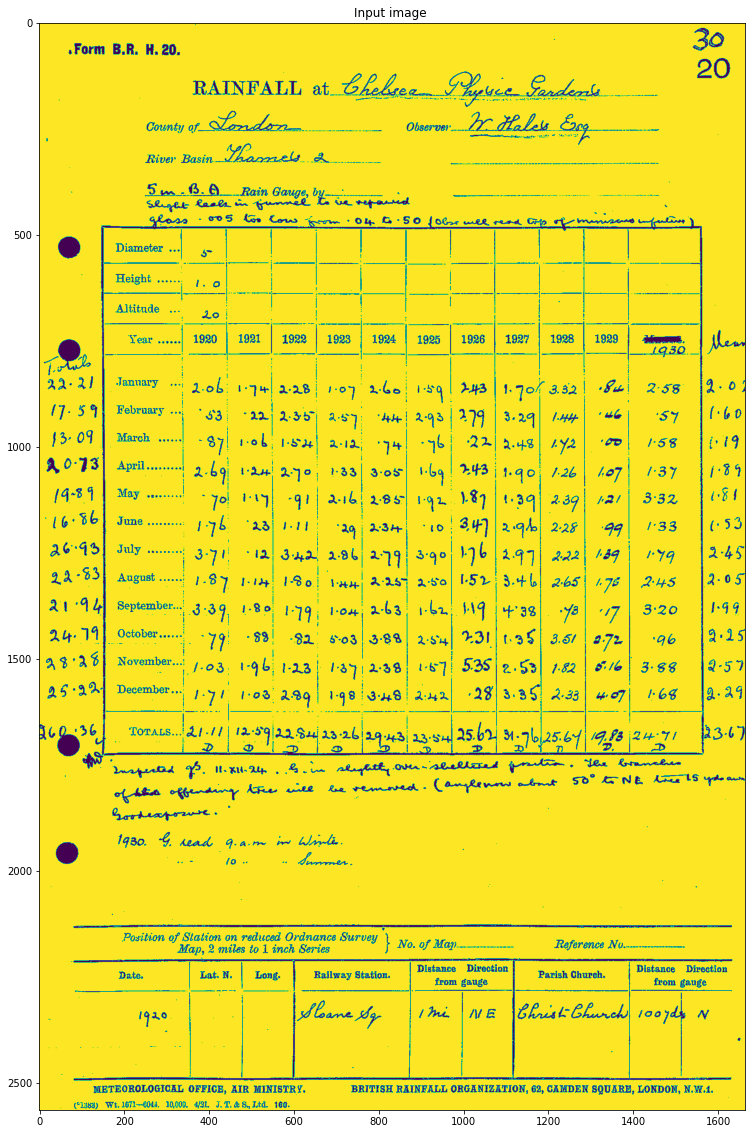

In [7]:
filename = 59
img_path = f'/data/glosat/Code-Git/docformer/dataset/Finetuning/test/images/{filename}.jpg'

img = cv.imread(img_path)


#Binarization
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Do dilation and erosion to eliminate unwanted noises
kernel = np.ones((1,1), np.uint8)
img = cv.dilate(img, kernel, iterations=30)
img = cv.erode(img, kernel, iterations=30)

#thresholding
def thresholding(image):
    return cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

img = thresholding(img)
plt.rcParams["figure.figsize"] = (30,20)
plt.imshow(img)
plt.title('Input image ')
plt.show()

In [8]:
# img = Image.open('146.jpg')
# Resize 
# img = cv2.resize(img, (img_size[0],img_size[1]), interpolation = cv2.INTER_AREA)

print(f'image size is: {img.size}')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Normalize and convert to Tensor
inp = np.array(img, dtype=np.float32) / 255
if normalize:
    inp = ((inp - inp.mean(axis=(0, 1))) / (inp.std(axis=(0, 1)) + 10**-7))
inp = torch.from_numpy(inp.transpose(2, 0, 1)).float().to(device)

image size is: 4266496


In [9]:
from utils.constant import LABEL_TO_COLOR_MAPPING
from utils.image import LabeledArray2Image

In [10]:

# compute prediction
pred = model_extractor(inp.reshape(1, *inp.shape))[0].max(0)[1].cpu().numpy()

# Retrieve good color mapping and transform to image
restricted_colors = [LABEL_TO_COLOR_MAPPING[l] for l in restricted_labels]
label_idx_color_mapping = {restricted_labels.index(l) + 1: c for l, c in zip(restricted_labels, restricted_colors)}
pred_img = LabeledArray2Image.convert(pred, label_idx_color_mapping)

im_pil = Image.fromarray(img)
# Blend predictions with original image
mask = Image.fromarray((np.array(pred_img) == (0, 0, 0)).all(axis=-1).astype(np.uint8) * 127 + 128)
blend_img = Image.composite(im_pil, pred_img, mask)

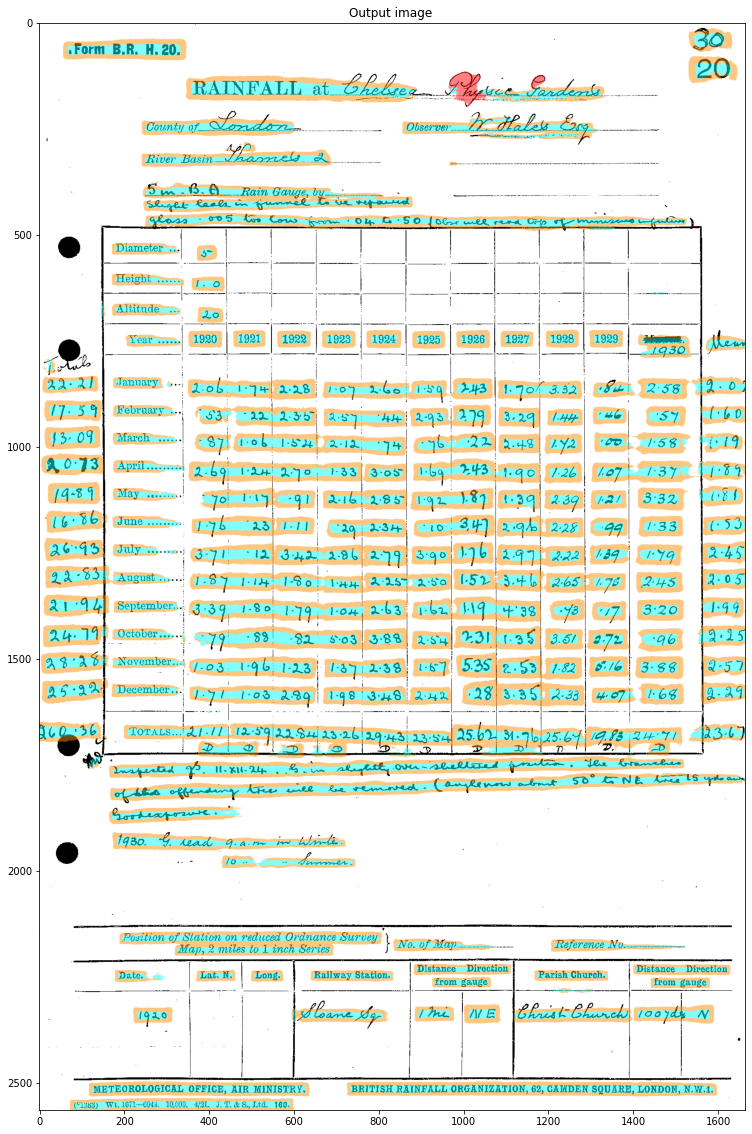

In [11]:
plt.rcParams["figure.figsize"] = (30,20)
plt.imshow(blend_img)
plt.title('Output image ')
plt.show()

In [12]:
blend_img.save(f'{filename}_text_region.jpg')

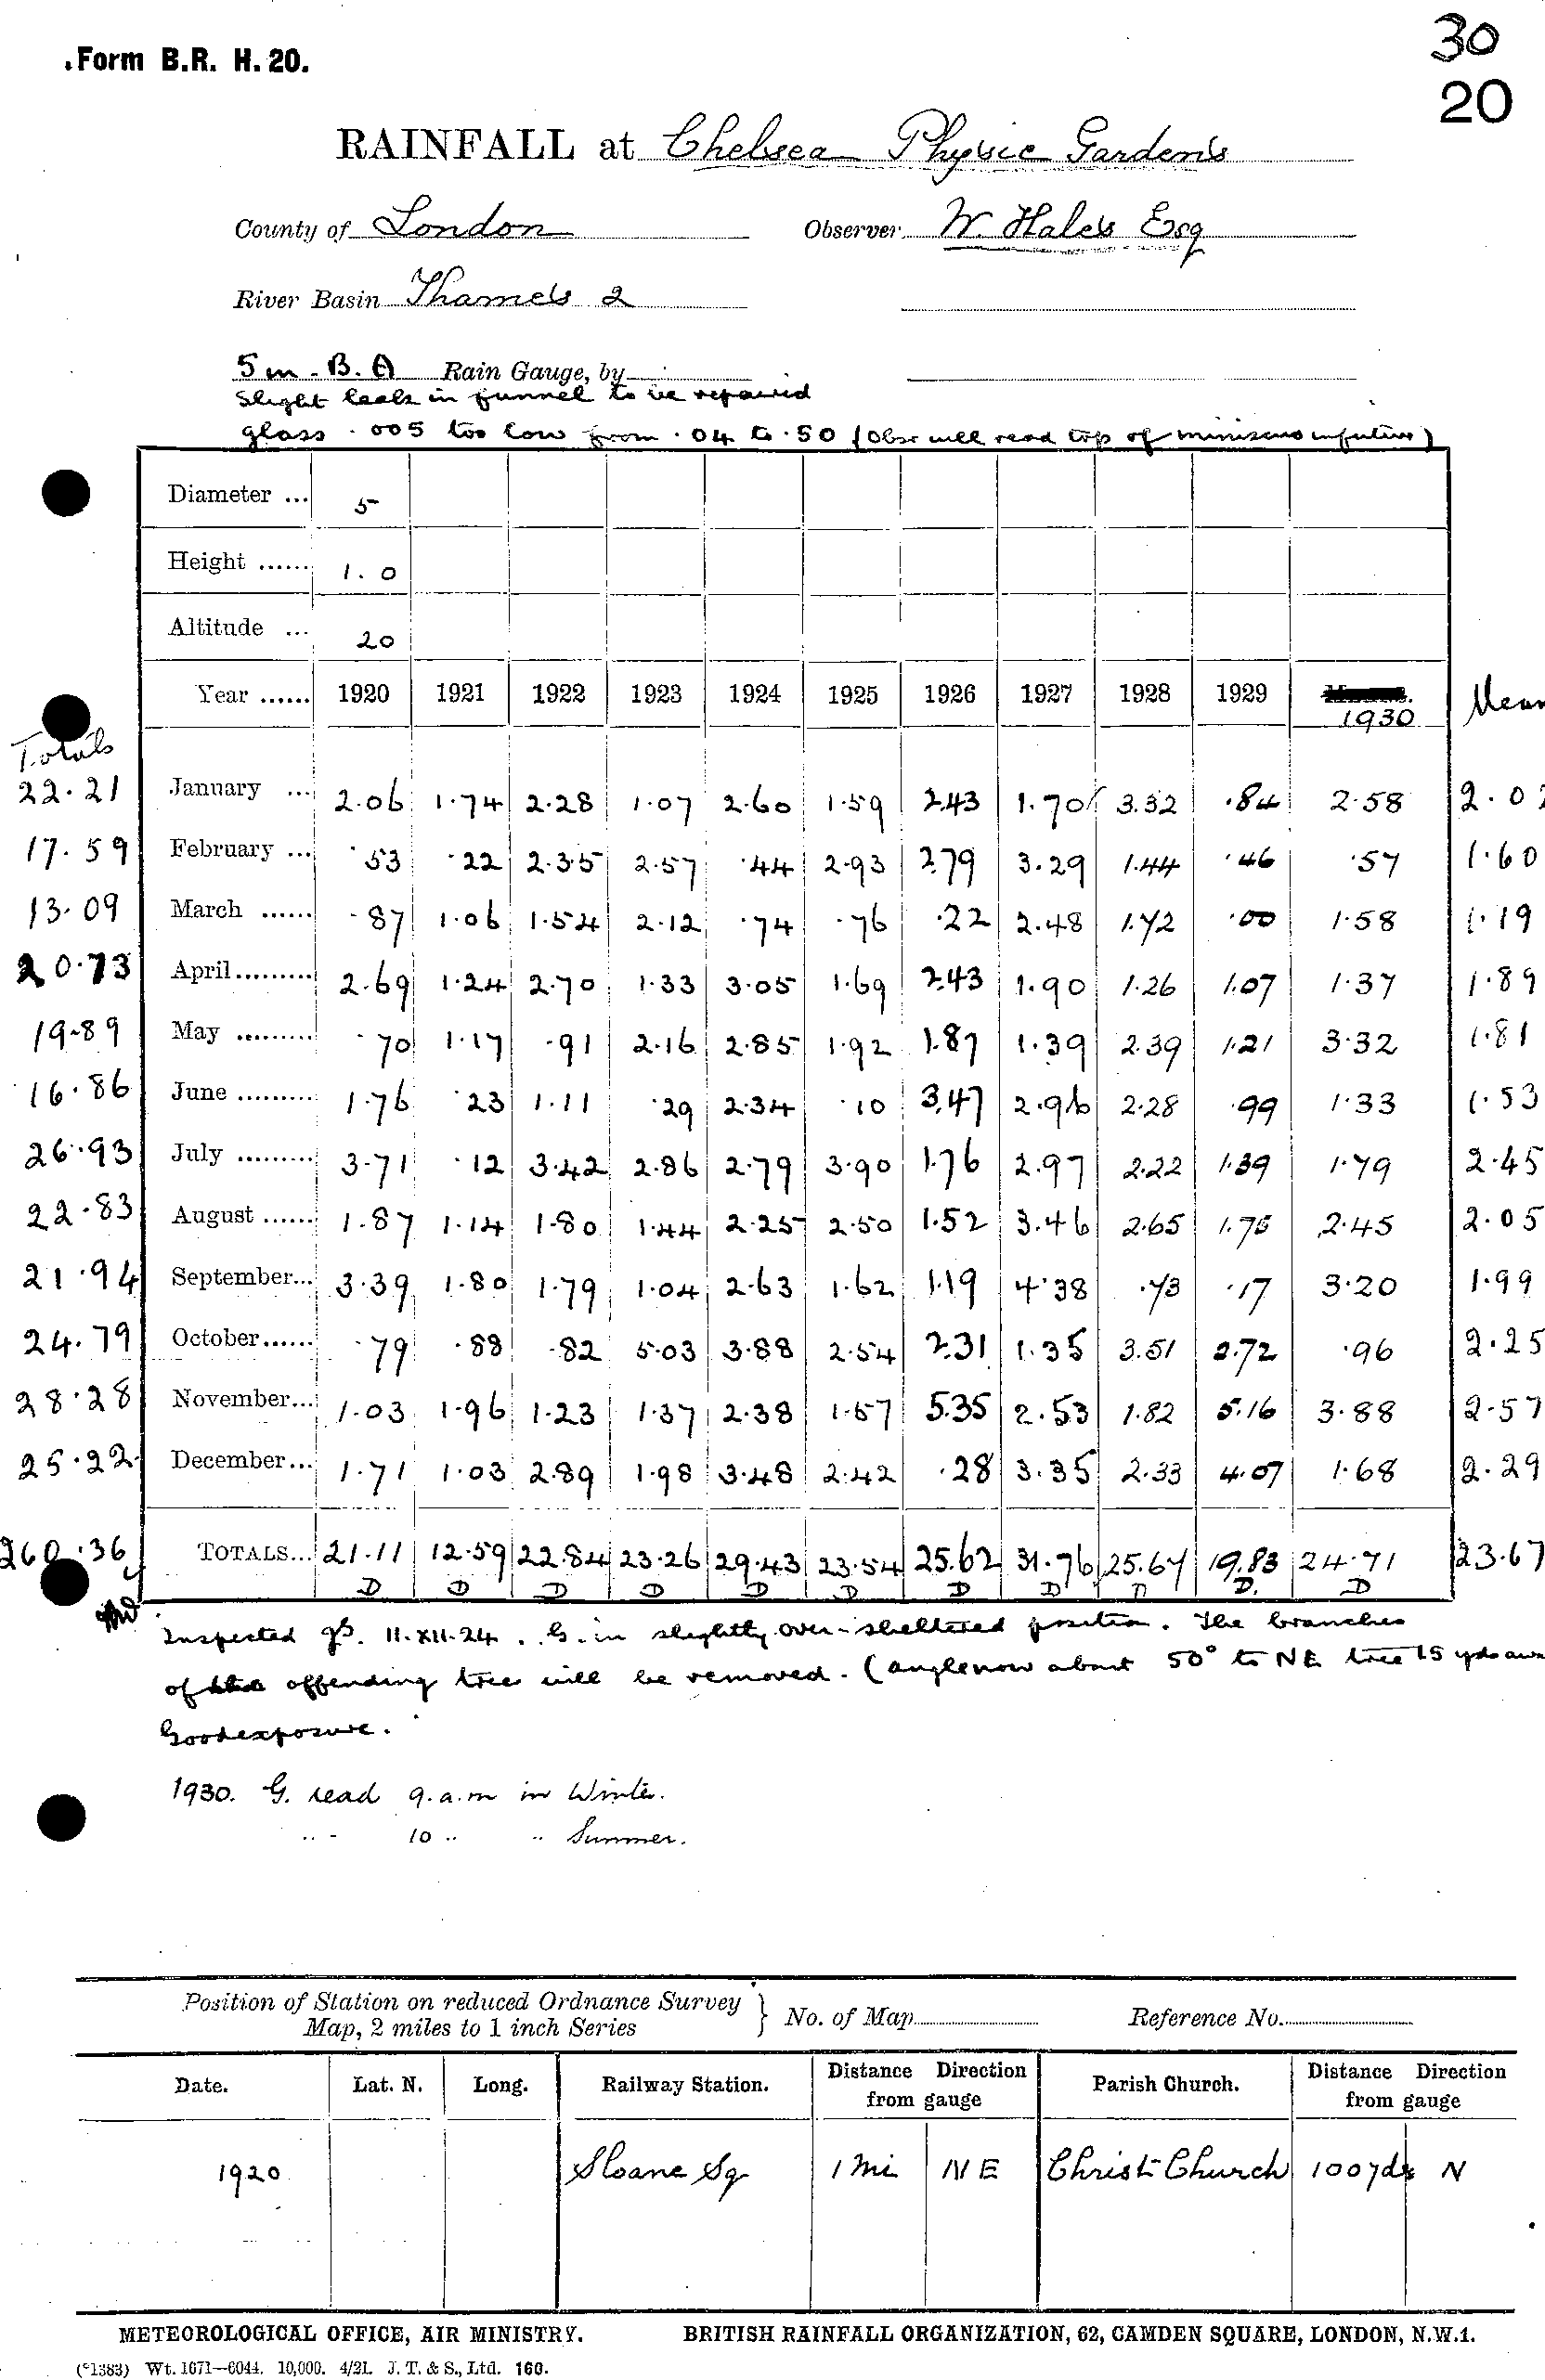

In [13]:
im_pil = Image.fromarray(img)
im_pil.save("temp.jpg")
im_pil

In [85]:
# ASSETS_DIRECTORY = "assets"
# plt.rcParams["savefig.bbox"] = "tight"

# def show(imgs):
#     if not isinstance(imgs, list):
#         imgs = [imgs]
#     fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
#     for i, img in enumerate(imgs):
#         img = img.detach()
#         img = F.to_pil_image(img)
#         axs[0, i].imshow(np.asarray(img))
#         axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [14]:
mask = torch.from_numpy(pred)
mask = mask.unsqueeze(0)

In [15]:
print(mask.size())
print(mask)

torch.Size([1, 2564, 1664])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


In [16]:
img = inp
img.size()

torch.Size([3, 2564, 1664])

In [17]:
# We get the unique colors, as these would be the object ids.
obj_ids = torch.unique(mask)

# first id is the background, so remove it.
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set of boolean masks.
# Note that this snippet would work as well if the masks were float values instead of ints.
masks = mask == obj_ids[:, None, None]

In [18]:
print(masks.size())
print(masks)

torch.Size([3, 2564, 1664])
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., Fals

### Intern code

In [19]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
import cv2 as cv
import collections

In [20]:
import dla.src.table_structure_analysis as tsa
import dla.src.xml_utils as xml_utils
from dla.src.image_utils import put_box, put_line
import pytesseract
import numpy as np

In [21]:
config_file = '/data/glosat/glosat_table_dataset/dla/config/cascadeRCNN.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
table_checkpoint_file = '/data/glosat/glosat_table_dataset/models/model_fulltables_only_GloSAT.pth'
# table_checkpoint_file = '/data/glosat/glosat_table_dataset/models/model_tables_enchanced_GloSAT.pth'


cell_checkpoint_file = '/data/glosat/glosat_table_dataset/models/model_coarsecell_GloSAT.pth'

In [22]:
def thresholding(image):
    return cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

def image_preprocessing(img_path):
    img = cv.imread(img_path)
#     img = cv.resize(img, (800,1200), interpolation = cv.INTER_AREA)
    
    #Binarization
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Do dilation and erosion to eliminate unwanted noises
    kernel = np.ones((1,1), np.uint8)
    img = cv.dilate(img, kernel, iterations=30)
    img = cv.erode(img, kernel, iterations=30)

    #thresholding
    img = thresholding(img)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    w,h,c = img.shape
    
    return img,h,w,c


In [23]:
THRESHOLD = 0.5
CLASSES = ("table_body","cell","full_table","header","heading")

### Cell classification

In [24]:
cell_model = init_detector(config_file, cell_checkpoint_file, device='cuda:0')

/data/glosat/glosat_table_dataset/mmdetection/mmdet/apis/inference.py:40: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [25]:
result = inference_detector(cell_model, "temp.jpg")

/home/gyanendro/.local/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [26]:
cells_by_image = collections.defaultdict(list)
coarse_cells_by_image = collections.defaultdict(list)

In [27]:
cells_by_image[img_path] = result[CLASSES.index("cell")].tolist()

### Output predicted cells

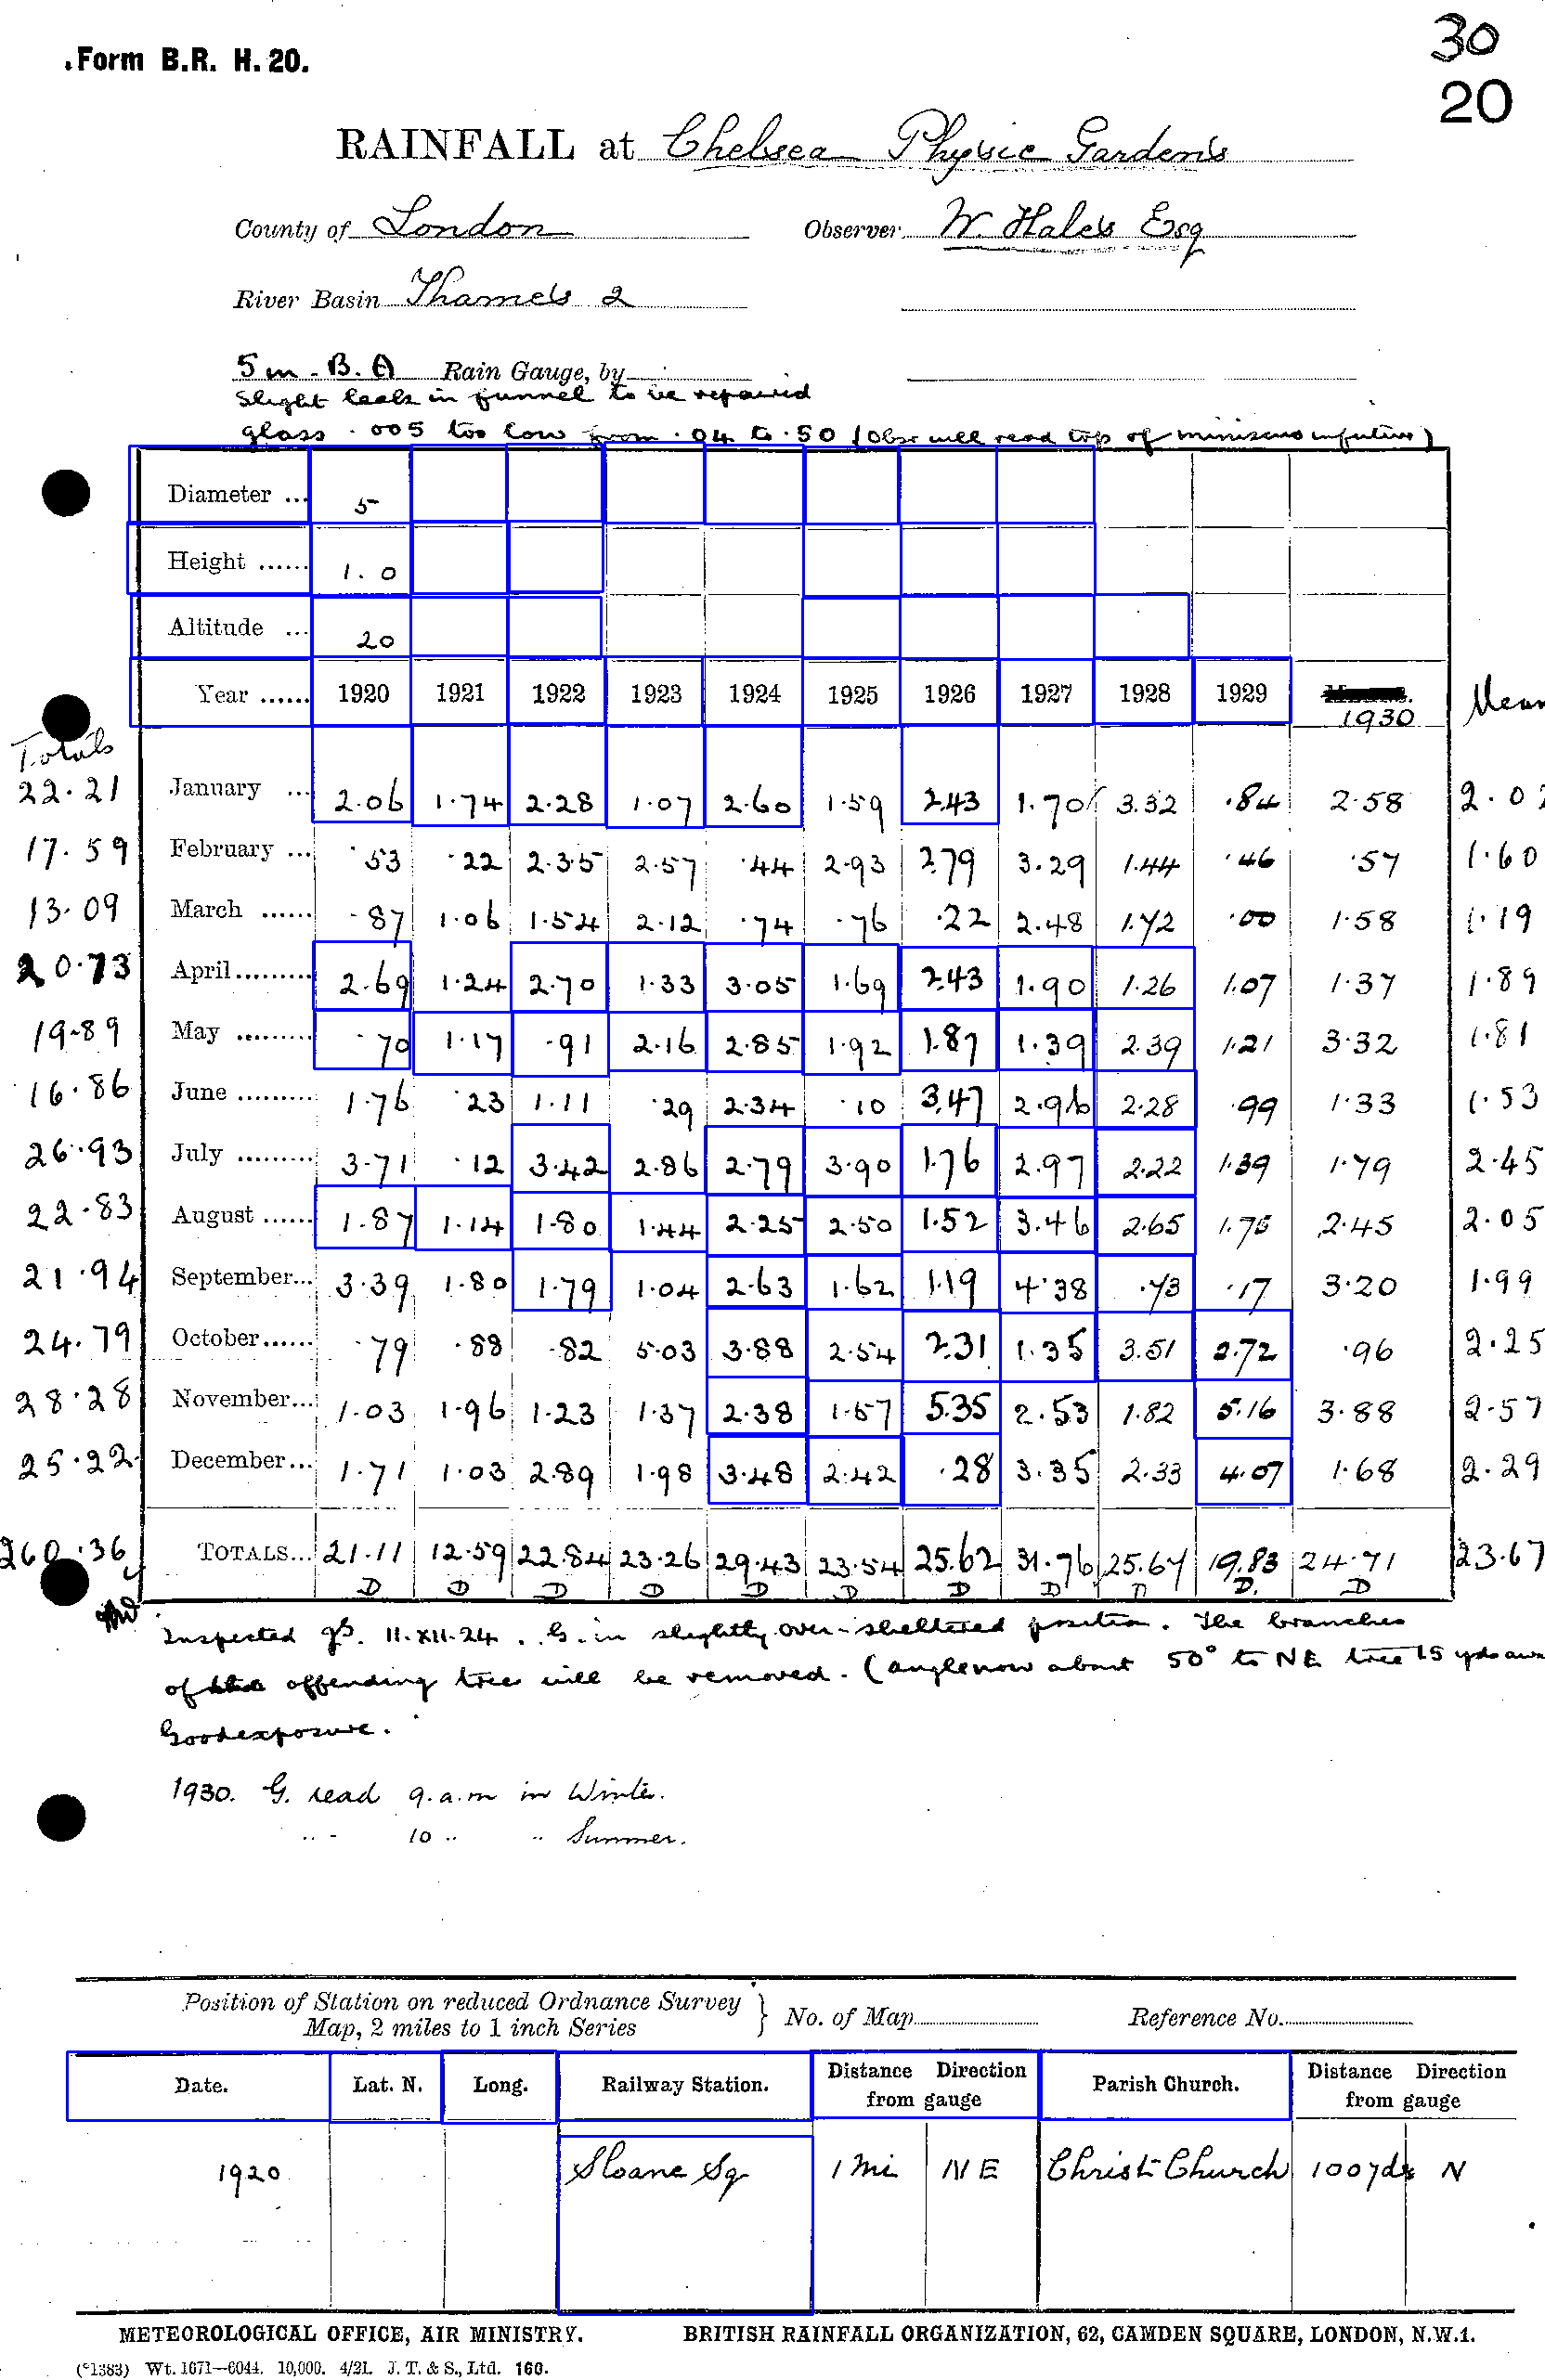

In [28]:
image, height, width, _ = image_preprocessing("temp.jpg")


for box in cells_by_image[img_path]:
    put_box(image,box,(0,0,255))

im_pil = Image.fromarray(image)
# im_pil.save("temp_intern.jpg")
im_pil

### Table detection

In [29]:
model = init_detector(config_file, table_checkpoint_file, device='cuda:0')

In [30]:
image, height, width, _ = image_preprocessing("temp.jpg")

In [31]:
result = inference_detector(model,image)

In [32]:
#Process table headings
headings = []
for box in result[CLASSES.index("heading")]:
    if box[4]>THRESHOLD :
        headings.append(box[0:4])

#         if args.visual:
#             put_box(image,box,(255,0,255),"heading")

#Process table headers
headers = []
for box in result[CLASSES.index("header")]:
    if box[4]>THRESHOLD :
        headers.append(box[0:4])

#         if args.visual:
#             put_box(image,box,(255,0,0),"header")

#Process table bodies
tables = []
for box in result[CLASSES.index("table_body")]:
    if box[4]>THRESHOLD :
        tables.append(box[0:4])

        put_box(image,box,(0,0,255),"table_body")

full_tables = []
for box in result[CLASSES.index("full_table")]:
    if box[4]>THRESHOLD :
        full_tables.append(box[0:4])
        if all(tsa.how_much_contained(table,box)<0.5 for table in tables):
            tables.append(box[0:4])
            put_box(image,box,(0,0,255),"table_body")
        
        put_box(image,box,(0,255,255),"Full_Table")
    
for table in tables:
    if all(tsa.how_much_contained(table,full_table)<0.5 for full_table in full_tables):
        full_tables.append(table)

### Check bounding box

In [33]:
def check_bounding_box(imagedraw,mask):
    scores = []
    count = 0
    
    key = imagedraw[1]
    for bol in mask[key,imagedraw[0]:imagedraw[2]]:  #Height
        if bol:
            count+=1
    score = count/len(mask[key,imagedraw[0]:imagedraw[2]])
    scores.append(score)
    if score<0.2: 
        top_height = True
    else:
        top_height = False
        
    count = 0
    key = imagedraw[3]
    for bol in mask[key,imagedraw[0]:imagedraw[2]]:  #Height
        if bol:
            count+=1
    score = count/len(mask[key,imagedraw[0]:imagedraw[2]])
    scores.append(score)
    if score<0.2:
        bottom_height = True
    else:
        bottom_height = False

    count = 0
    key = imagedraw[0]
    for bol in mask[imagedraw[1]:imagedraw[3],key]:  #width
        if bol:
            count+=1
    score = count/len(mask[imagedraw[1]:imagedraw[3],key])
    scores.append(score)
    if score<0.1:
        left_width = True
    else:
        left_width = False
        
    count = 0    
    key = imagedraw[2]
    for bol in mask[imagedraw[1]:imagedraw[3],key]:  #width
        if bol:
            count+=1
    score = count/len(mask[imagedraw[1]:imagedraw[3],key])
    scores.append(score)
    if score<0.1:
        right_width = True
    else:
        right_width = False
        
    return (top_height, bottom_height, left_width, right_width), scores

In [34]:
def has_object(imagedraw, image,mask):
    imagedraw = list(map(int, imagedraw))
    croppedimage_full=image[int(imagedraw[1]):int(imagedraw[3]),int(imagedraw[0]):int(imagedraw[2])]
    h, w, c = croppedimage_full.shape
    
    count = 0
    for cell_mask in mask[imagedraw[1]:imagedraw[3],imagedraw[0]:imagedraw[2]]:
        for bol in cell_mask:  
            if bol:
                count+=1
    
    if w>2 and h>2:
        if 100*(count/(w * h)) > 1:
            return True
        else:
            return False
    else:
        return False


In [35]:
def classify_single_cell(cells):    
    x = torch.IntTensor(cells)
    x = x[:,0:4]
    value, index = x[:,1].sort()

    corrected_cells = []
    exclude_cells = []
    blank_cells = []
    for idx in index:
        imagedraw = cells[idx][0:4]
        imagedraw = list(map(int, imagedraw))
#         print(imagedraw,idx)
    #     if has_object(imagedraw, image):
        boolean, scores = check_bounding_box(imagedraw,masks[1])

        if all(boolean):
            corrected_cells.append(cells[idx])
        else:
            exclude_cells.append(cells[idx])
    return corrected_cells, exclude_cells

In [36]:
ori_correct_cells, exclude_cells = classify_single_cell(cells_by_image[img_path])

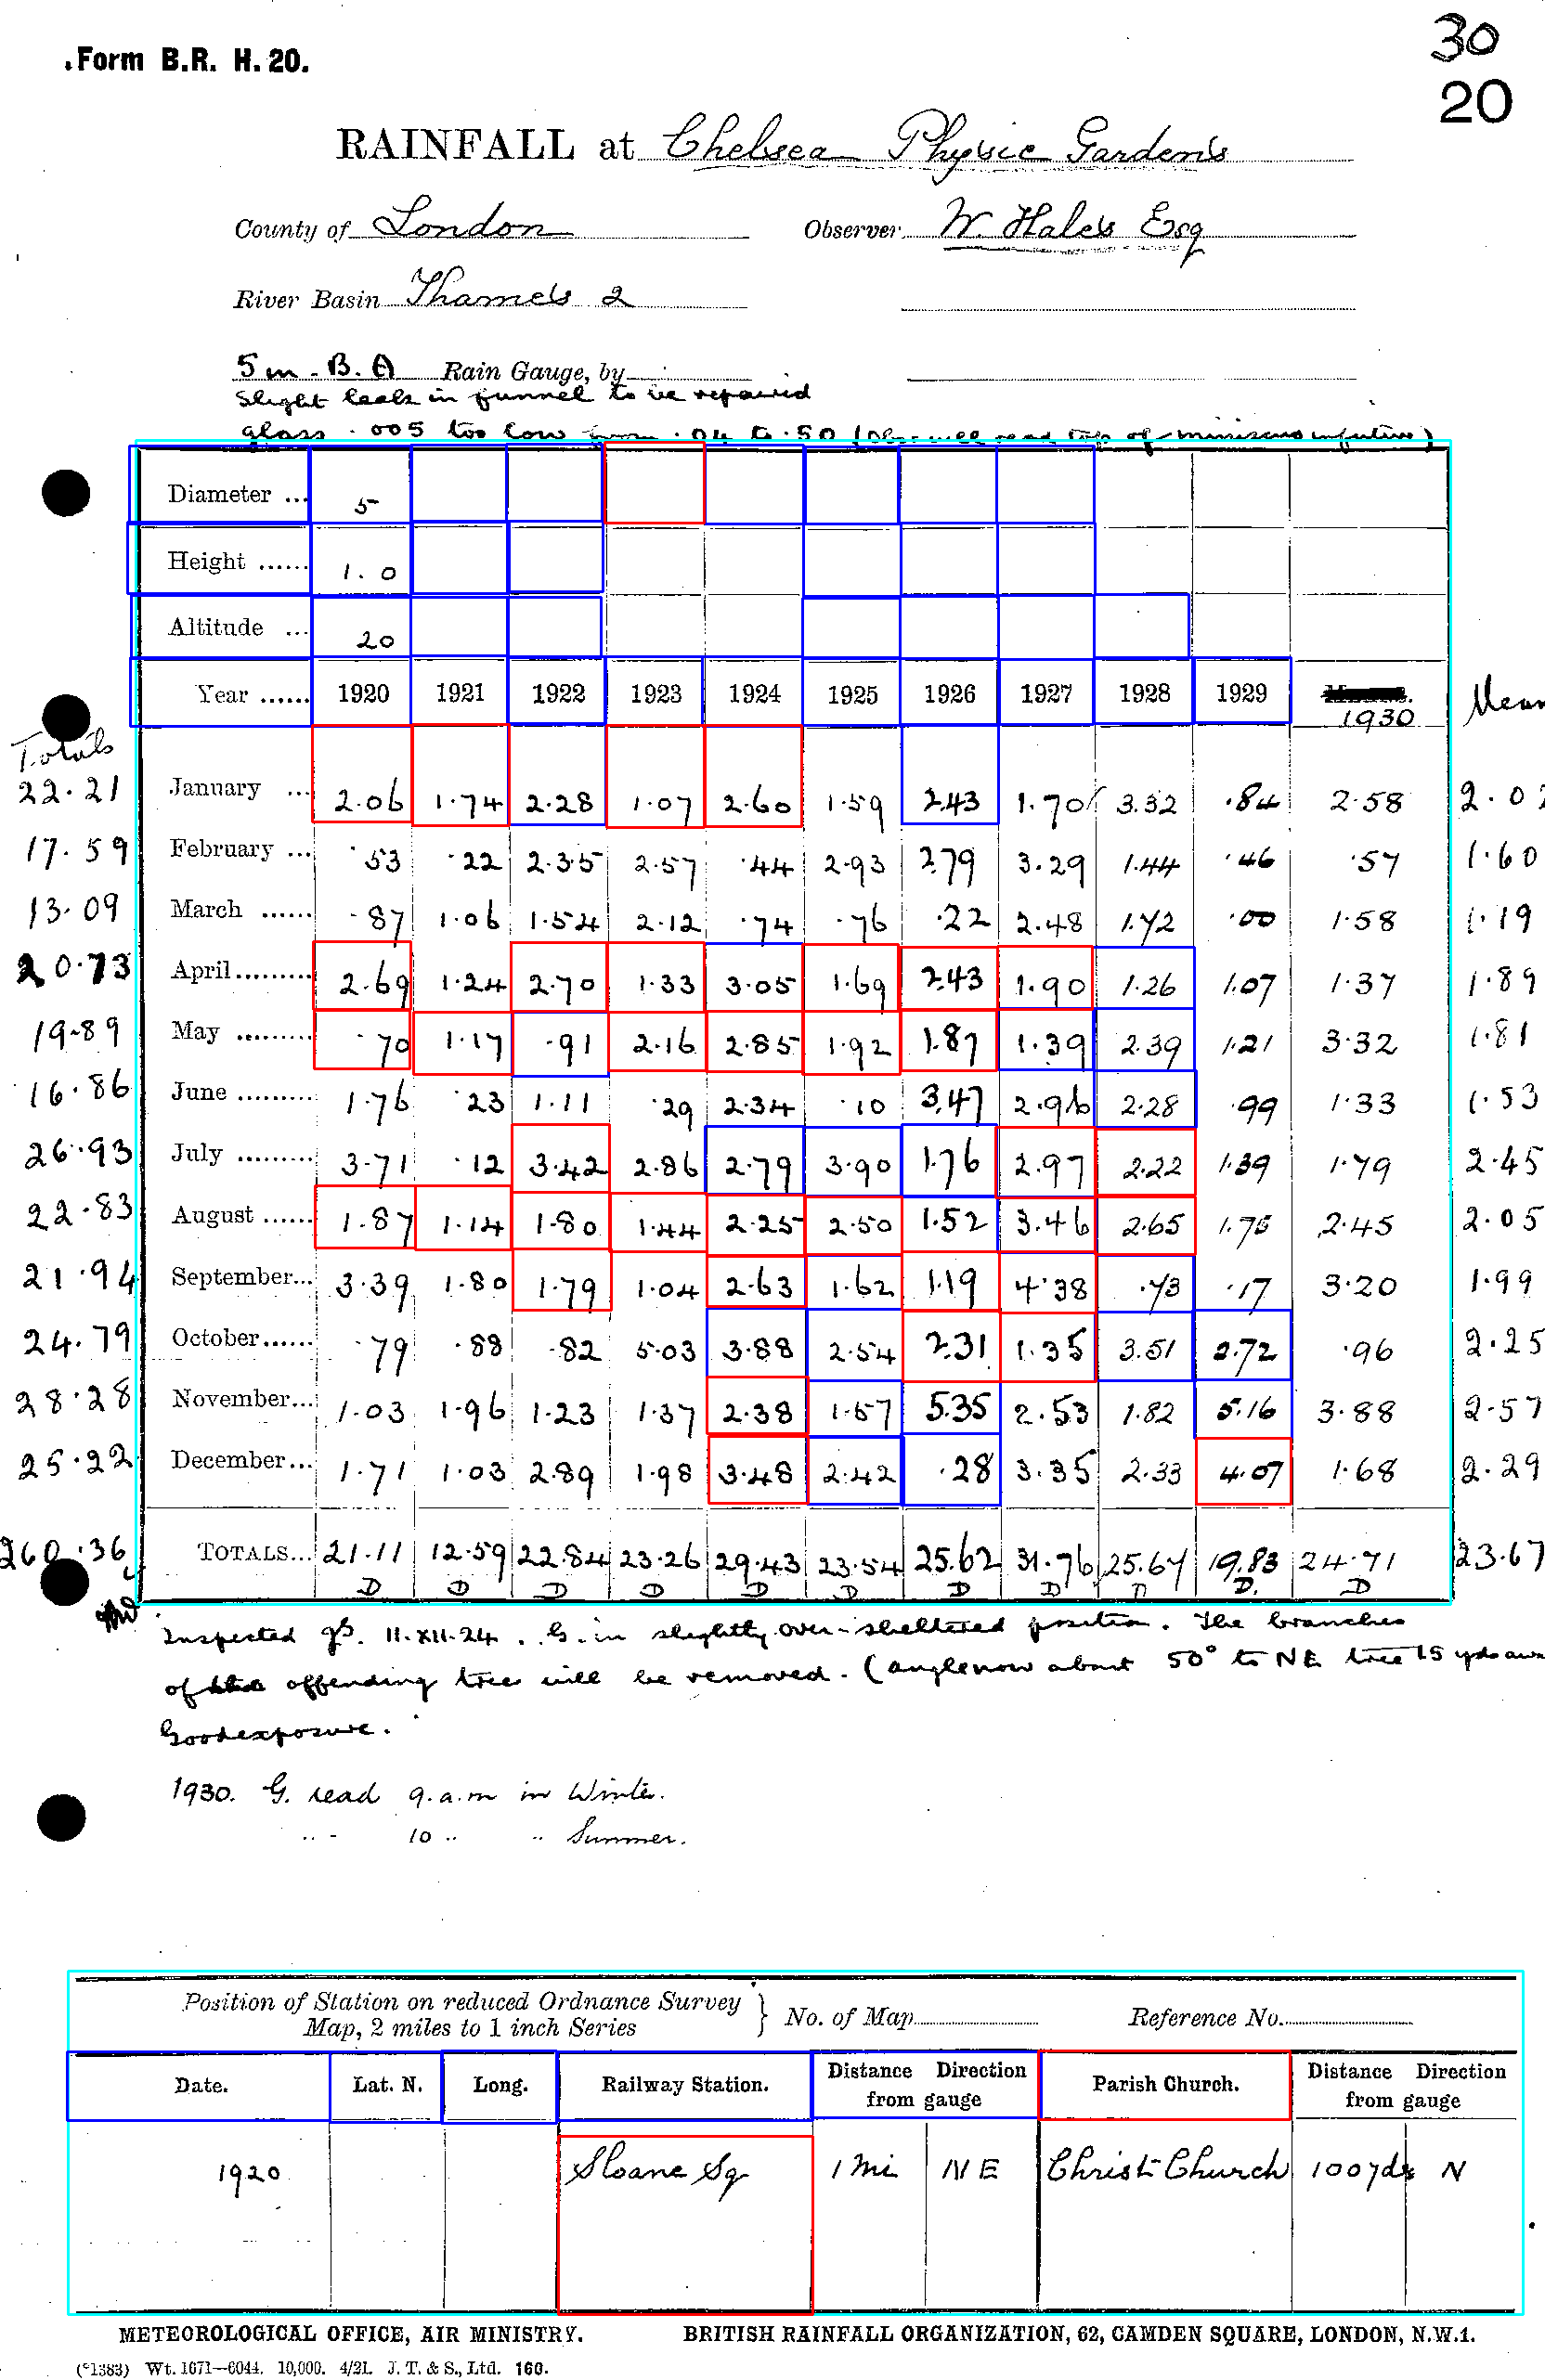

In [37]:
image, height, width, _ = image_preprocessing("temp.jpg")

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
        
for box in ori_correct_cells:
    put_box(image,box,(0,0,color)) # Blue
    
for box in exclude_cells:
#     print(box)
    put_box(image,box,(color,0,0)) # Red

im_pil = Image.fromarray(image)
im_pil.save(f"{filename}_table_cell_classification_pretrained.jpg")
im_pil  

### Line function output

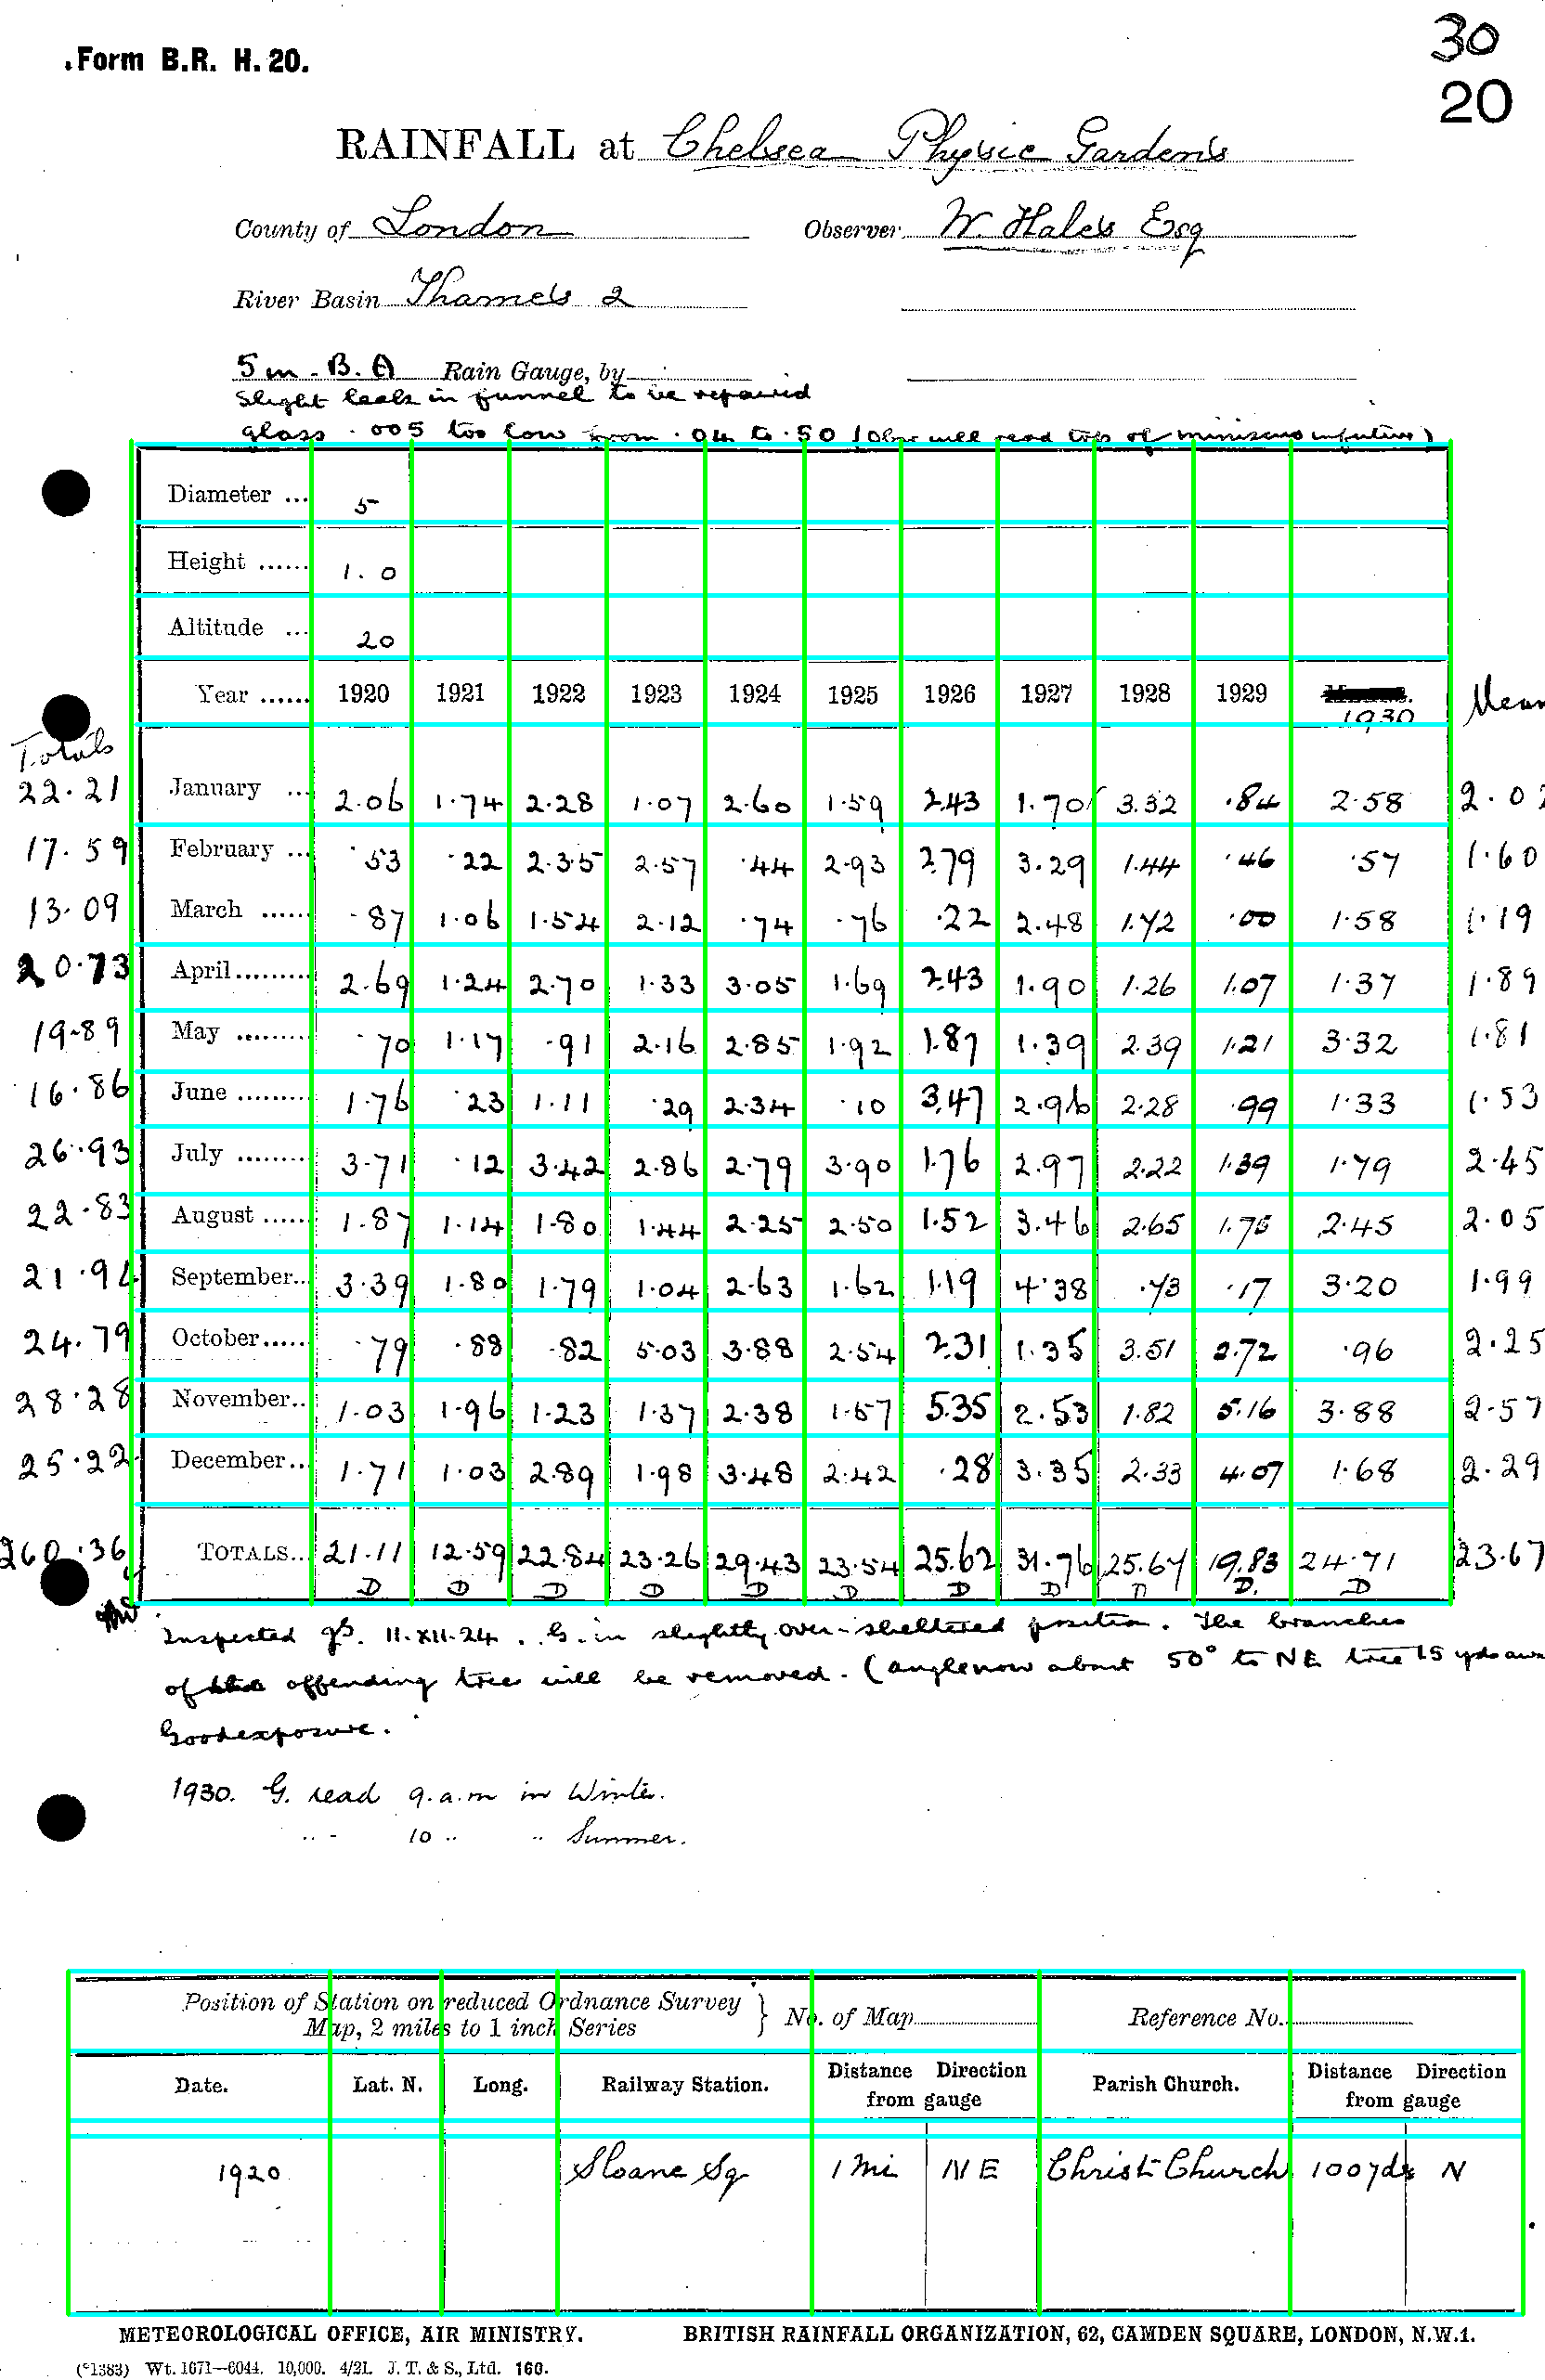

In [38]:
image, height, width, _ = image_preprocessing("temp.jpg")

#Process cells
segment_headers = False
rows_by_table = []
cols_by_table = []
full_table_by_table = []

for table in tables:
    cells = []
    coarse_cells = []

    found_fulltable = False
    for full_table in full_tables:
        if tsa.how_much_contained(table,full_table)>0.5:
            full_table_by_table.append(full_table)
            found_fulltable = True
            break

    if not found_fulltable:
        full_table_by_table.append(table)

    if cell_checkpoint_file:
        for box in cells_by_image[img_path]:  #cells_by_image[img_path]: #
            cell = box[0:4]

            if box[4]>THRESHOLD:
                if tsa.how_much_contained(cell,table if not segment_headers else full_table_by_table[-1])>0.5:
                    cells.append(cell)
                    #if args.visual:
                    #    put_box(image,box,(0,0,0))

    if cells != [] or coarse_cells!=[]:
        rows, cols = tsa.reconstruct_table(cells,table if segment_headers else full_table_by_table[-1],eps=0.02)
    else:
        rows,cols = [],[]

    for row in rows:
        put_line(image,((int)(table[0]),(int)(row)),((int)(table[2]),(int)(row)),colour=(0,255,250))

    for col in cols:
        put_line(image,((int)(col),(int)(table[1])),((int)(col),(int)(table[3])),colour=(0,255,0))

    rows_by_table.append(rows)
    cols_by_table.append(cols)

    
im_pil = Image.fromarray(image)
im_pil.save(f"{filename}_temp_intern_Line_function_image.jpg")
im_pil

### Generate cells

In [39]:
from statistics import mean

In [40]:
def get_x_y_initial(tables, cells, THRESHOLD):   
    segment_headers =  False
    table_cells = []
    for tid, table in enumerate(tables):
        cells_x = []
        cells_y = []
        for box in cells:  #cells_by_image[img_path]: #
            cell = box[0:4] #(x0,y0,x1,y1)

            if box[4]>THRESHOLD:
                if tsa.how_much_contained(cell,table)>0.5:
                    cells_x.append(cell[0])
                    cells_x.append(cell[2])
                    cells_y.append(cell[1])
                    cells_y.append(cell[3])
                else:
                    pass
#                     print(cell,table)
        table_cells.append([cells_x, cells_y])
    return table_cells

def get_x_y(tables, cells):   
    segment_headers =  False
    table_cells = []
    for table in tables:
        cells_x = []
        cells_y = []
        for box in cells:  #cells_by_image[img_path]: #
            cell = box[0:4] #(x0,y0,x1,y1)
            
            if tsa.how_much_contained(cell,table)>0.5:
                cells_x.append(cell[0])
                cells_x.append(cell[2])
                cells_y.append(cell[1])
                cells_y.append(cell[3])
            else:
                pass
#                     print(cell,table)
        table_cells.append([cells_x, cells_y])
    return table_cells  

In [41]:
def average_list(cells):        
    x_avg = 0
    for i in cells:
        x_avg+=i
    x_avg = x_avg/len(cells)
    return x_avg

In [42]:
def find_coordinates(x_coords, x_avg, cell_size_pc):
    new_x_coords = []
    flag_j = False
    last_flag = True
    count = 0 

    for i,j in zip(x_coords[0:-1],x_coords[1:]):
        if count==0:
            new_x_coords.append(i)

        if abs(i-j)>x_avg*cell_size_pc:
            new_x_coords.append(j)
            flag_j = True
            last_flag = True

        elif not last_flag:
            new_x_coords.append(j)
            last_flag = True

        else:
            flag_j = False
            last_flag =  False

#         print(i,j,abs(i-j),x_avg*0.6, flag_j, last_flag)
        count+=1

    return new_x_coords


In [43]:
def avg_coordinates(cells_x):
    new_x = []   
    avg = mean([j-i for i,j in zip(cells_x[0:-1],cells_x[1:])])/3  ###why 3
#     print(cells_x, avg)
    
    while len(cells_x)>0:
        x=cells_x.pop()
        
        if len(new_x)>0 and abs(x - new_x[-1])<avg:  # last insert is near to current value then skip current value pop out
            new_x[-1] = int((x + new_x[-1])/2)
        else:
            if len(cells_x)>0:
                if abs(x - cells_x[-1])<avg:
                    n_c = int((x + cells_x[-1])/2)
                    x = cells_x.pop()
                    new_x.append(n_c)
                else:
                    new_x.append(x)
            else:
                new_x.append(x)
#             print(new_x)
    
    new_x = [i for i in reversed(new_x)] 
    return new_x

In [44]:
def get_coordinates(table_cells, pc):    
    cell_cordinates = []
    new_x = []
    new_y = []
    for cells_x, cells_y in table_cells:
        cells_x = list(map(int, cells_x))
        cells_x = list(set(cells_x))
        values, _ = torch.Tensor(cells_x).int().sort()
        cells_x = values.tolist()    

        cells_y = list(map(int, cells_y))
        cells_y = list(set(cells_y))
        values, _ = torch.Tensor(cells_y).int().sort()
        cells_y = values.tolist()

        new_y = list(cells_y)
        new_y = avg_coordinates(new_y)
#         new_y = avg_coordinates(new_y)
#     #     new_y = avg_coordinates(new_y)
#         print('----y',new_y,'\n')

        new_x = list(cells_x)
        new_x = avg_coordinates(new_x)
#         new_x = avg_coordinates(new_x)
    #     new_x = avg_coordinates(new_x)
    #     print('----x',new_x,'\n')
    #     print(new_x,'\n',new_y)
        cell_cordinates.append([new_x,new_y])
        
    average_cordinates = []
    for tid, (x_cords, y_cords) in enumerate(cell_cordinates):

        x_size = [abs(i-j) for i, j in zip(x_cords[0:-1], x_cords[1:])]
        y_size = [abs(i-j) for i, j in zip(y_cords[0:-1], y_cords[1:])]

        x_avg = average_list(x_size)
        y_avg = average_list(y_size)

        average_cordinates.append((x_avg, y_avg))
        
    new_cell_cordinates = []
    for idx, coords in enumerate(cell_cordinates):
        x_coords, y_coords = coords
        x_avg, y_avg = average_cordinates[idx]
        new_x_coords = find_coordinates(x_coords, x_avg, pc)
        new_y_coords = find_coordinates(y_coords, y_avg, pc)

#         print('x_coords',x_coords, x_avg, new_x_coords)
#         print('y_coords',y_coords, y_avg, new_y_coords)
        
        new_cell_cordinates.append([new_x_coords, new_y_coords])
    
    return new_cell_cordinates, average_cordinates

# print(new_x,'\n',new_y)   

In [45]:
# average nearby corodinates:
def find_average_coordinates(cells_x):
    new_x = []   
    avg = mean([abs(i-j) for i,j in zip(cells_x[0:-1],cells_x[1:])])/3
#     print(cells_x, avg)
    
    while len(cells_x)>0:
        x=cells_x.pop()
        
        if len(new_x)>0 and abs(x - new_x[-1])<avg:  # last insert is near to current value then skip current value pop out
            new_x[-1] = int((x + new_x[-1])/2)
        else:
            if len(cells_x)>0:
                if abs(x - cells_x[-1])<avg:
                    n_c = int((x + cells_x[-1])/2)
                    x = cells_x.pop()
                    new_x.append(n_c)
                else:
                    new_x.append(x)
            else:
                new_x.append(x)
#             print(new_x)
    
    new_x = [i for i in reversed(new_x)] 
    return new_x

In [46]:
def classify_cells(cells, mask, average_coordinates):
    x = torch.IntTensor(cells)
    x = x[:,0:4]
    value, index = x[:,1].sort()

    corrected_cells_new = []
    exclude_cells_new = []
    blank_cells_new = []

    for idx in index:
        imagedraw = cells[idx][0:4]
        tid = cells[idx][4]
        imagedraw = list(map(int, imagedraw))

        x_avg,y_avg = average_coordinates[tid]

        boolean, scores = check_bounding_box(imagedraw,mask)

        objects = has_object(imagedraw, image, mask)

        if all(boolean) and objects:
            corrected_cells_new.append(cells[idx])

        elif not objects:
            blank_cells_new.append(cells[idx])

        else:
            exclude_cells_new.append(cells[idx])

    return corrected_cells_new, blank_cells_new, exclude_cells_new

In [47]:
def generate_cells(mask, tables, cell_cordinates, average_coordinates):

    exclude_cells_pred = []
    possible_cells  = []
    
    for idx, table in enumerate(tables):
        x_avg, y_avg = average_coordinates[idx]
        
        x0,y0,xn,yn = table
        cells_x, cells_y = cell_cordinates[idx]
        cells_x = [x0]+cells_x
        cells_y = [y0]+cells_y
        
        cells_x = [x for x in cells_x if x<xn]
        cells_x+=[xn]
        cells_y = [y for y in cells_y if y<yn]
        cells_y+=[yn]

        x_a = x0
        for r, x_b in enumerate(cells_x):
            if (x_b-x_a)>2:
                row_a = [(int(x_a),y) for y in cells_y]
                row_b = [(int(x_b),y) for y in cells_y]

                select_cells = []

                for i in range(len(row_a)-1):
                    imagedraw = (row_a[i]+row_b[i+1])
                # select_cells

    #             for imagedraw in select_cells:
                    imagedraw = list(map(int, imagedraw))

                    xax = abs(imagedraw[2] - imagedraw[0])
                    yax = abs(imagedraw[3] - imagedraw[1])

                    if xax > x_avg/2 and yax > y_avg/2:
                        possible_cells.append(imagedraw+[idx])
                    else:
                        exclude_cells_pred.append(imagedraw+[idx])
                        
                x_a = int(x_b)
            
    return possible_cells, exclude_cells_pred

In [48]:
def find_overlapped_cell(corrected_cells, cells_pred):
    new_cells_pred = []
    for box in cells_pred:
        count=0        
#         croppedimage_check=image[int(box[1]):int(box[3]),int(box[0]):int(box[2])]

        for cells in corrected_cells:
#             croppedimage_target=image[int(cells[1]):int(cells[3]),int(cells[0]):int(cells[2])]
            
#             fig = plt.figure(figsize=(8, 8))
#             fig.add_subplot(1, 2, 1)
#             plt.imshow(croppedimage_check)
            
#             fig.add_subplot(1, 2, 2)
#             plt.imshow(croppedimage_target)              
#             plt.show()
            
            if tsa.how_much_contained(box, cells)>0.5:
                count+=1
#                 print('Yes')
                break
        if count==0:
#             print('No')
            new_cells_pred.append(box)
            
    return new_cells_pred

### Generate cell coordinates

In [49]:
table_cells = get_x_y_initial(tables, cells_by_image[img_path], THRESHOLD)
cell_cordinates, average_cordinates = get_coordinates(table_cells,0.7)

In [50]:
possible_cells, exclude_cells_pred = generate_cells(masks[1], tables, cell_cordinates, average_cordinates)
correct_cells, blank_cells, exclude_cells = classify_cells(possible_cells, masks[1], average_cordinates)    

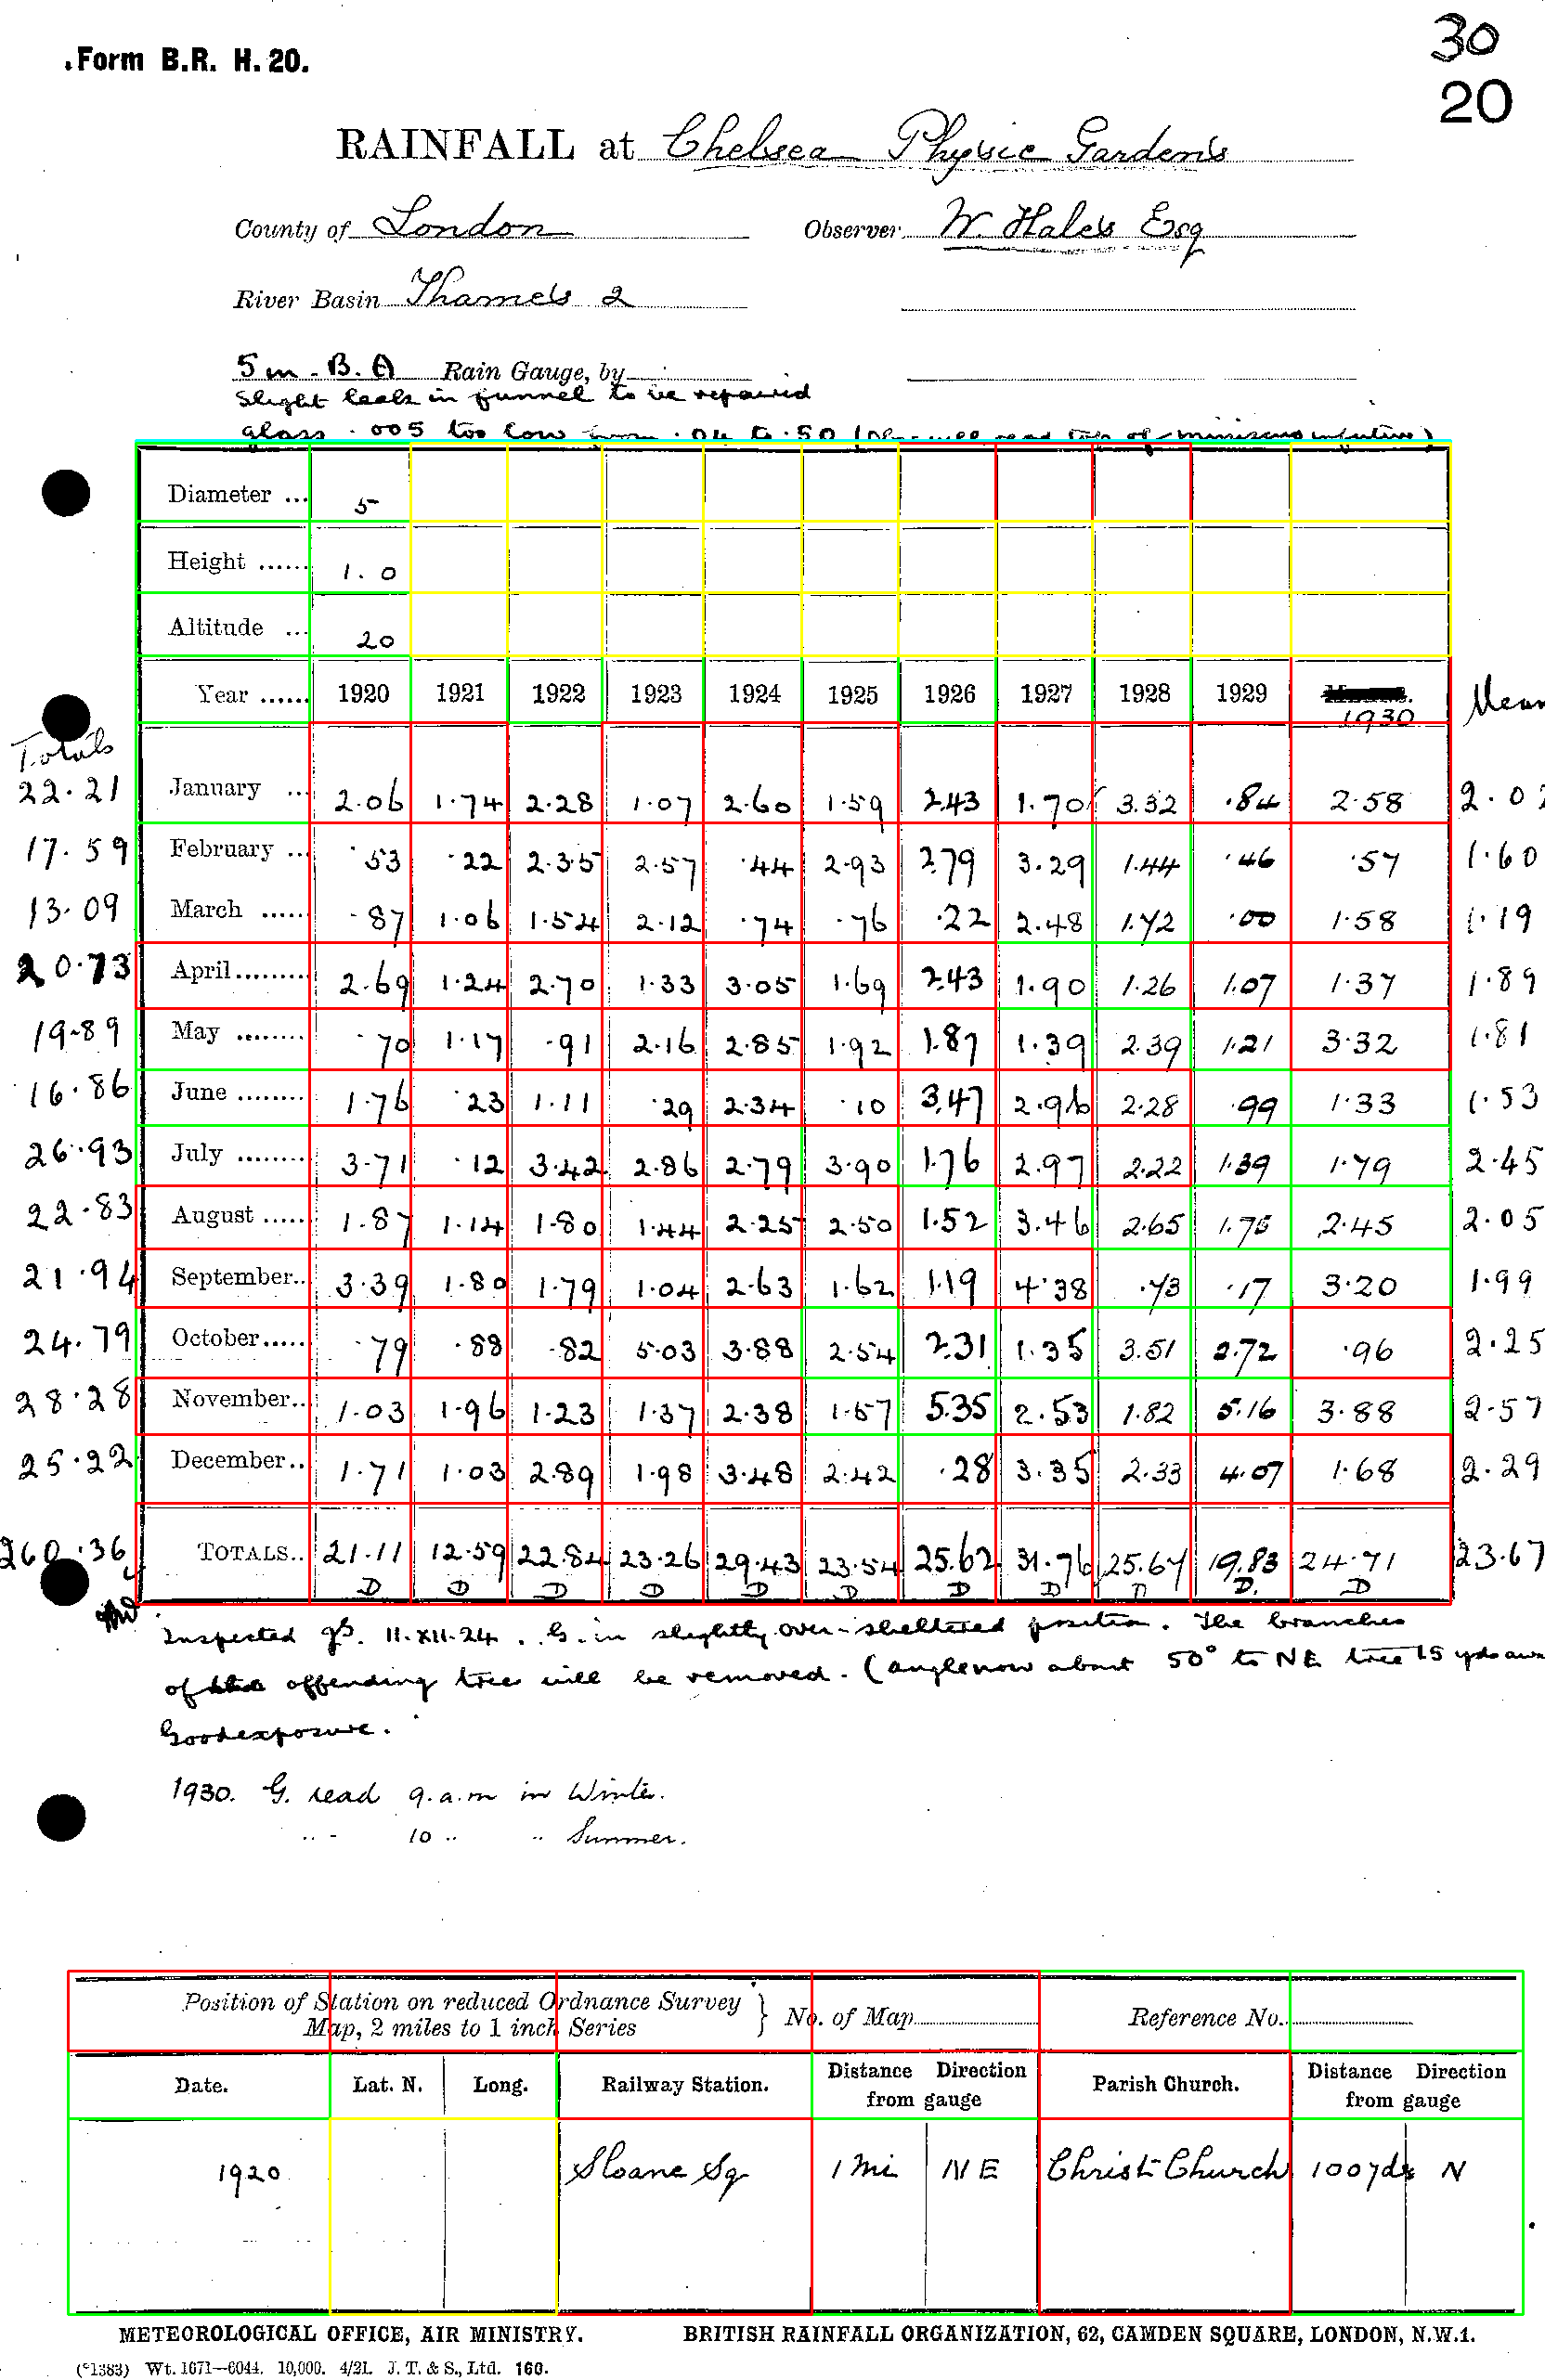

In [51]:
image, height, width, _ = image_preprocessing("temp.jpg")

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in correct_cells:
    put_box(image,box,(0,color,0)) # Green

for box in exclude_cells:
    put_box(image,box,(color,0,0)) # Red

for box in blank_cells:
    put_box(image,box,(color,color,0)) # Yellow

im_pil = Image.fromarray(image)
im_pil.save(f"{filename}_temp_cell_classification_generation.jpg")
im_pil  

### Filter overlapped error cell

In [52]:
not_ovellapped_blank_cells_pred =  find_overlapped_cell(correct_cells, blank_cells)
considered_cells = correct_cells+not_ovellapped_blank_cells_pred

In [53]:
len(exclude_cells)

106

In [54]:
not_ovellapped_exclude_cells_pred =  find_overlapped_cell(considered_cells, exclude_cells)

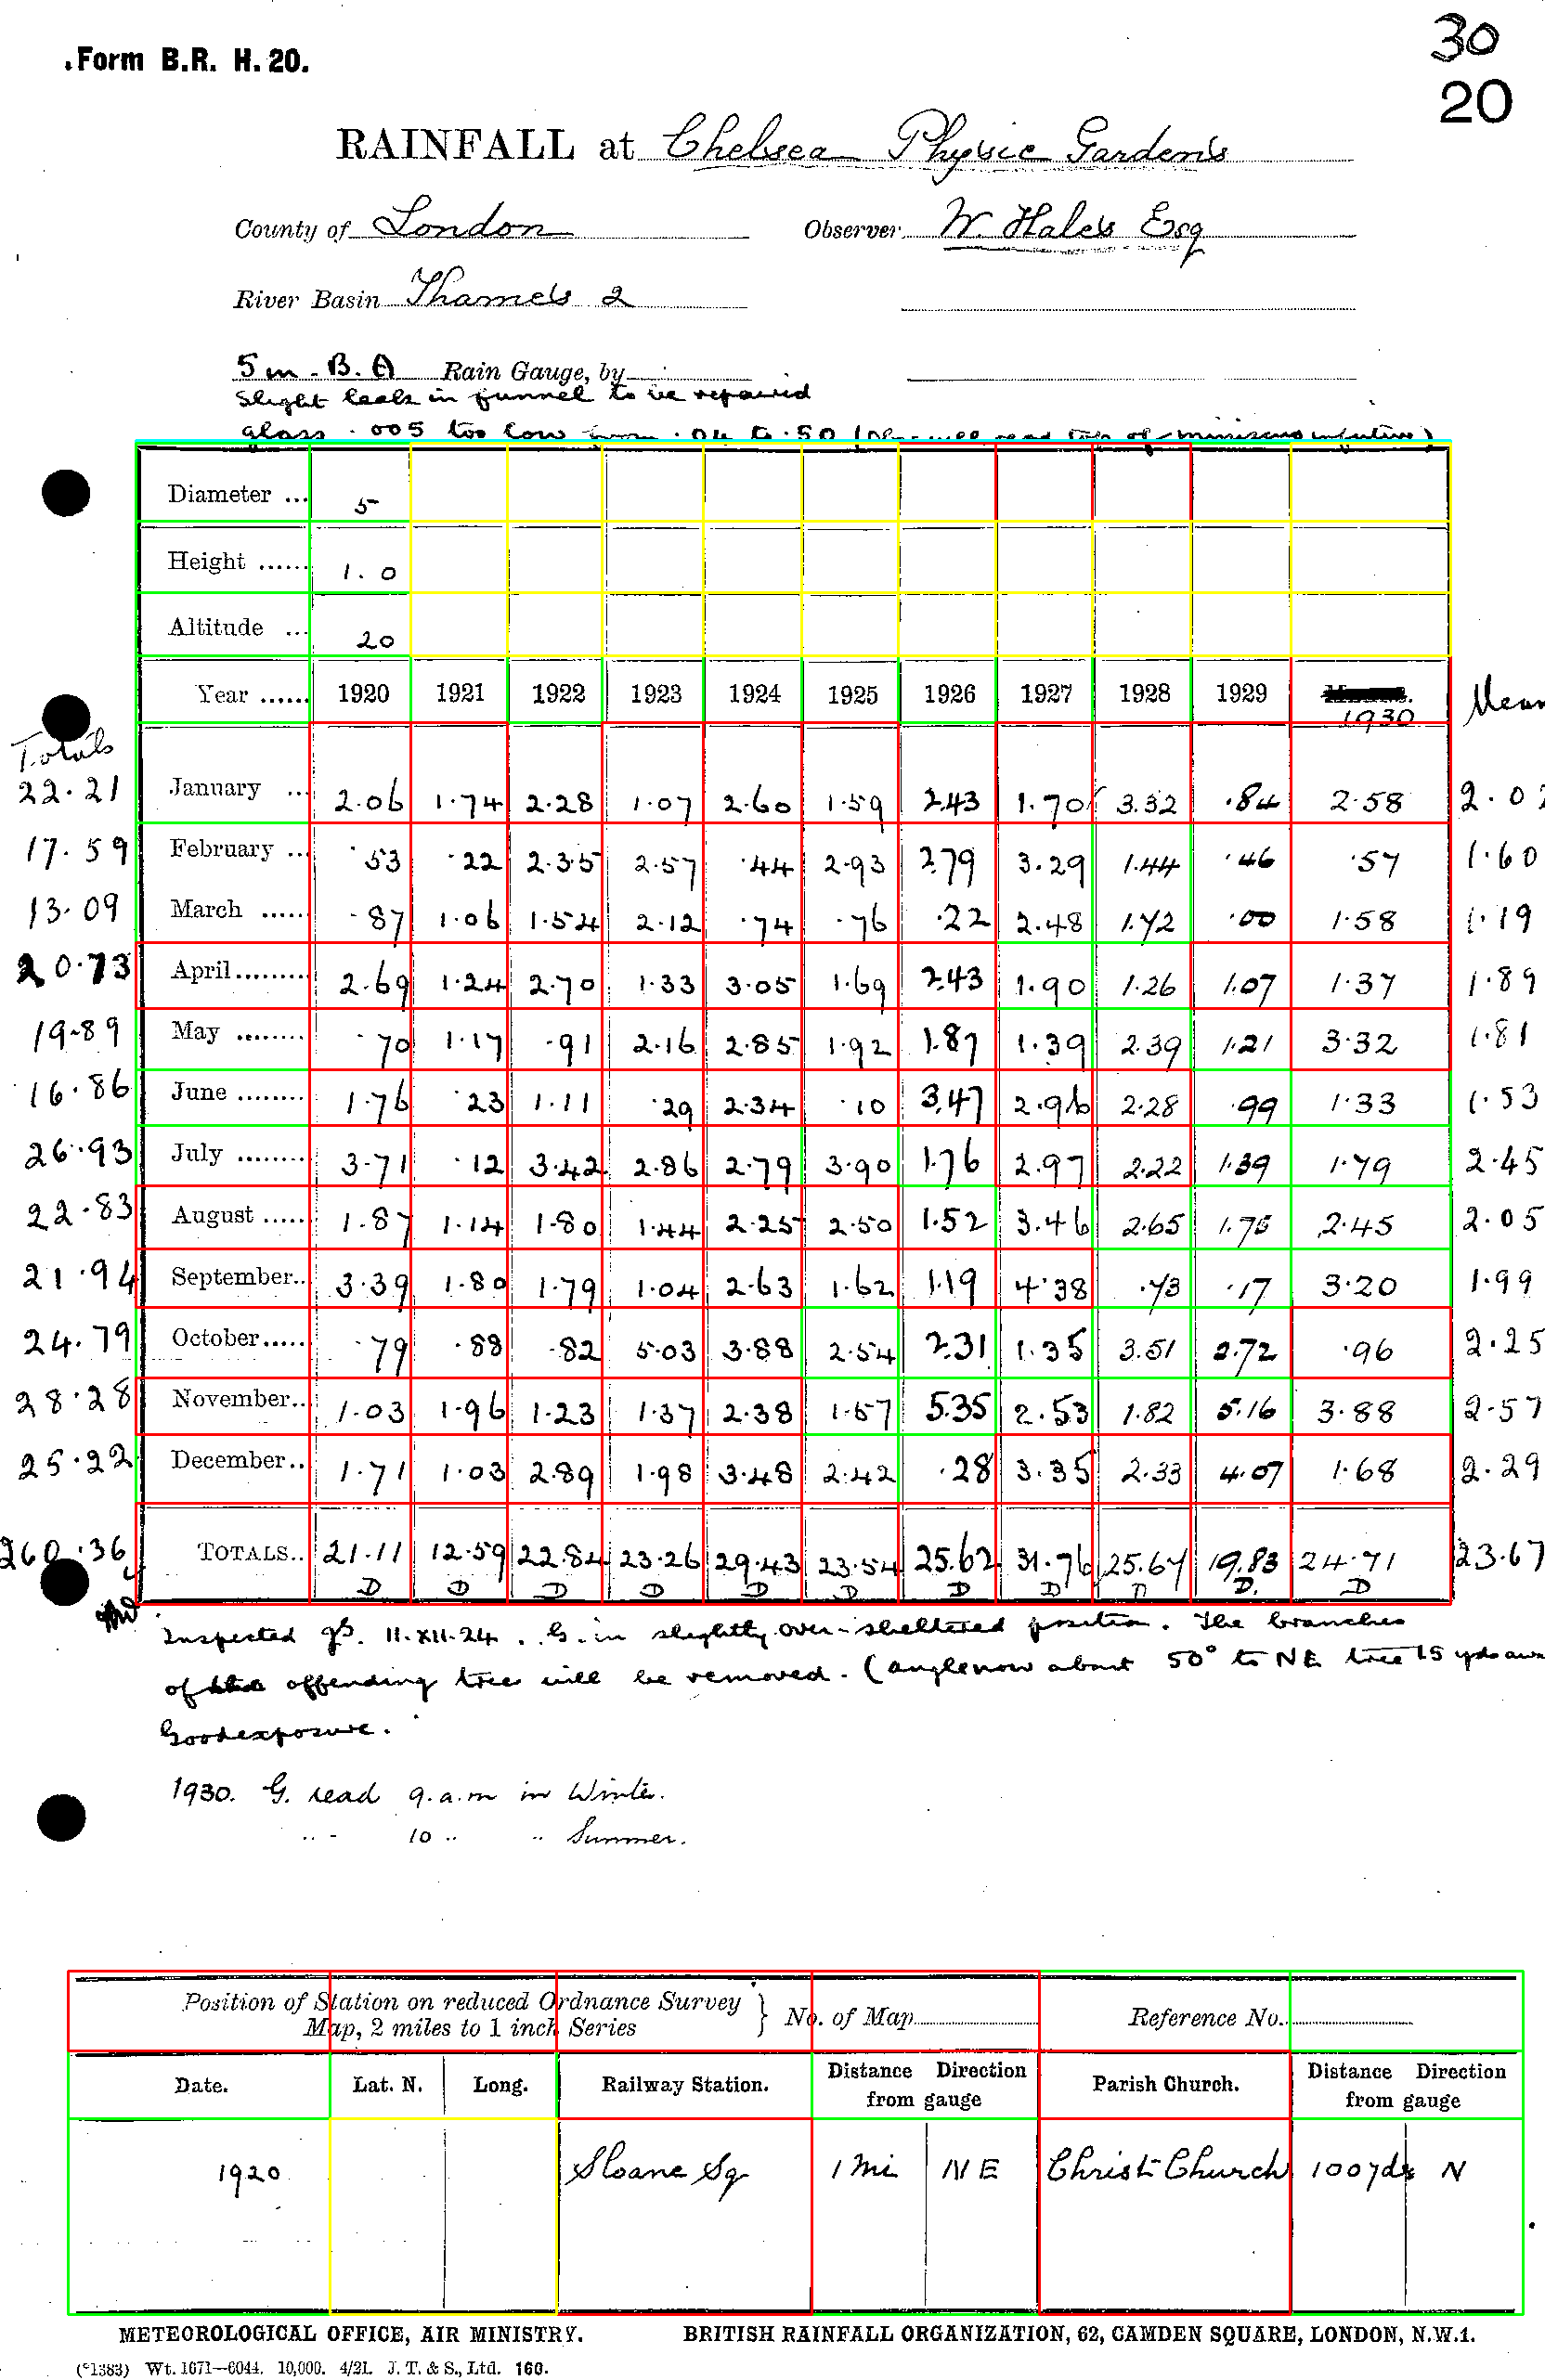

In [55]:
image, height, width, _ = image_preprocessing("temp.jpg")

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in correct_cells:
    put_box(image,box,(0,color,0)) # Green

for box in not_ovellapped_exclude_cells_pred:
    put_box(image,box,(color,0,0)) # Red

for box in not_ovellapped_blank_cells_pred:   
    put_box(image,box,(color,color,0)) # Yellow

im_pil = Image.fromarray(image)
im_pil.save(f"{filename}_temp_cell_classification_overlapped_filtered.jpg")
im_pil  

### Correct single cell error

In [56]:
# check boundary
def correct_boundary_single_cell(imagedraw, mask, table,average_cordinate, pc):
    cell = imagedraw[0:4]
    x_avg, y_avg = average_cordinate
    mask_area = mask[cell[1]:cell[3],cell[0]:cell[2]]
    
    x0,y0,x1,y1 = list(map(int, table))
    new_cell = list(cell)
    changed = [0]*4
        
    # Fix y-axis boundary
    count = 0
    lower = 0
    xc0,yc0,xc1,yc1 = list(map(int, cell))
    for idx, mask_cell in enumerate(mask_area):  # row by row check ascending order
    #     print(len(mask_cell),len(mask_area))
        if not any(mask_cell): # not text region
            count+=1

        elif lower == 0 and count>0:  # check y0
            if count>5:
                new_cell[1]= new_cell[1]+5
            else:
                new_cell[1]= new_cell[1]+count
            changed[1] = 1
            break

        elif float(sum(mask_cell))/len(mask_cell)< 0.2:
            count+=1
            
        elif count == 0:
            break

    count = 0
    lower = 0
    for idx in reversed(range(len(mask_area))):  # row by row check descending order
        mask_cell = mask_area[idx]
    #     print(len(mask_cell),len(mask_area))
        if not any(mask_cell): # not text region
            count+=1

        elif lower == 0 and count>0:  # check y0
            if count>5:
                new_cell[3]= new_cell[3]-5
            else:
                new_cell[3]= new_cell[3]-count
            changed[3] = 1
            break

        elif float(sum(mask_cell))/len(mask_cell)< 0.2:
            count+=1
            
        elif count == 0:
            break

    # Fix x-axis boundary
    count = 0
    lower = 0

    for col_check in range(len(mask_area[0])): # column by column check x0 to xn
        mask_cell = mask_area[:,col_check]
    #     print(len(mask_cell),len(mask_area[0]))
        if not any(mask_cell): # not text region
            count+=1

        elif lower == 0 and count>0:  # check x0
            if count>5:
                new_cell[0]= new_cell[0]+5
            else:
                new_cell[0]= new_cell[0]+count
            changed[0] = 1
            break

        elif float(sum(mask_cell))/len(mask_cell)< 0.2:
            count+=1
            
        elif count == 0:
            break

    count = 0
    lower = 0

    for col_check in reversed(range(len(mask_area[0]))): # column by column check reverse xn to x0
        mask_cell = mask_area[:,col_check]
    #     print(len(mask_cell),len(mask_area[0]))
        if not any(mask_cell): # not text region
            count+=1

        elif lower == 0 and count>0:  # check x0
            if count>5:
                new_cell[2]= new_cell[2]-5
            else:
                new_cell[2]= new_cell[2]-count
            changed[2] = 1
            break

        elif float(sum(mask_cell))/len(mask_cell)< 0.2:
            count+=1

        elif count == 0:
            break

    # if cell is in table border area
    if abs(x0-cell[0])<x_avg*pc:
        new_cell[0] = x0
        changed[0] = 5
    if abs(x1-cell[2])<x_avg*pc:
        new_cell[2] = x1
        changed[2] = 5
    if abs(y0-cell[1])<y_avg*pc:
        new_cell[1] = y0
        changed[1] = 5
    if abs(y1-cell[3])<y_avg*pc:
        new_cell[3] = y1
        changed[3] = 5

    return new_cell, changed

In [57]:
def get_table_coord(cell, tables):
    for idx,table in enumerate(tables):
        table = list(map(int, table))
        print(cell)
        score = tsa.how_much_contained(cell[0:4],table)    
        if score > 0.5:
            return idx, score 
    return [], score

In [58]:
def sort_coord(new_excluded_cells_pred):
    x = torch.IntTensor(new_excluded_cells_pred)
    value, index = x[:,1].sort()

    # value,index
    y_cords = {}
    for idx, i in zip(index,value):
        idx, i = (int(idx),int(i))

        if i not in y_cords:
            y_cords[i]=[]
        y_cords[i].append(idx)
        
    y_cords_new = {}
    for i in y_cords:
        mat = [new_excluded_cells_pred[idx] for idx in y_cords[i]]
        mat = torch.IntTensor(mat)
        _, index = mat[:,0].sort()
    #     print(_, index, mat)

        mat_new = []

        for idx in index:
    #         print(mat[int(idx)])
            cell =  mat[int(idx)].tolist()
            table_idx, score = get_table_coord(cell, tables)
            if score > 0.5:
                mat_new.append(cell[0:4]+[table_idx])  #cells and its table index
        y_cords_new[i]=mat_new
    return y_cords_new

In [59]:
def classify_error_cells(new_excluded_cells_pred, tables, average_cordinates,pc):
    y_cords = sort_coord(new_excluded_cells_pred)

    new_corrected_excluded_cells = []
    not_corrected_excluded_cells = []
    yidx = list(y_cords.keys())
#     print(yidx)
    for yid, y_idx in enumerate(y_cords):
        yneighbours_idx = []
        if yid>0 and yid+1 < len(y_cords):
            yneighbours_idx = [yidx[yid-1],yidx[yid+1]]
        elif yid+1 < len(y_cords):
            yneighbours_idx = [yidx[yid+1]]

    #     print('---',yid, '--',len(y_cords[y_idx]), '--', y_idx, yneighbours_idx,'####')
        xneighbours_idx = []

        for xid, imagedraw in enumerate(y_cords[y_idx]):

            if xid>0 and xid+1 < len(y_cords[y_idx]):
                xneighbours_idx = [yneighbours_idx, [y_cords[y_idx][xid-1],y_cords[y_idx][xid+1]]]

            elif xid+1 < len(y_cords[y_idx]):
                xneighbours_idx = [yneighbours_idx,[y_cords[y_idx][xid+1]]]
            else:
                xneighbours_idx = [yneighbours_idx,[]]

    #         print('x---',xid,'total cells: #',len(y_cords[y_idx]),xneighbours_idx,'###')

            table_idx = imagedraw[-1]

            table = tables[table_idx]
            new_cell, changed = correct_boundary_single_cell(imagedraw, masks[1], table, average_cordinates[table_idx], 1-pc)
            
            x_avg, y_avg = average_cordinates[table_idx]

            if abs(new_cell[0]-new_cell[2])<x_avg*pc or abs(new_cell[1]-new_cell[3])<y_avg*pc:
                not_corrected_excluded_cells.append(new_cell+[0]+[xneighbours_idx]+[changed])
            elif sum(changed)==4 and 5 not in changed:
                new_corrected_excluded_cells.append(new_cell+[1]+[xneighbours_idx]+[changed])
            elif sum(changed)> 5 and 0 not in changed:
                new_corrected_excluded_cells.append(new_cell+[1]+[xneighbours_idx]+[changed])
            else:
                not_corrected_excluded_cells.append(new_cell+[0]+[xneighbours_idx]+[changed])
    
    return new_corrected_excluded_cells, not_corrected_excluded_cells

In [60]:
if len(not_ovellapped_exclude_cells_pred)>2:
    new_corrected_excluded_cells, not_corrected_excluded_cells = classify_error_cells(not_ovellapped_exclude_cells_pred, tables, average_cordinates,0.7)
else:
    new_corrected_excluded_cells = []
    not_corrected_excluded_cells = []

[967, 477, 1072, 561, 1]
[967, 477, 1072, 561, 1]
[1072, 477, 1176, 561, 1]
[1072, 477, 1176, 561, 1]
[1176, 477, 1282, 561, 1]
[1176, 477, 1282, 561, 1]
[1390, 706, 1562, 778, 1]
[1390, 706, 1562, 778, 1]
[333, 778, 442, 886, 1]
[333, 778, 442, 886, 1]
[442, 778, 546, 886, 1]
[442, 778, 546, 886, 1]
[648, 778, 757, 886, 1]
[648, 778, 757, 886, 1]
[757, 778, 863, 886, 1]
[757, 778, 863, 886, 1]
[863, 778, 967, 886, 1]
[863, 778, 967, 886, 1]
[1072, 778, 1176, 886, 1]
[1072, 778, 1176, 886, 1]
[1176, 778, 1282, 886, 1]
[1176, 778, 1282, 886, 1]
[1282, 778, 1390, 886, 1]
[1282, 778, 1390, 886, 1]
[1390, 778, 1562, 886, 1]
[1390, 778, 1562, 886, 1]
[333, 886, 442, 1015, 1]
[333, 886, 442, 1015, 1]
[442, 886, 546, 1015, 1]
[442, 886, 546, 1015, 1]
[546, 886, 648, 1015, 1]
[546, 886, 648, 1015, 1]
[648, 886, 757, 1015, 1]
[648, 886, 757, 1015, 1]
[757, 886, 863, 1015, 1]
[757, 886, 863, 1015, 1]
[863, 886, 967, 1015, 1]
[863, 886, 967, 1015, 1]
[967, 886, 1072, 1015, 1]
[967, 886, 1072, 101

In [61]:
not_ovellapped_exclude_cells_pred

[[1072, 477, 1176, 561, 1],
 [967, 477, 1072, 561, 1],
 [1176, 477, 1282, 561, 1],
 [1390, 706, 1562, 778, 1],
 [863, 778, 967, 886, 1],
 [442, 778, 546, 886, 1],
 [333, 778, 442, 886, 1],
 [757, 778, 863, 886, 1],
 [1176, 778, 1282, 886, 1],
 [648, 778, 757, 886, 1],
 [1390, 778, 1562, 886, 1],
 [1282, 778, 1390, 886, 1],
 [1072, 778, 1176, 886, 1],
 [648, 886, 757, 1015, 1],
 [546, 886, 648, 1015, 1],
 [333, 886, 442, 1015, 1],
 [442, 886, 546, 1015, 1],
 [863, 886, 967, 1015, 1],
 [757, 886, 863, 1015, 1],
 [967, 886, 1072, 1015, 1],
 [1390, 886, 1562, 1015, 1],
 [146, 1015, 333, 1086, 1],
 [1390, 1015, 1562, 1086, 1],
 [1282, 1015, 1390, 1086, 1],
 [648, 1015, 757, 1086, 1],
 [863, 1015, 967, 1086, 1],
 [967, 1015, 1072, 1086, 1],
 [442, 1015, 546, 1086, 1],
 [333, 1015, 442, 1086, 1],
 [546, 1015, 648, 1086, 1],
 [333, 1086, 442, 1152, 1],
 [442, 1086, 546, 1152, 1],
 [757, 1086, 863, 1152, 1],
 [1390, 1086, 1562, 1152, 1],
 [863, 1086, 967, 1152, 1],
 [648, 1086, 757, 1152, 1],
 

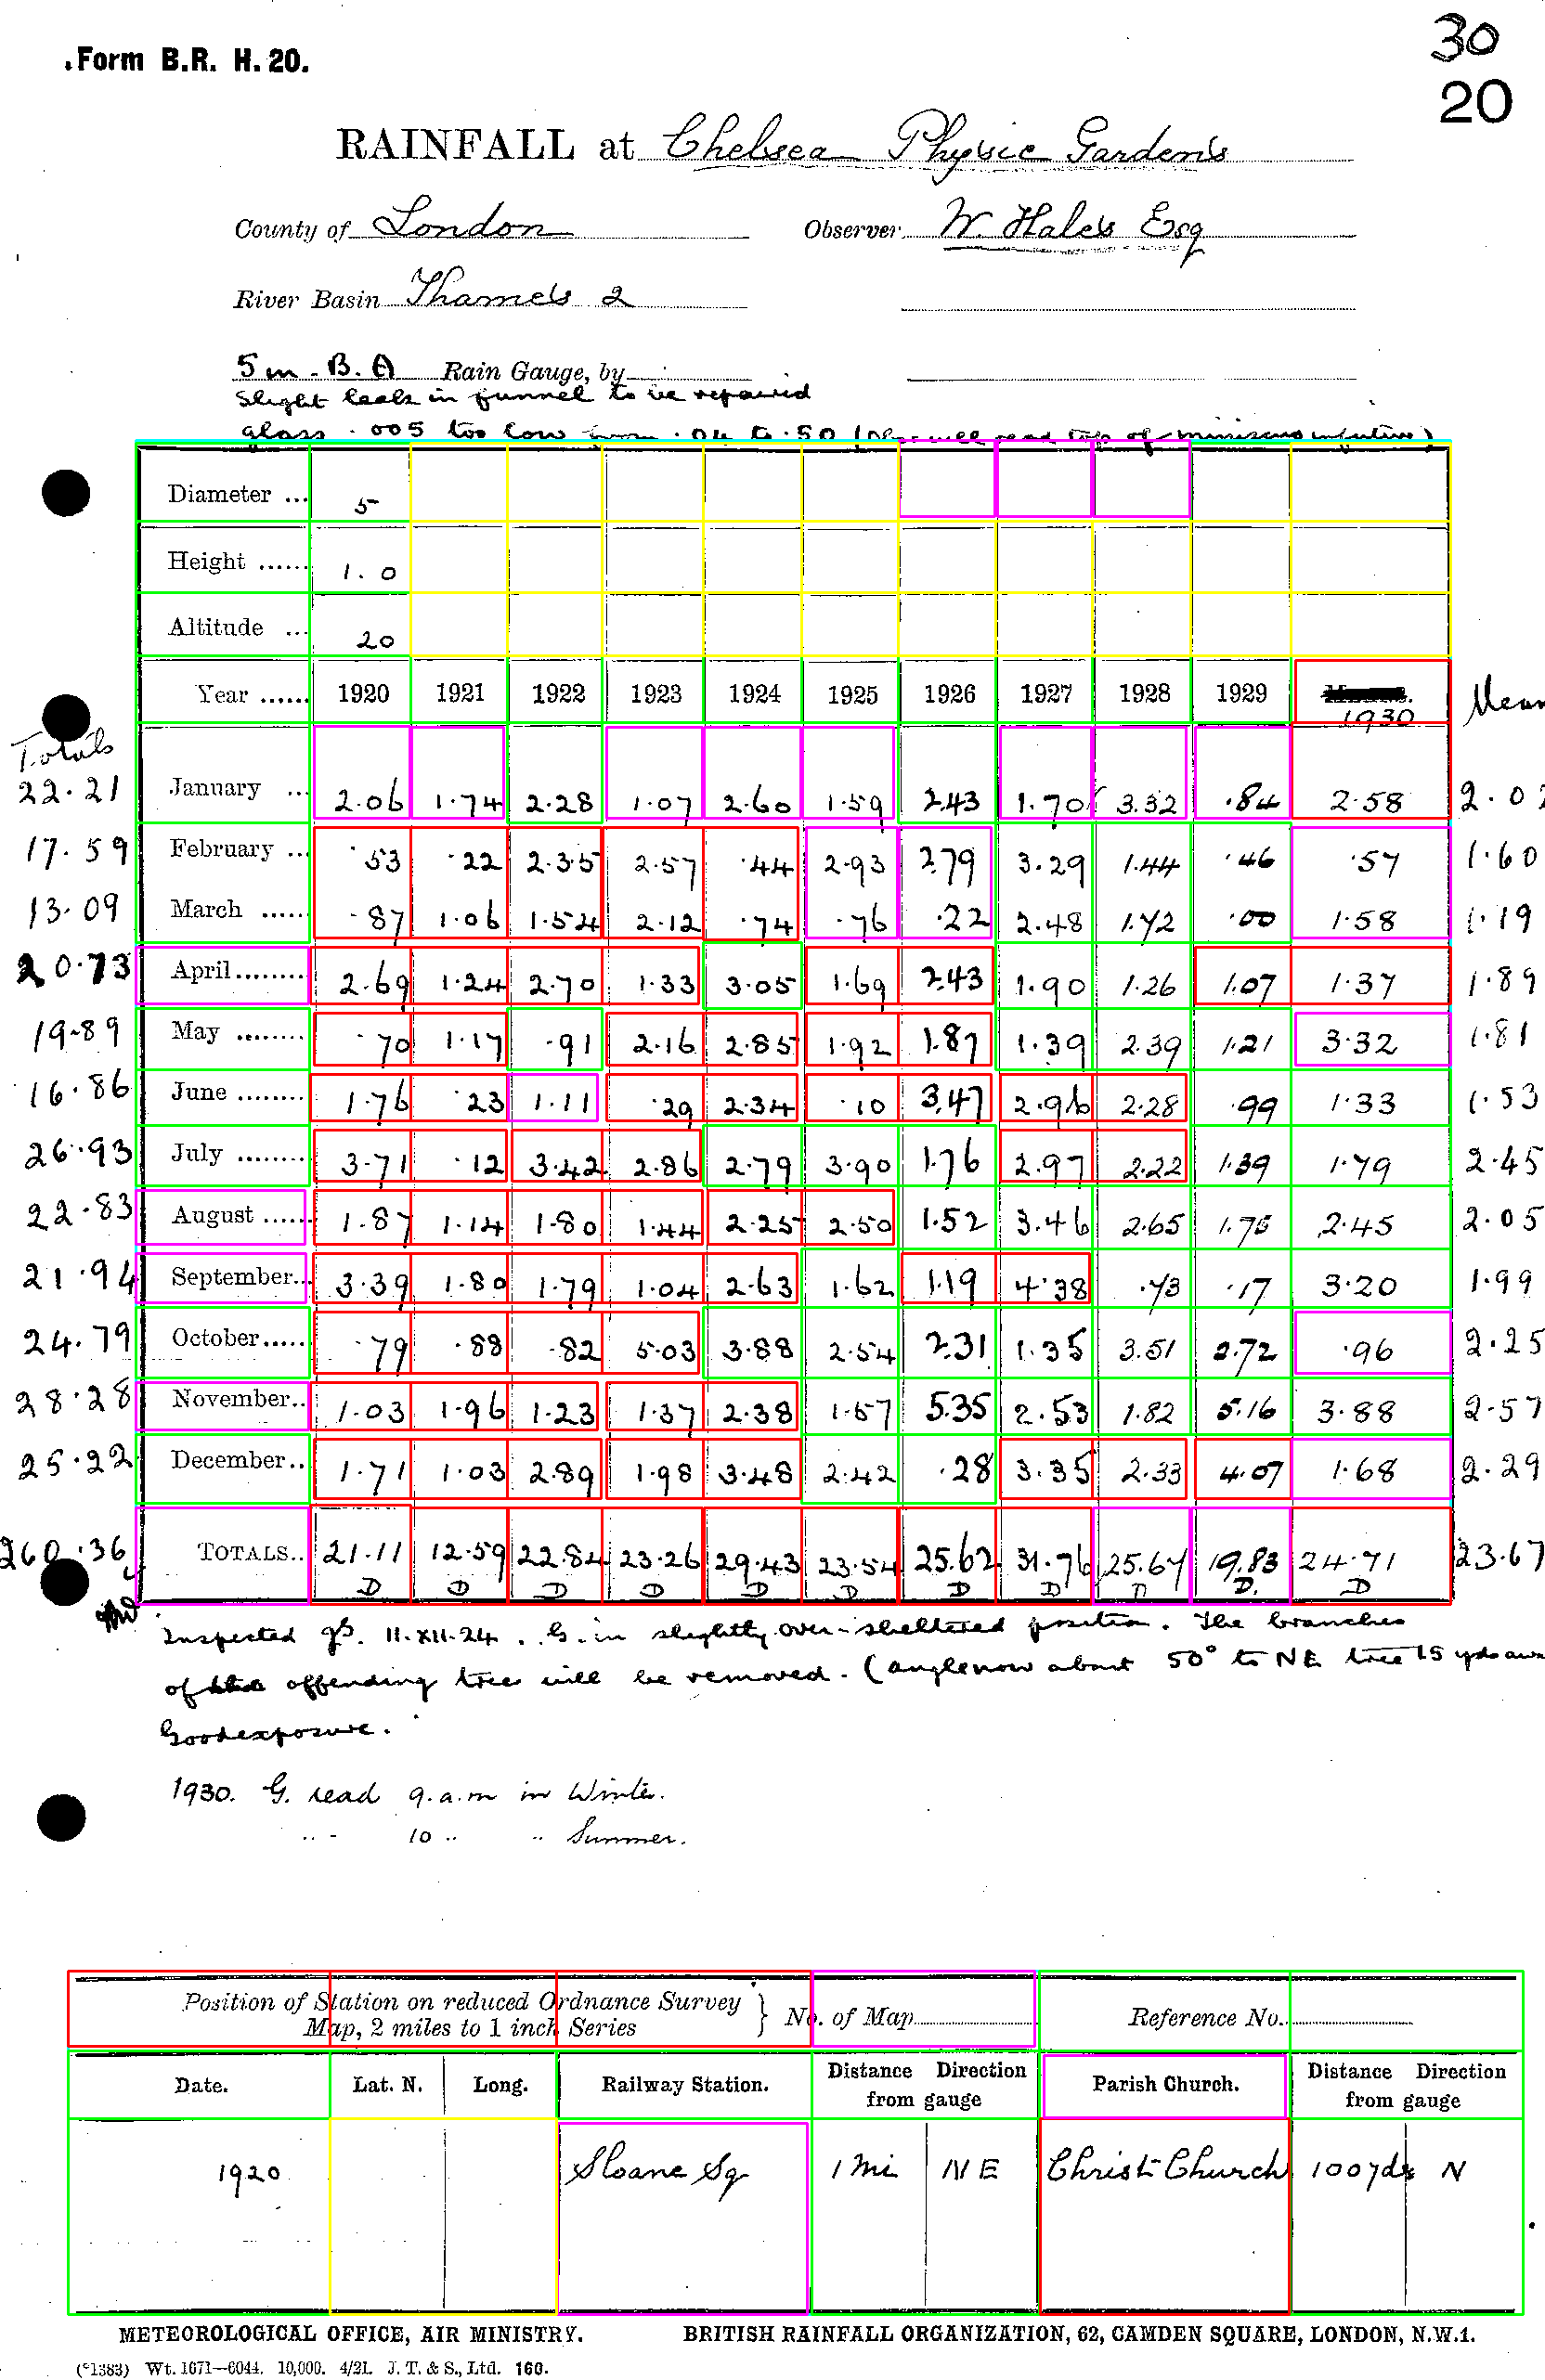

In [62]:
image, height, width, _ = image_preprocessing("temp.jpg")

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in correct_cells:
    put_box(image,box,(0,color,0)) # Green

for box in not_corrected_excluded_cells:
    put_box(image,box,(color,0,0)) # Red

for box in new_corrected_excluded_cells:
#     print(box)
    put_box(image,box,(color,0,color))  # pink
    
for box in not_ovellapped_blank_cells_pred:   
    put_box(image,box,(color,color,0)) # Yellow

im_pil = Image.fromarray(image)
im_pil.save(f"{filename}_temp_cell_classification_single_cell_correction.jpg")
im_pil  

### Generate cells from valid cells

In [63]:
all_valid_cells = ori_correct_cells+correct_cells+not_ovellapped_blank_cells_pred+new_corrected_excluded_cells

In [64]:
table_cells = get_x_y(tables, all_valid_cells)
cell_cordinates, average_cordinates = get_coordinates(table_cells,0.7)

In [65]:
possible_cells, exclude_cells_pred = generate_cells(masks[1], tables, cell_cordinates, average_cordinates)
correct_cells, blank_cells, exclude_cells = classify_cells(possible_cells, masks[1], average_cordinates)  

In [66]:
if len(exclude_cells)>2:
    new_corrected_excluded_cells, not_corrected_excluded_cells = classify_error_cells(exclude_cells, tables, average_cordinates,0.7)
else:
    new_corrected_excluded_cells = []
    not_corrected_excluded_cells = []
    
corrected_cells, corrected_excluded_cells = classify_error_cells(correct_cells, tables, average_cordinates,0.7)

[645, 475, 757, 556, 1]
[645, 475, 757, 556, 1]
[757, 475, 863, 556, 1]
[757, 475, 863, 556, 1]
[863, 475, 964, 556, 1]
[863, 475, 964, 556, 1]
[964, 475, 1069, 556, 1]
[964, 475, 1069, 556, 1]
[1069, 475, 1175, 556, 1]
[1069, 475, 1175, 556, 1]
[1175, 475, 1278, 556, 1]
[1175, 475, 1278, 556, 1]
[1278, 475, 1390, 556, 1]
[1278, 475, 1390, 556, 1]
[146, 637, 329, 706, 1]
[146, 637, 329, 706, 1]
[329, 637, 441, 706, 1]
[329, 637, 441, 706, 1]
[1390, 706, 1562, 778, 1]
[1390, 706, 1562, 778, 1]
[329, 778, 441, 881, 1]
[329, 778, 441, 881, 1]
[441, 778, 544, 881, 1]
[441, 778, 544, 881, 1]
[645, 778, 757, 881, 1]
[645, 778, 757, 881, 1]
[757, 778, 863, 881, 1]
[757, 778, 863, 881, 1]
[863, 778, 964, 881, 1]
[863, 778, 964, 881, 1]
[1069, 778, 1175, 881, 1]
[1069, 778, 1175, 881, 1]
[1175, 778, 1278, 881, 1]
[1175, 778, 1278, 881, 1]
[1278, 778, 1390, 881, 1]
[1278, 778, 1390, 881, 1]
[1390, 778, 1562, 881, 1]
[1390, 778, 1562, 881, 1]
[329, 881, 441, 1010, 1]
[329, 881, 441, 1010, 1]
[441

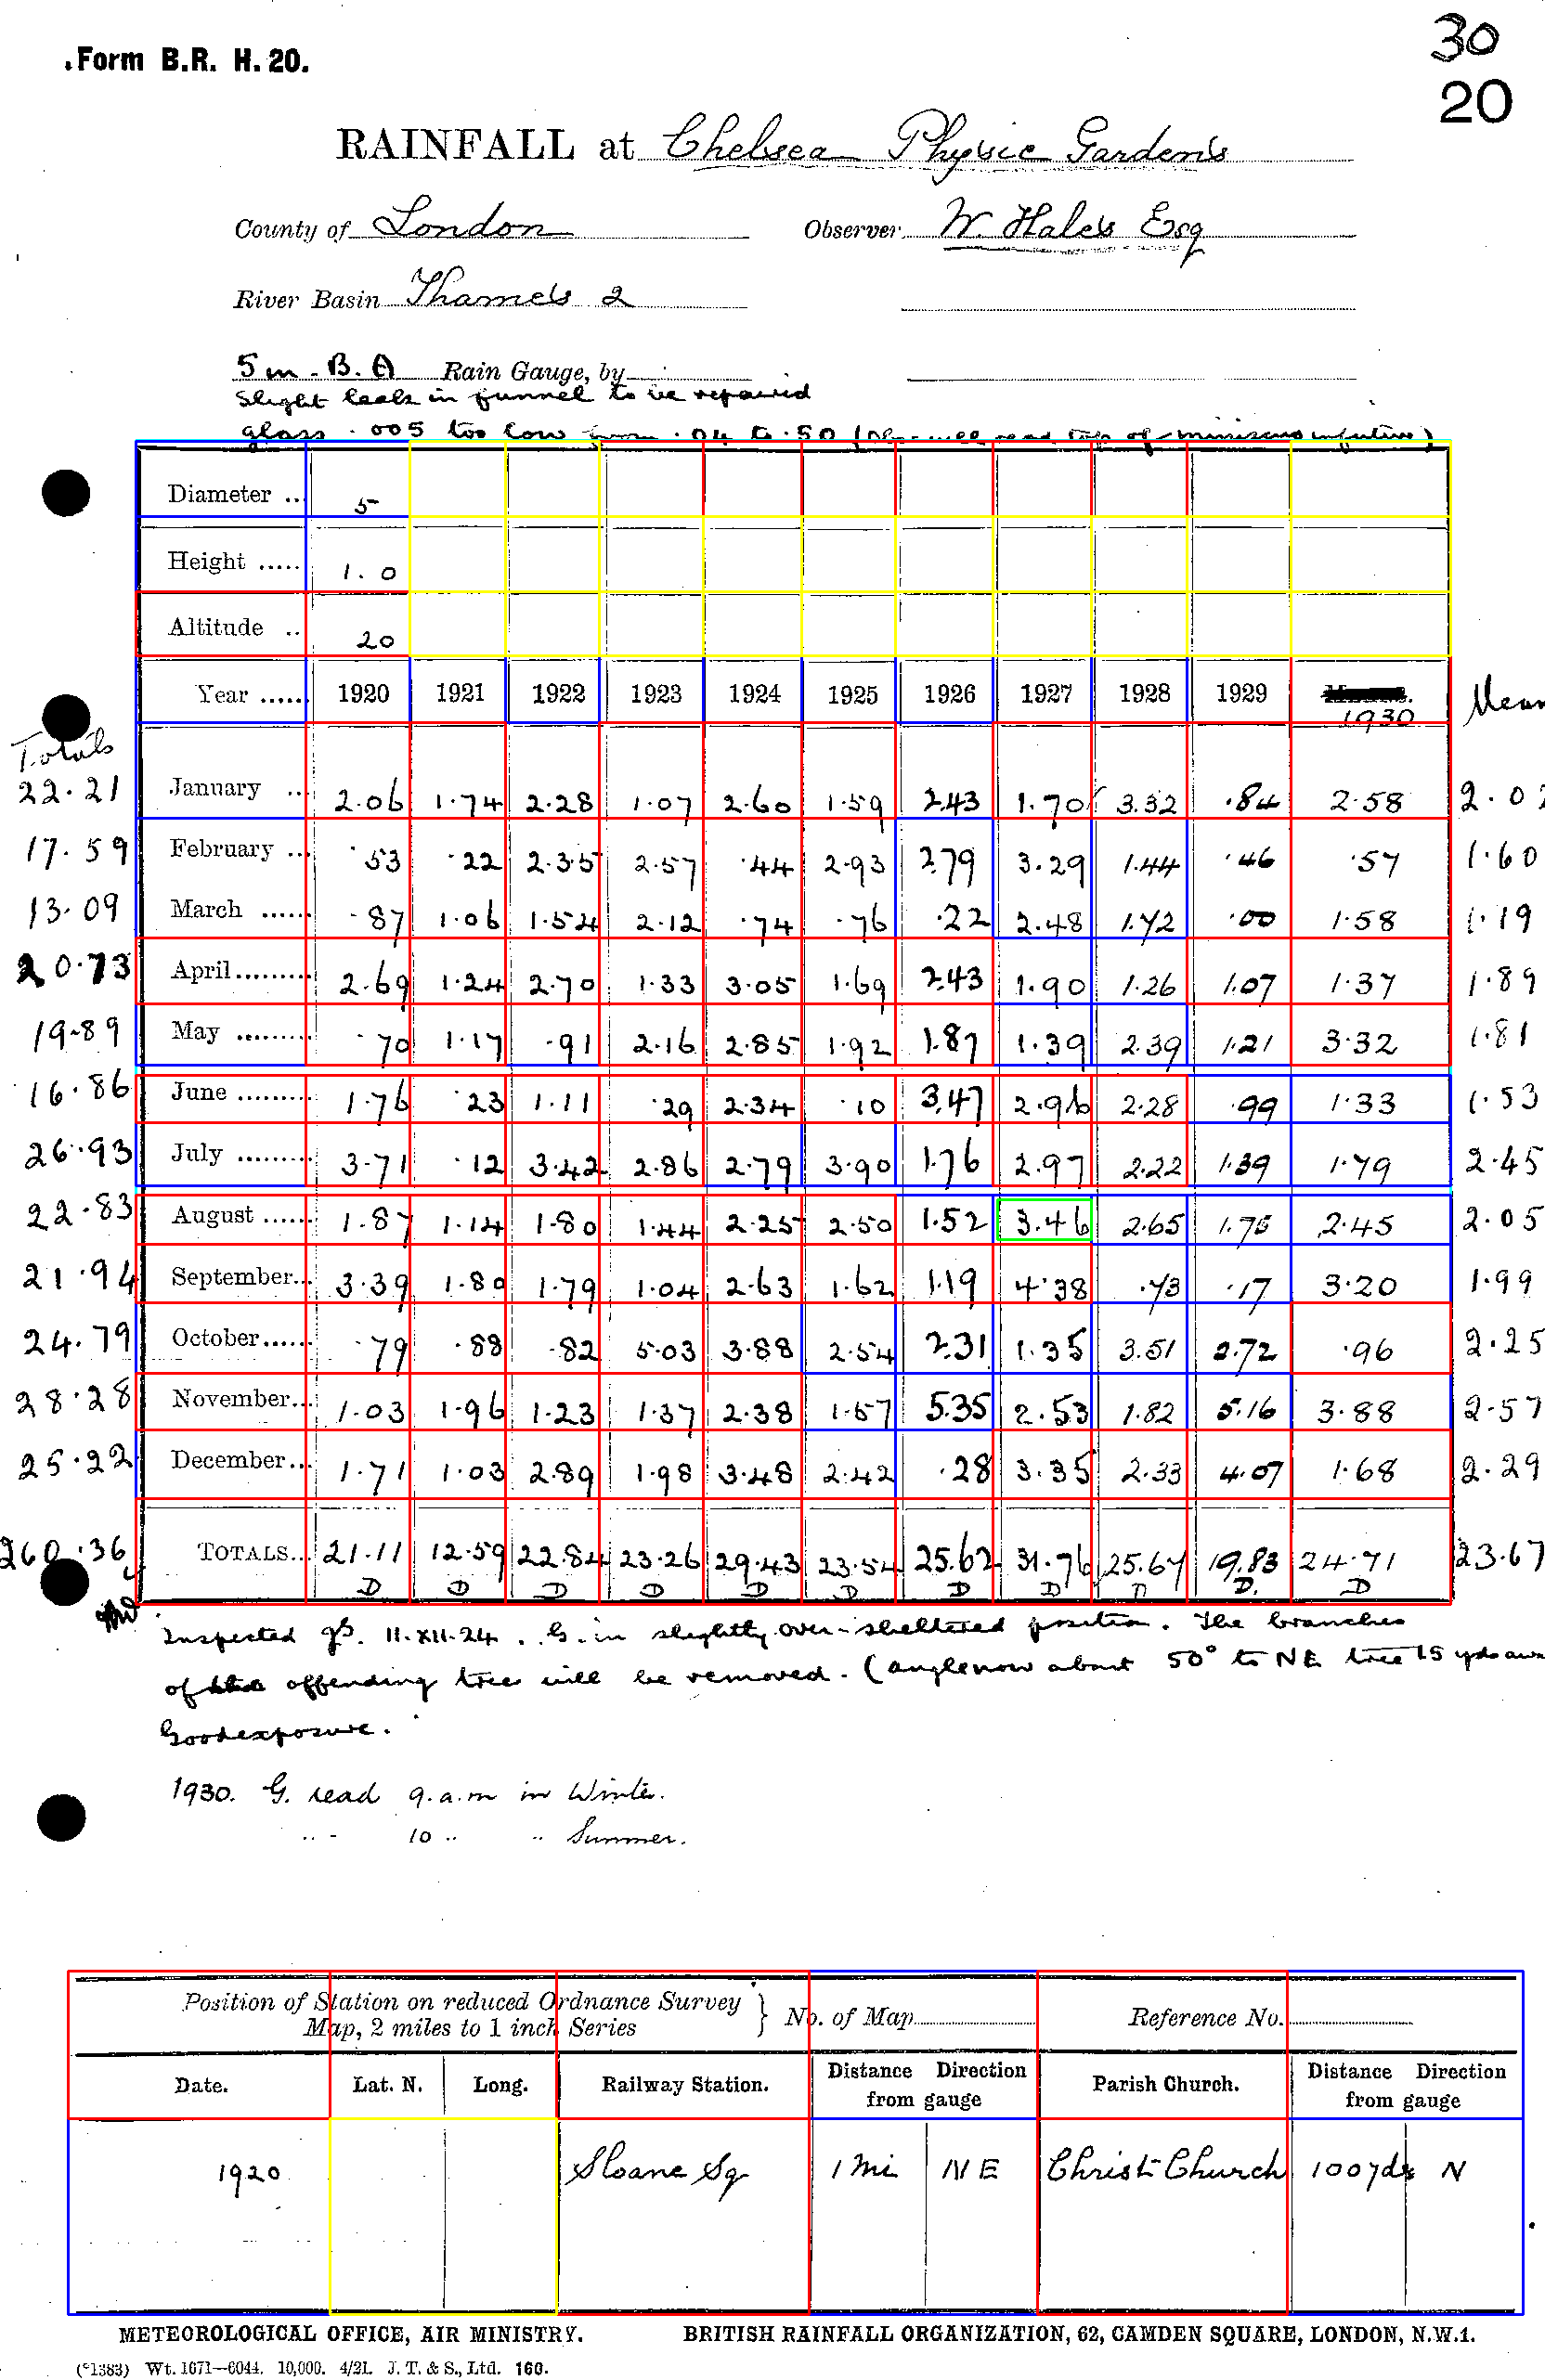

In [67]:
image, height, width, _ = image_preprocessing("temp.jpg")

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in possible_cells:
    put_box(image,box,(0,0,color)) # Blue
    
for box in corrected_excluded_cells:
    put_box(image,box,(0,color,0)) # Green

for box in exclude_cells:
    put_box(image,box,(color,0,0)) # Red
    
# for box in new_corrected_excluded_cells:
# #     print(box)
#     put_box(image,box,(color,0,color))  # pink
    
for box in blank_cells:   
    put_box(image,box,(color,color,0)) # Yellow

im_pil = Image.fromarray(image)
im_pil.save(f"{filename}_temp_cell_generation_from_valid_cells.jpg")
im_pil  

### Correct cell boundary considering multiple cells

In [68]:
def get_neighbouring_coord(cells, tables):
    new_excluded_cells_pred = []
    
    for cell in cells:
        new_excluded_cells_pred.append(cell[0:5])
    
    x = torch.IntTensor(new_excluded_cells_pred)
    value, index = x[:,1].sort()

    # value,index
    y_cords = {}
    for idx, i in zip(index,value):
        idx, i = (int(idx),int(i))

        if i not in y_cords:
            y_cords[i]=[]
        y_cords[i].append(idx)
        
    y_cords_new = {}
    for i in y_cords:
        mat = [new_excluded_cells_pred[idx] for idx in y_cords[i]]
        mat = torch.IntTensor(mat)
        _, index = mat[:,0].sort()
    #     print(_, index, mat)

        mat_new = []

        for idx in index:
    #         print(mat[int(idx)])
            cell =  mat[int(idx)].tolist()
            table_idx, score = get_table_coord(cell, tables)
            if score > 0.5:
                mat_new.append(cell[0:4]+[table_idx])  #cells and its table index
        y_cords_new[i]=mat_new
    return y_cords_new

In [69]:
# sort x and y coordinates of excluded_cells_pred
def get_x_y_neighbour_cells(new_excluded_cells_pred, tables, average_cordinates):
    y_cords = get_neighbouring_coord(new_excluded_cells_pred, tables)
    
    neighbouring_cells = {}
    yidx = list(y_cords.keys())
    
    for yid, y_idx in enumerate(y_cords):
        yneighbours_idx = []
        
        ## can be remove for later filtering
        tid = y_cords[y_idx][0][4]
        avg_x, avg_y = average_cordinates[tid]
        
        yneighbours_idx = []
        if yid>0 and yid+1 < len(y_cords):
            if abs(yidx[yid-1]-y_idx)<avg_y:           
                yneighbours_idx.append(yidx[yid-1]) #= [yidx[yid-1],yidx[yid+1]]
            if abs(yidx[yid+1]-y_idx)<avg_y:           
                yneighbours_idx.append(yidx[yid+1]) 

        elif yid+1 < len(y_cords):
            if abs(yidx[yid+1]-y_idx)<avg_y:           
                yneighbours_idx.append(yidx[yid+1]) #first cell neighbour 
        ### remove if condition if filtering is not required

        xneighbours_idx = []
        if len(y_cords[y_idx])>=1:
            xneighbours_idx = [yneighbours_idx, y_cords[y_idx]]
        else:
            xneighbours_idx = [yneighbours_idx,[]]  # no neighbours

        neighbouring_cells[y_idx]=xneighbours_idx
    
    return neighbouring_cells, y_cords
            

In [70]:
exclude_cells

[[1175, 475, 1278, 556, 1],
 [645, 475, 757, 556, 1],
 [1069, 475, 1175, 556, 1],
 [1278, 475, 1390, 556, 1],
 [757, 475, 863, 556, 1],
 [964, 475, 1069, 556, 1],
 [863, 475, 964, 556, 1],
 [329, 637, 441, 706, 1],
 [146, 637, 329, 706, 1],
 [1390, 706, 1562, 778, 1],
 [757, 778, 863, 881, 1],
 [645, 778, 757, 881, 1],
 [1069, 778, 1175, 881, 1],
 [863, 778, 964, 881, 1],
 [1175, 778, 1278, 881, 1],
 [1390, 778, 1562, 881, 1],
 [1278, 778, 1390, 881, 1],
 [441, 778, 544, 881, 1],
 [329, 778, 441, 881, 1],
 [757, 881, 863, 1010, 1],
 [645, 881, 757, 1010, 1],
 [1390, 881, 1562, 1010, 1],
 [544, 881, 645, 1010, 1],
 [441, 881, 544, 1010, 1],
 [329, 881, 441, 1010, 1],
 [1390, 1010, 1562, 1081, 1],
 [964, 1010, 1069, 1081, 1],
 [146, 1010, 329, 1081, 1],
 [544, 1010, 645, 1081, 1],
 [863, 1010, 964, 1081, 1],
 [1278, 1010, 1390, 1081, 1],
 [441, 1010, 544, 1081, 1],
 [757, 1010, 863, 1081, 1],
 [645, 1010, 757, 1081, 1],
 [329, 1010, 441, 1081, 1],
 [757, 1081, 863, 1147, 1],
 [863, 1081,

In [71]:
x_y_neighbouring_cells_dict = {}
if len(exclude_cells)>2:
    neighbouring_cells, y_cords = get_x_y_neighbour_cells(exclude_cells, tables, average_cordinates)
    
    for yid in neighbouring_cells:
        cells = neighbouring_cells[yid]

        y_neighbours = cells[0]
        x_neighbours = cells[1]

        tid =x_neighbours[0][4]

        avg_x, avg_y = average_cordinates[tid]

        # print(yid,y_neighbours,x_neighbours,tid, average_cordinates[tid])

        # find x_neighbours
        ncells = []
        imagedraw = []
        next_cell_begin = True
        starting_cell = []

        for xid, xcell in enumerate(x_neighbours):    

            # Either split the cell or merge to begining cell
            if next_cell_begin:
                starting_cell = list(xcell)
            else:
                starting_cell[2] = xcell[2]

            # check next cell distance
            if (xid+1)<len(x_neighbours):
                next_cell = x_neighbours[xid+1]
                if abs(next_cell[0]-xcell[2])<(avg_x/3):
                    next_cell_begin = False
                else:
                    ncells.append(starting_cell)
                    starting_cell = []
                    next_cell_begin = True
            elif len(x_neighbours)==1:
                ncells.append(starting_cell)
                starting_cell = []

        if len(starting_cell)>0:
            ncells.append(starting_cell)

    #     print(x_neighbours,'---',ncells)   
        x_y_neighbouring_cells_dict[yid] = (y_neighbours, ncells)

    
    

[645, 475, 757, 556, 1]
[645, 475, 757, 556, 1]
[757, 475, 863, 556, 1]
[757, 475, 863, 556, 1]
[863, 475, 964, 556, 1]
[863, 475, 964, 556, 1]
[964, 475, 1069, 556, 1]
[964, 475, 1069, 556, 1]
[1069, 475, 1175, 556, 1]
[1069, 475, 1175, 556, 1]
[1175, 475, 1278, 556, 1]
[1175, 475, 1278, 556, 1]
[1278, 475, 1390, 556, 1]
[1278, 475, 1390, 556, 1]
[146, 637, 329, 706, 1]
[146, 637, 329, 706, 1]
[329, 637, 441, 706, 1]
[329, 637, 441, 706, 1]
[1390, 706, 1562, 778, 1]
[1390, 706, 1562, 778, 1]
[329, 778, 441, 881, 1]
[329, 778, 441, 881, 1]
[441, 778, 544, 881, 1]
[441, 778, 544, 881, 1]
[645, 778, 757, 881, 1]
[645, 778, 757, 881, 1]
[757, 778, 863, 881, 1]
[757, 778, 863, 881, 1]
[863, 778, 964, 881, 1]
[863, 778, 964, 881, 1]
[1069, 778, 1175, 881, 1]
[1069, 778, 1175, 881, 1]
[1175, 778, 1278, 881, 1]
[1175, 778, 1278, 881, 1]
[1278, 778, 1390, 881, 1]
[1278, 778, 1390, 881, 1]
[1390, 778, 1562, 881, 1]
[1390, 778, 1562, 881, 1]
[329, 881, 441, 1010, 1]
[329, 881, 441, 1010, 1]
[441

In [72]:
x_y_neighbouring_cells_dict

{475: ([], [[645, 475, 1390, 556, 1]]),
 637: ([], [[146, 637, 441, 706, 1]]),
 706: ([], [[1390, 706, 1562, 778, 1]]),
 778: ([],
  [[329, 778, 544, 881, 1],
   [645, 778, 964, 881, 1],
   [1069, 778, 1562, 881, 1]]),
 881: ([], [[329, 881, 863, 1010, 1], [1390, 881, 1562, 1010, 1]]),
 1010: ([], [[146, 1010, 1069, 1081, 1], [1278, 1010, 1562, 1081, 1]]),
 1081: ([],
  [[329, 1081, 544, 1147, 1],
   [645, 1081, 1069, 1147, 1],
   [1390, 1081, 1562, 1147, 1]]),
 1158: ([], [[146, 1158, 1278, 1209, 1]]),
 1209: ([], [[329, 1209, 757, 1277, 1], [1069, 1209, 1278, 1277, 1]]),
 1287: ([], [[146, 1287, 964, 1340, 1]]),
 1340: ([], [[146, 1340, 1175, 1403, 1]]),
 1403: ([], [[329, 1403, 757, 1479, 1], [1390, 1403, 1562, 1479, 1]]),
 1479: ([], [[146, 1479, 863, 1540, 1]]),
 1540: ([], [[329, 1540, 863, 1614, 1], [1069, 1540, 1562, 1614, 1]]),
 1614: ([], [[146, 1614, 1562, 1728, 1]]),
 2123: ([], [[73, 2123, 871, 2282, 0], [1117, 2123, 1386, 2282, 0]]),
 2282: ([], [[599, 2282, 871, 2493, 0]

In [73]:
y_neighbours_new = {}
if len(x_y_neighbouring_cells_dict)>2:
    yids = list(x_y_neighbouring_cells_dict.keys())
    count = 0
    y_neighbours = {}
    cur_list = []

    for i, j in zip(yids[:-1],yids[1:]):
        if count == 0:  # First index
            cur_list.append(i)        
        if (j-i) < avg_y:
            cur_list.append(j)
        else:
            y_neighbours[cur_list[0]] = cur_list
            cur_list = [j]
        count+=1

    if cur_list[0] not in y_neighbours:
        y_neighbours[cur_list[0]] = cur_list

    for yid in y_neighbours:
        for yidn in y_neighbours[yid]:
            y_neighbours_new[yidn] = y_neighbours[yid]
    #         if yidn not in y_neighbours:
    #             print(y_neighbours[yid])

print(y_neighbours_new)

{475: [475], 637: [637, 706, 778, 881], 706: [637, 706, 778, 881], 778: [637, 706, 778, 881], 881: [637, 706, 778, 881], 1010: [1010, 1081, 1158, 1209, 1287, 1340, 1403, 1479, 1540, 1614], 1081: [1010, 1081, 1158, 1209, 1287, 1340, 1403, 1479, 1540, 1614], 1158: [1010, 1081, 1158, 1209, 1287, 1340, 1403, 1479, 1540, 1614], 1209: [1010, 1081, 1158, 1209, 1287, 1340, 1403, 1479, 1540, 1614], 1287: [1010, 1081, 1158, 1209, 1287, 1340, 1403, 1479, 1540, 1614], 1340: [1010, 1081, 1158, 1209, 1287, 1340, 1403, 1479, 1540, 1614], 1403: [1010, 1081, 1158, 1209, 1287, 1340, 1403, 1479, 1540, 1614], 1479: [1010, 1081, 1158, 1209, 1287, 1340, 1403, 1479, 1540, 1614], 1540: [1010, 1081, 1158, 1209, 1287, 1340, 1403, 1479, 1540, 1614], 1614: [1010, 1081, 1158, 1209, 1287, 1340, 1403, 1479, 1540, 1614], 2123: [2123], 2282: [2282]}


In [74]:
def correct_boundary_neighbour(image, cell, tables, step_x, step_y):
    croppedimage_full=image[int(cell[1]):int(cell[3]),int(cell[0]):int(cell[2])]  
    plt.rcParams["figure.figsize"] = (10,5)
    plt.imshow(croppedimage_full)
    plt.title(f'Input image')
    plt.show()
    
    anchor = list(cell)
    notfound = True
    count = 0 
    step_x0 = 0 
    step_x1 = 0
    step_y0 = 0
    step_y1 = 0
    changed = [1,1,1,1]
    
    while notfound:
        
        if anchor[0]<anchor[2] and anchor[1]< anchor[3]:
            new_corrected, not_corrected = classify_error_cells([anchor], tables, average_cordinates,0.7) # correct single error cell or declare error
        else:
            return []
#         print(anchor, new_corrected, not_corrected)
        if len(new_corrected)>0:
            count+=1
            
            anchor[0]+=step_x0
            anchor[1]+=step_y0
            anchor[2]+=step_x1
            anchor[3]+=step_y1
            
            if count>0:
                notfound = False
        elif len(not_corrected)>0:
            
            changed = not_corrected[0][6]   
            if 0 not in changed: 
                notfound = False
            else:
                if changed[0]==0:
                    step_x0+=step_x
                    anchor[0]+=step_x0
                if changed[1]==0:
                    step_y0+=step_y
                    anchor[1]+=step_y0
                if changed[2]==0:
                    step_x1+=step_x
                    anchor[2]+=step_x1
                if changed[3]==0:
                    step_y1+=step_y
                    anchor[3]+=step_y1           
    
    cur_corrected = list(anchor)
    return cur_corrected

def find_proper_cell(cell, avg_x, avg_y):
    if abs(cell[0]-cell[2])>(avg_x*2)/3 and abs(cell[1]-cell[3])>(avg_y*2)/3 :
        return True
    else:
        return False
    
def correct_boundary_multiple_cell(image, cell, n_cell, above, average_cordinates, tables):
    
    tid = cell[4]
    avg_x, avg_y = average_cordinates[tid]
    tab_boundary = list(map(int, tables[tid]))
    
    step_x = int(avg_x*0.025)
    step_y = int(avg_y*0.025)
    
    if find_proper_cell(cell, avg_x, avg_y):
        cur_corrected = correct_boundary_neighbour(image, cell, tables, step_x, step_y)
        if len(cur_corrected) == 0:
            cur_corrected = cell
    else:
        cur_corrected = cell
#     croppedimage_full=image[int(cur_corrected[1]):int(cur_corrected[3]),int(cur_corrected[0]):int(cur_corrected[2])]  
#     plt.rcParams["figure.figsize"] = (10,5)
#     plt.imshow(croppedimage_full)
#     plt.title(f'try cell images')
#     plt.show()

    anchor = list(n_cell) ## neighbour update check
    if len(cur_corrected)>1:
        if above: # check cell by crossing boundary of above cell i.e. decrease y0 and y1
            anchor[3] = cur_corrected[1]
            anchor[0] = cur_corrected[0]

        else: # increase y0 and y1 by avg_y*0.05 (5%) cell size
            anchor[1] = cur_corrected[3]
            anchor[0] = cur_corrected[0]

    if find_proper_cell(anchor, avg_x, avg_y):
        n_cur_corrected = correct_boundary_neighbour(image, anchor, tables, step_x, step_y)
        if len(n_cur_corrected) == 0:
            n_cur_corrected = anchor
    else:
        n_cur_corrected = anchor
#     croppedimage_full=image[int(n_cur_corrected[1]):int(n_cur_corrected[3]),int(n_cur_corrected[0]):int(n_cur_corrected[2])]  
#     plt.rcParams["figure.figsize"] = (10,5)
#     plt.imshow(croppedimage_full)
#     plt.title(f'try cell images')
#     plt.show()
    
    return cur_corrected, n_cur_corrected

In [75]:
# combine x and y neighbours v2

error_corrected_cells = []
not_corrected_cells = []

if len(x_y_neighbouring_cells_dict)>2:
    for yid in x_y_neighbouring_cells_dict:
    #     print(yid)
        ynid, xnid = x_y_neighbouring_cells_dict[yid]

        if len(ynid) == 0: 
            new_corrected, not_corrected = classify_error_cells(xnid, tables, average_cordinates,0.7) # correct single error cell or declare error

            if len(not_corrected)==0:
                error_corrected_cells+=new_corrected
            else:
                for cell in not_corrected:                
                    tid = cell[4]
                    avg_x, avg_y = average_cordinates[tid]
                    tab_boundary = list(map(int, tables[tid]))

                    move = cell[6]

                    for idx,i in enumerate(move):
                        if i == 0:
                            if abs(cell[idx]-tab_boundary[idx])<avg_y/3:
                                cell[idx] = tab_boundary[idx]
                                move[idx] = 5

                    if 0 in move:
                        not_corrected_cells+=not_corrected

                    else:
                        cell[6] =  move
                        error_corrected_cells+=[cell]
    #                     print(cell, imagedraw[idx],tab_boundary[idx], avg_y/3, abs(cell[idx]-tab_boundary[idx]))

        elif len(xnid)>0: #multiple neighbours
    #         print(ynid, yid)
            above_cells = []
            cur_cells = []
            below_cells = []
            for y_n in ynid:
                if y_n < yid:
    #                 print(y_n, yid)
                    above_cells = x_y_neighbouring_cells_dict[y_n][1]
                else:
                    cur_cells = xnid

                    below_cells = x_y_neighbouring_cells_dict[y_n][1]
            print(f'============{yid}================== \nAbove cells:{above_cells} \nCurrent cells: {xnid} \nBelow cells: {below_cells}')

            for cell in xnid:
                anchor = list(cell)      

                tid = cell[4]
                avg_x, avg_y = average_cordinates[tid]
                tab_boundary = list(map(int, tables[tid]))

                #check above first:
                for a_cell in above_cells:
                    anchor_a = list(a_cell)
                    anchor_a[1] = anchor[1] # change the y-coordinates to see overlapping or not and if overlapped the cell is immediate neighbour
                    anchor_a[3] = anchor[3]
                    score1 = tsa.how_much_contained(anchor_a, cell)
                    score2 = tsa.how_much_contained(cell,anchor_a)

                    if score1>0.5:


                        if a_cell[0] < cell[0]:  ## check if a_cell[0] >= cell[0] and change a_cell[0] to cell[0] and a_cell[2] to cell[2] for correction

                            print(f'1--{yid} just above cell: {a_cell}, Current cell: {cell}, {anchor_a}, {score1}')
                            above = True
                            cur_corrected, n_cur_corrected = correct_boundary_multiple_cell(image, cell, a_cell, above, average_cordinates, tables)
                            error_corrected_cells.append(cur_corrected)

                            merged_cell = list(cell)
                            merged_cell[1] = a_cell[1]

                            croppedimage_full=image[int(merged_cell[1]):int(merged_cell[3]),int(merged_cell[0]):int(merged_cell[2])] 
                            plt.rcParams["figure.figsize"] = (10,5)
                            plt.imshow(croppedimage_full)
                            plt.title(f'{yid} merged cell of {len(y_cords[yid])} #images')
                            plt.show()

                            croppedimage_full=image[int(cur_corrected[1]):int(cur_corrected[3]),int(cur_corrected[0]):int(cur_corrected[2])]  
                            plt.rcParams["figure.figsize"] = (10,5)
                            plt.imshow(croppedimage_full)
                            plt.title(f'current cell images')
                            plt.show()


                            croppedimage_full=image[int(n_cur_corrected[1]):int(n_cur_corrected[3]),int(n_cur_corrected[0]):int(n_cur_corrected[2])]  
                            plt.rcParams["figure.figsize"] = (10,5)
                            plt.imshow(croppedimage_full)
                            plt.title(f'neighbour cell images')
                            plt.show()


    #                         new_cells = predict_cells(cell, a_cell, above=True, masks[1], tab_boundary, avg_x, avg_y)
    #                         for n_cell(imagedraw) in new_cells:
    #                             classify_error_cells(n_cell, tables)
    #                             new_cell, changed = correct_boundary_single_cell(imagedraw, masks[1], table)

    #                             if sum(changed)==4 and 5 not in changed:
    #                                 new_corrected_excluded_cells.append(new_cell+[table_idx]+[xneighbours_idx]+[changed])
    #                             elif 0 not in changed:
    #                                 new_corrected_excluded_cells.append(new_cell+[table_idx]+[xneighbours_idx]+[changed])
    #                             else:
    #                                 not_corrected_excluded_cells.append(new_cell+[table_idx]+[xneighbours_idx]+[changed])


                            print('-----Above-----\n')
    #                         pass

                        else:                            
                            pass ##wrong issue

    #                         croppedimage_full=image[int(a_cell[1]):int(a_cell[3]),int(a_cell[0]):int(a_cell[2])]  ## check if a_cell[0] >= cell[0] and change a_cell[0] to cell[0] and a_cell[2] to cell[2] for correction
    #                         plt.rcParams["figure.figsize"] = (10,5)
    #                         plt.imshow(croppedimage_full)
    #                         plt.title(f'Issue with above cell image')
    #                         plt.show()

    #                         croppedimage_full=image[int(cell[1]):int(cell[3]),int(cell[0]):int(cell[2])]
    #                         plt.rcParams["figure.figsize"] = (10,5)
    #                         plt.imshow(croppedimage_full)
    #                         plt.title(f'Current cell image')
    #                         plt.show()


                #check below cell:
                for b_cell in below_cells:
                    anchor_b = list(b_cell)
                    anchor_b[1] = anchor[1] # change the y-coordinates to see overlapping or not and if overlapped the cell is immediate neighbour
                    anchor_b[3] = anchor[3]
                    score1 = tsa.how_much_contained(cell,anchor_b)
                    score2 = tsa.how_much_contained(anchor_b, cell)

                    if score1>0.5:

                        if b_cell[0] < cell[0]: ##check if b_cell[0] >= cell[0] and change b_cell[0] to cell[0] and b_cell[2] to cell[2] for correction

                            above = False
                            cur_corrected, n_cur_corrected = correct_boundary_multiple_cell(image, cell, b_cell, above, average_cordinates, tables)
                            error_corrected_cells.append(cur_corrected)
                            print(f'2--{yid} just below cell: {b_cell}, Current cell: {cell}, {anchor_b} {score1}')

                            merged_cell = list(cell)
                            merged_cell[3] = b_cell[3]

                            croppedimage_full=image[int(merged_cell[1]):int(merged_cell[3]),int(merged_cell[0]):int(merged_cell[2])]  
                            plt.rcParams["figure.figsize"] = (10,5)
                            plt.imshow(croppedimage_full)
                            plt.title(f'{yid} merged cell of {len(y_cords[yid])} #images')
                            plt.show()

                            croppedimage_full=image[int(cur_corrected[1]):int(cur_corrected[3]),int(cur_corrected[0]):int(cur_corrected[2])]  
                            plt.rcParams["figure.figsize"] = (10,5)
                            plt.imshow(croppedimage_full)
                            plt.title(f'current cell images')
                            plt.show()


                            croppedimage_full=image[int(n_cur_corrected[1]):int(n_cur_corrected[3]),int(n_cur_corrected[0]):int(n_cur_corrected[2])]  
                            plt.rcParams["figure.figsize"] = (10,5)
                            plt.imshow(croppedimage_full)
                            plt.title(f'neighbour cell images')
                            plt.show()

                            print('-----Below-----\n')
    #                         pass

                        else:                        
                            pass ##wrong issue

    #                         croppedimage_full=image[int(cell[1]):int(cell[3]),int(cell[0]):int(cell[2])]
    #                         plt.rcParams["figure.figsize"] = (10,5)
    #                         plt.imshow(croppedimage_full)
    #                         plt.title(f'Current cell image')
    #                         plt.show()

    #                         croppedimage_full=image[int(b_cell[1]):int(b_cell[3]),int(b_cell[0]):int(b_cell[2])]  ##check if b_cell[0] >= cell[0] and change b_cell[0] to cell[0] and b_cell[2] to cell[2] for correction
    #                         plt.rcParams["figure.figsize"] = (10,5)
    #                         plt.imshow(croppedimage_full)
    #                         plt.title(f'Issue with below cell image')
    #                         plt.show()

    #         print(f'\n')

    #         for imagedraw in xnid:                    
    #             croppedimage_full=image[int(imagedraw[1]):int(imagedraw[3]),int(imagedraw[0]):int(imagedraw[2])]
    #             plt.rcParams["figure.figsize"] = (10,5)
    #             plt.imshow(croppedimage_full)
    #             plt.title(f'Wrong image')
    #             plt.show()

        

[645, 475, 1390, 556, 1]
[645, 475, 1390, 556, 1]
[146, 637, 441, 706, 1]
[146, 637, 441, 706, 1]
[1390, 706, 1562, 778, 1]
[1390, 706, 1562, 778, 1]
[329, 778, 544, 881, 1]
[329, 778, 544, 881, 1]
[645, 778, 964, 881, 1]
[645, 778, 964, 881, 1]
[1069, 778, 1562, 881, 1]
[1069, 778, 1562, 881, 1]
[329, 881, 863, 1010, 1]
[329, 881, 863, 1010, 1]
[1390, 881, 1562, 1010, 1]
[1390, 881, 1562, 1010, 1]
[146, 1010, 1069, 1081, 1]
[146, 1010, 1069, 1081, 1]
[1278, 1010, 1562, 1081, 1]
[1278, 1010, 1562, 1081, 1]
[329, 1081, 544, 1147, 1]
[329, 1081, 544, 1147, 1]
[645, 1081, 1069, 1147, 1]
[645, 1081, 1069, 1147, 1]
[1390, 1081, 1562, 1147, 1]
[1390, 1081, 1562, 1147, 1]
[146, 1158, 1278, 1209, 1]
[146, 1158, 1278, 1209, 1]
[329, 1209, 757, 1277, 1]
[329, 1209, 757, 1277, 1]
[1069, 1209, 1278, 1277, 1]
[1069, 1209, 1278, 1277, 1]
[146, 1287, 964, 1340, 1]
[146, 1287, 964, 1340, 1]
[146, 1340, 1175, 1403, 1]
[146, 1340, 1175, 1403, 1]
[329, 1403, 757, 1479, 1]
[329, 1403, 757, 1479, 1]
[1390,

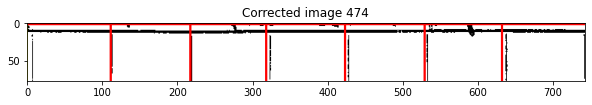

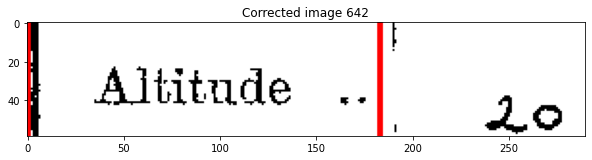

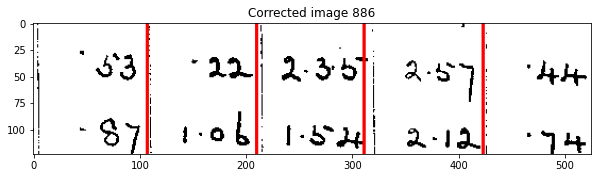

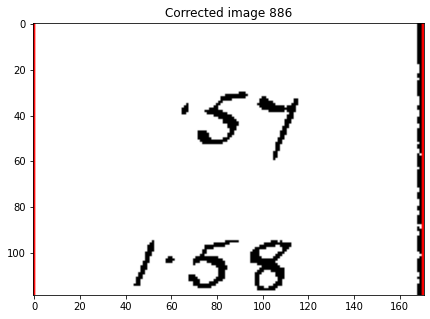

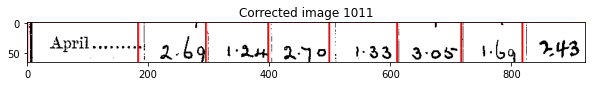

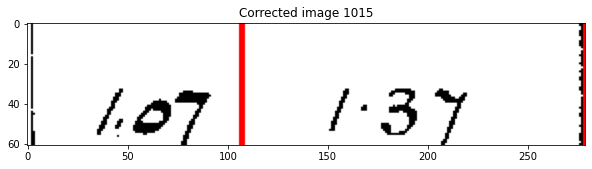

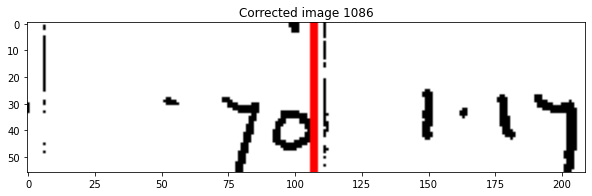

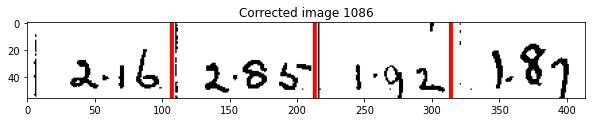

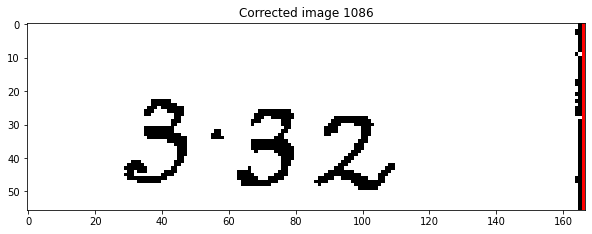

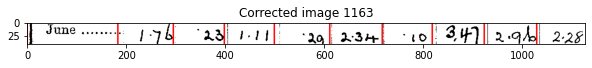

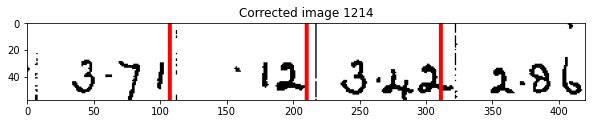

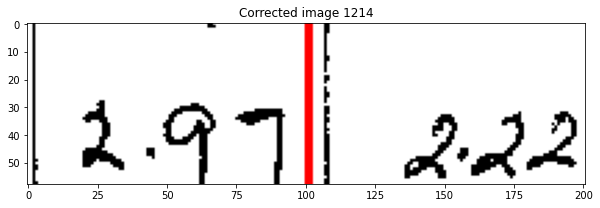

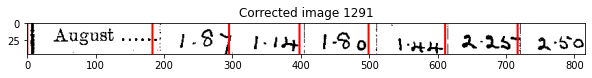

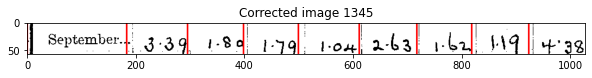

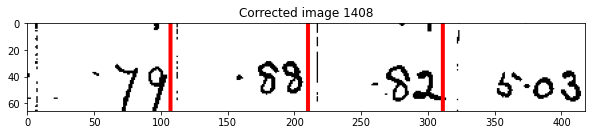

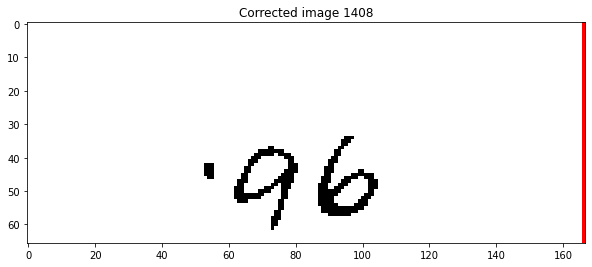

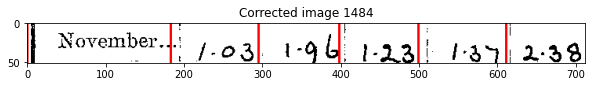

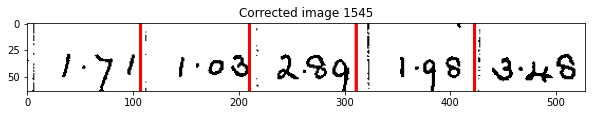

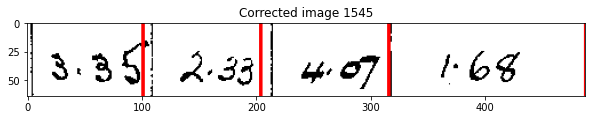

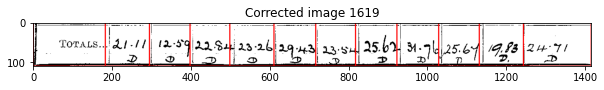

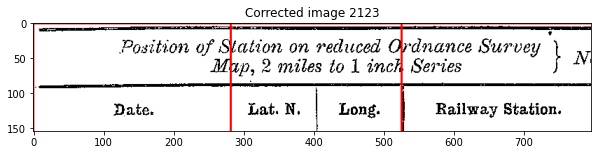

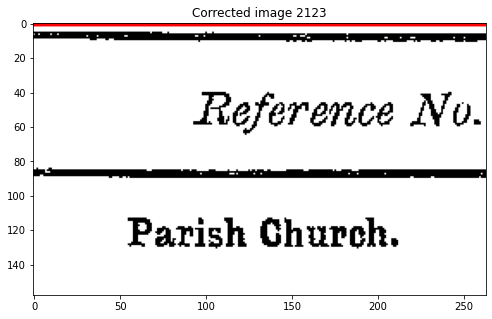

In [76]:
for imagedraw in error_corrected_cells:
    croppedimage_full=image[int(imagedraw[1]):int(imagedraw[3]),int(imagedraw[0]):int(imagedraw[2])]
    plt.rcParams["figure.figsize"] = (10,5)
    plt.imshow(croppedimage_full)
    plt.title(f'Corrected image {imagedraw[1]}')
    plt.show()

In [77]:
new_corrected_excluded_cells = []
not_corrected_excluded_cells = []

if len(error_corrected_cells)>0:
    not_overlap_error_cells =  find_overlapped_cell(error_corrected_cells, exclude_cells)
    new_corrected_excluded_cells, not_corrected_excluded_cells = classify_error_cells(not_overlap_error_cells, tables, average_cordinates,0.7)

[1390, 706, 1562, 778, 1]
[1390, 706, 1562, 778, 1]
[329, 778, 441, 881, 1]
[329, 778, 441, 881, 1]
[441, 778, 544, 881, 1]
[441, 778, 544, 881, 1]
[645, 778, 757, 881, 1]
[645, 778, 757, 881, 1]
[757, 778, 863, 881, 1]
[757, 778, 863, 881, 1]
[863, 778, 964, 881, 1]
[863, 778, 964, 881, 1]
[1069, 778, 1175, 881, 1]
[1069, 778, 1175, 881, 1]
[1175, 778, 1278, 881, 1]
[1175, 778, 1278, 881, 1]
[1278, 778, 1390, 881, 1]
[1278, 778, 1390, 881, 1]
[1390, 778, 1562, 881, 1]
[1390, 778, 1562, 881, 1]
[599, 2282, 871, 2493, 0]
[1117, 2282, 1386, 2493, 0]


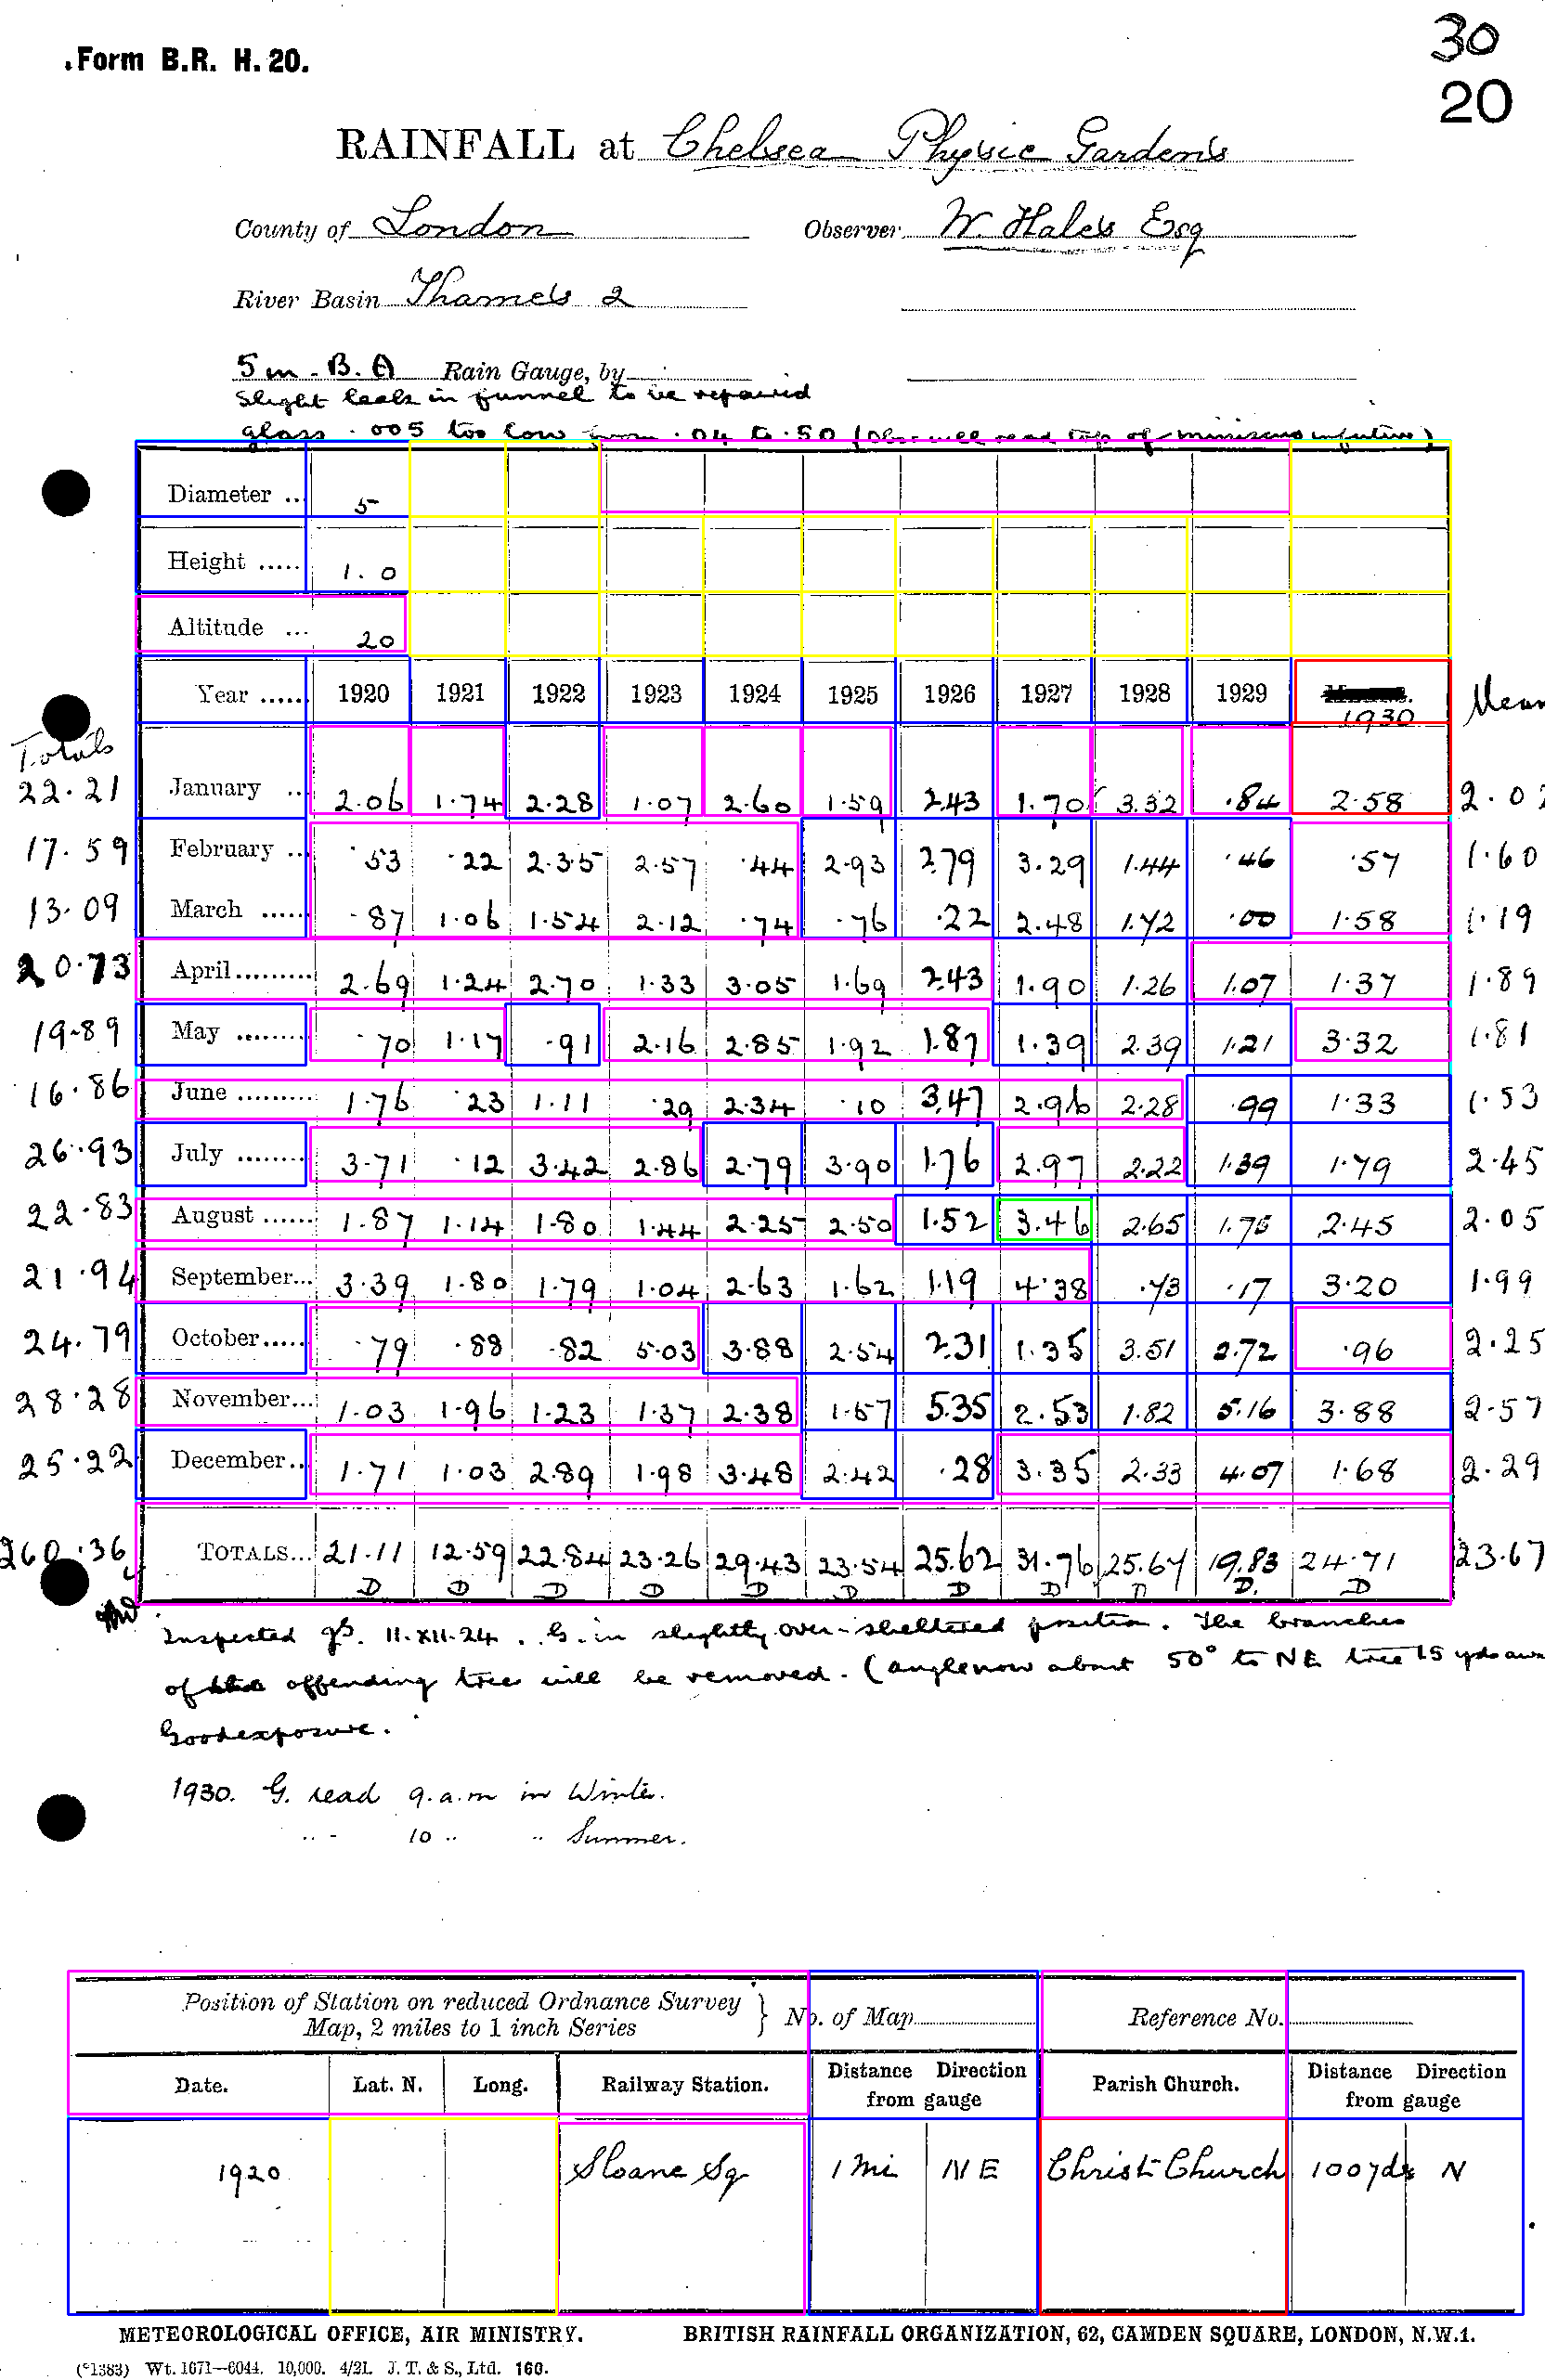

In [78]:
image, height, width, _ = image_preprocessing("temp.jpg")

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in correct_cells:
    put_box(image,box,(0,0,color)) # Blue
    
for box in corrected_excluded_cells:
    put_box(image,box,(0,color,0)) # Green

for box in not_corrected_excluded_cells:
    put_box(image,box,(color,0,0)) # Red
    
for box in error_corrected_cells+new_corrected_excluded_cells:
#     print(box)
    put_box(image,box,(color,0,color))  # pink
    
for box in blank_cells:   
    put_box(image,box,(color,color,0)) # Yellow

im_pil = Image.fromarray(image)
im_pil.save(f"{filename}_temp_cell_multiple_cell_correction.jpg")
im_pil  

In [79]:
#upto here 8 july

In [80]:
def generate_new_cells(y_coords, x_coords):
    possible_cells = []
    x_a = x_coords[0]
    idx =  cell[4]
    for r, x_b in enumerate(x_coords[1:]):
        if abs(x_b-x_a)>2:
            row_a = [(int(x_a),y) for y in y_coords]
            row_b = [(int(x_b),y) for y in y_coords]
            
            for i in range(len(row_a)-1):
                imagedraw = (row_a[i]+row_b[i+1])
                imagedraw = list(map(int, imagedraw))

                xax = abs(imagedraw[2] - imagedraw[0])
                yax = abs(imagedraw[3] - imagedraw[1])
                possible_cells.append(imagedraw+[idx])
            x_a = int(x_b)
    return possible_cells

In [81]:
def segment_image(image, cell, mask):
    mask = masks[1]
    roi = mask[cell[1]:cell[3],cell[0]:cell[2]]
    rows, cols = roi.shape

    tid = cell[4]
    avg_x, avg_y = average_cordinates[tid]

    # check row by row first
    seg_x_region = []
    starting_flag = True
    for i in range(rows):
        if sum(roi[i,:])> cols*0.01 and starting_flag:
            seg_x_region.append(i-1)
            starting_flag = False
        elif sum(roi[i,:]) < cols*0.01 and not starting_flag:
            seg_x_region.append(i+1)
            starting_flag = True
            
    new_row_cells = []
    
    if len(seg_x_region)>1:
        last_end = 0
        flag = False
        for start,end in zip(seg_x_region[0:-1],seg_x_region[1:]):
            if abs(start - end)>avg_y/3:
                if last_end == 0:
                    new_row_cells.append(cell[1]+start) 
                    last_end = end
                else:
                    start = int((last_end+start)/2)
                    new_row_cells.append(cell[1]+start) 
                    last_end = end
                flag = True
            else:
                flag = False

        if flag:
            new_row_cells.append(cell[1]+end)  
            
    new_row_cells = find_coordinates(new_row_cells+[cell[3]], avg_y, 0.7)
    
    if len(new_row_cells)<2:
        new_row_cells = [cell[1],cell[3]]
    print('x', cell, new_row_cells)
        
        
    # check col by col 
    seg_y_region = []
    starting_flag = True

    for i in range(cols):
        if sum(roi[:,i]) > rows*0.05 and starting_flag:
    #         print(f'starting index {i} conditioned on {sum(roi[:,i])} > {rows*0.05}')
            seg_y_region.append(i-1)
            starting_flag = False
        elif sum(roi[:,i])< rows*0.05 and not starting_flag:
    #         print(f'ending index {i} conditioned on {sum(roi[:,i])} > {rows*0.05}')
            seg_y_region.append(i+1)
            starting_flag = True
            
    new_col_cells = []
    if len(seg_y_region)>1:
        last_end = 0
        flag = False
        for start,end in zip(seg_y_region[0:-1],seg_y_region[1:]):
            if abs(start - end)>avg_x/3:
                if last_end == 0:
                    new_col_cells.append(cell[0]+start) 
                    last_end = end
                else:
                    start = int((last_end+start)/2)
                    new_col_cells.append(cell[0]+start) 
                    last_end = end
                flag = True
            else:
                flag = False

        if flag:
            new_col_cells.append(cell[0]+end) 
    
    new_col_cells = find_coordinates(new_col_cells+[cell[2]], avg_x, 0.7)
            
    if len(new_col_cells)<2:
        new_col_cells= [cell[0],cell[2]] 
    print('y', cell, new_col_cells)

    return generate_new_cells(new_row_cells, new_col_cells)

    
        
        
        
    

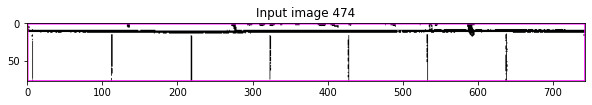

x [646, 474, 1389, 551, 1, [[], []], [1, 5, 1, 1]] [473, 551]
y [646, 474, 1389, 551, 1, [[], []], [1, 5, 1, 1]] [694, 950, 1092, 1280, 1389]


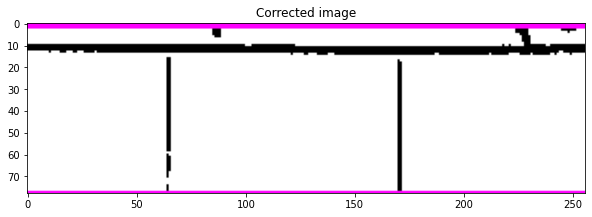

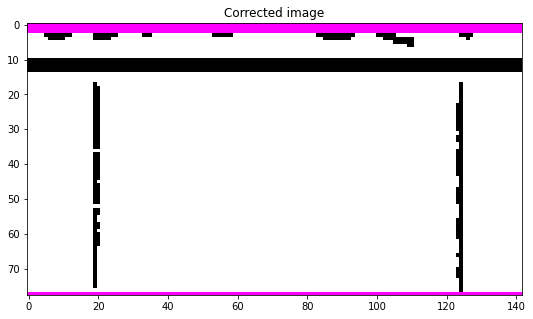

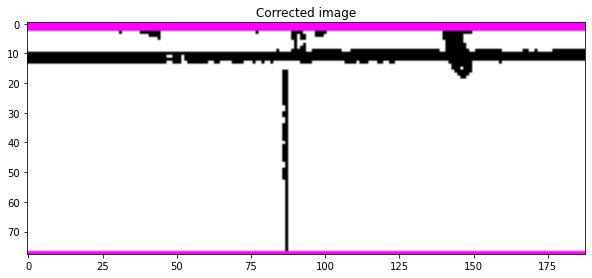

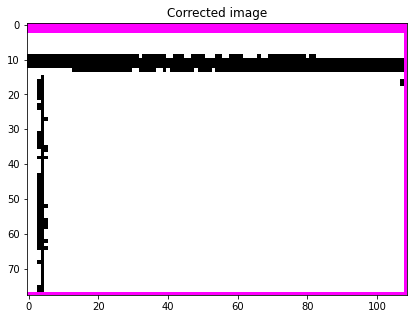

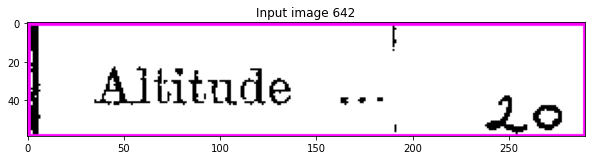

x [146, 642, 436, 701, 1, [[], []], [5, 1, 1, 1]] [667, 700]
y [146, 642, 436, 701, 1, [[], []], [5, 1, 1, 1]] [179, 333, 426]


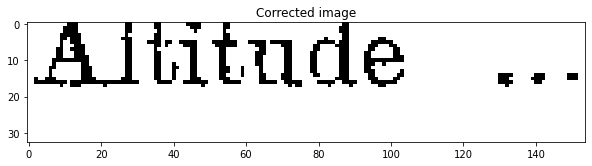

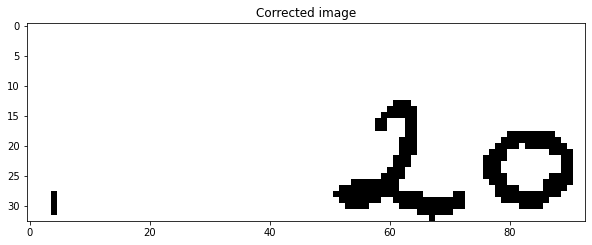

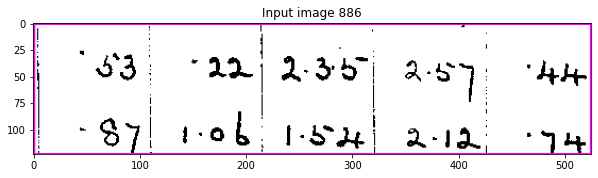

x [334, 886, 859, 1009, 1, [[], [[1390, 881, 1562, 1010, 1]]], [1, 1, 1, 1]] [912, 945, 978, 1009]
y [334, 886, 859, 1009, 1, [[], [[1390, 881, 1562, 1010, 1]]], [1, 1, 1, 1]] [376, 664, 858]


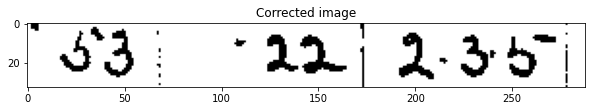

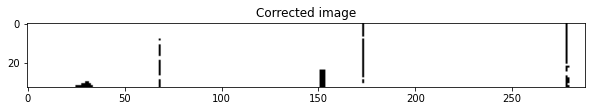

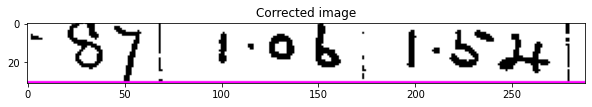

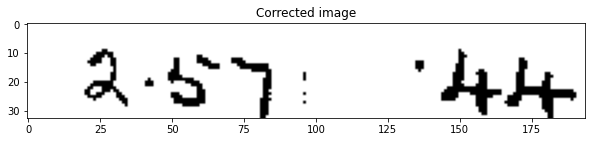

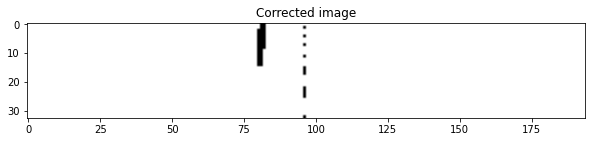

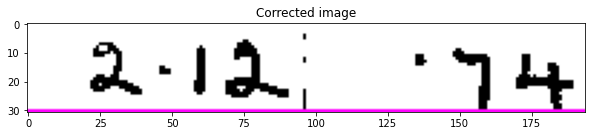

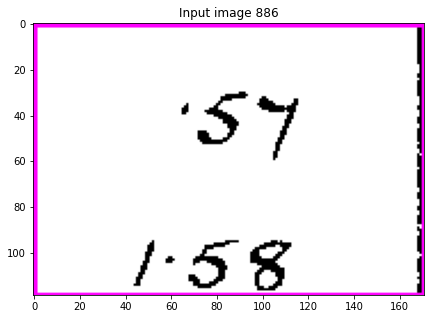

x [1391, 886, 1562, 1005, 1, [[], []], [1, 1, 5, 1]] [913, 972, 1005]
y [1391, 886, 1562, 1005, 1, [[], []], [1, 1, 5, 1]] [1415, 1562]


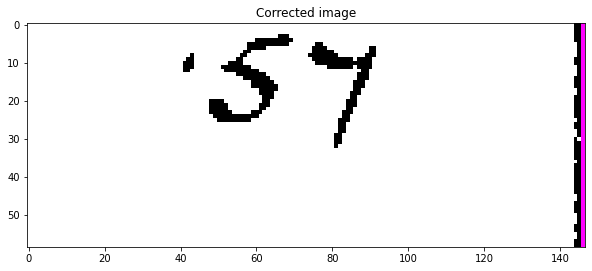

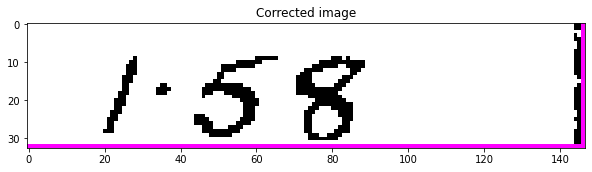

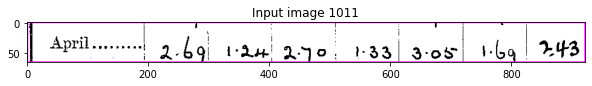

x [146, 1011, 1068, 1076, 1, [[], [[1278, 1010, 1562, 1081, 1]]], [5, 1, 1, 1]] [1039, 1074]
y [146, 1011, 1068, 1076, 1, [[], [[1278, 1010, 1562, 1081, 1]]], [5, 1, 1, 1]] [182, 353, 764, 1068]


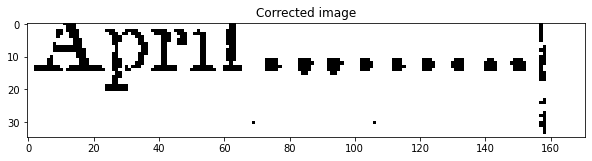

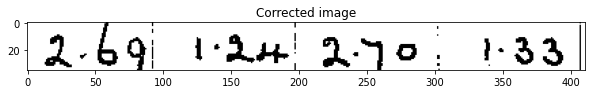

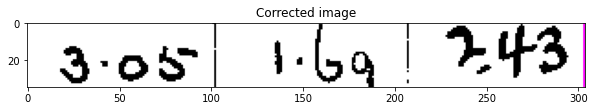

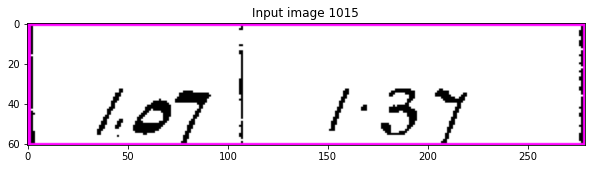

x [1283, 1015, 1562, 1076, 1, [[], []], [1, 1, 5, 1]] [1045, 1076]
y [1283, 1015, 1562, 1076, 1, [[], []], [1, 1, 5, 1]] [1314, 1562]


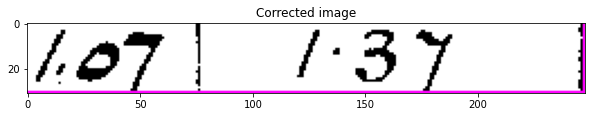

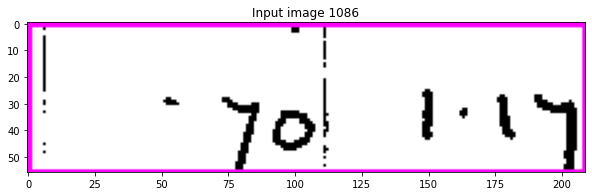

x [334, 1086, 543, 1142, 1, [[], [[645, 1081, 1069, 1147, 1]]], [1, 1, 1, 1]] [1111, 1142]
y [334, 1086, 543, 1142, 1, [[], [[645, 1081, 1069, 1147, 1]]], [1, 1, 1, 1]] [334, 543]


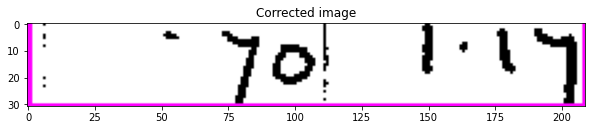

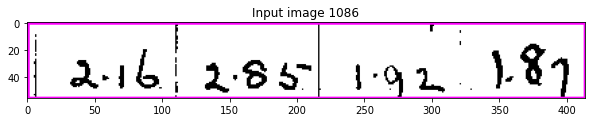

x [650, 1086, 1064, 1142, 1, [[], [[329, 1081, 544, 1147, 1], [1390, 1081, 1562, 1147, 1]]], [1, 1, 1, 1]] [1111, 1142]
y [650, 1086, 1064, 1142, 1, [[], [[329, 1081, 544, 1147, 1], [1390, 1081, 1562, 1147, 1]]], [1, 1, 1, 1]] [679, 873, 1059]


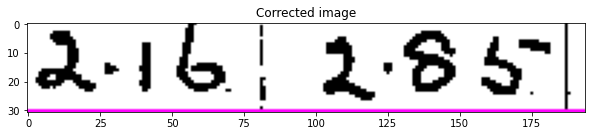

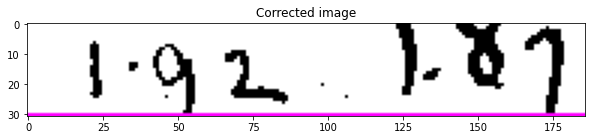

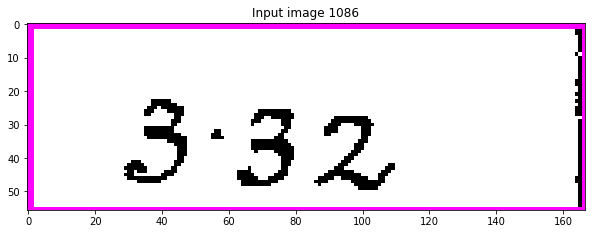

x [1395, 1086, 1562, 1142, 1, [[], []], [1, 1, 5, 1]] [1103, 1138]
y [1395, 1086, 1562, 1142, 1, [[], []], [1, 1, 5, 1]] [1422, 1509, 1562]


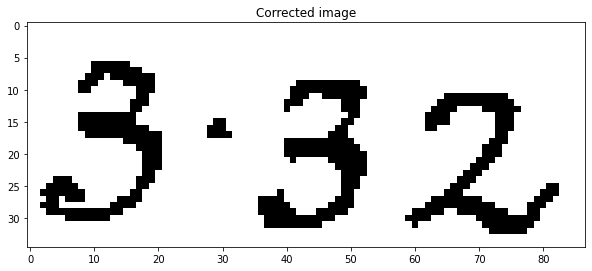

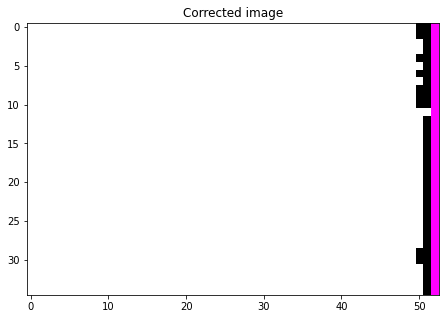

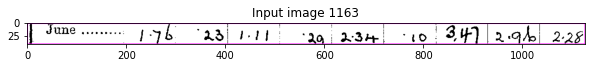

x [146, 1163, 1273, 1205, 1, [[], []], [5, 1, 1, 1]] [1163, 1205]
y [146, 1163, 1273, 1205, 1, [[], []], [5, 1, 1, 1]] [179, 352, 558, 683, 873, 1075, 1190, 1273]


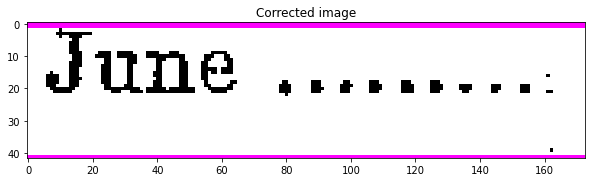

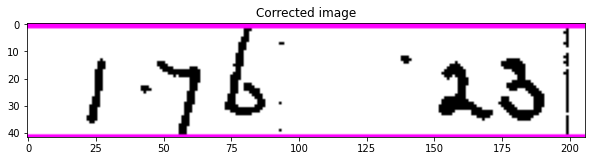

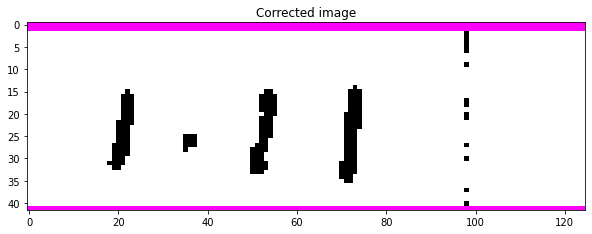

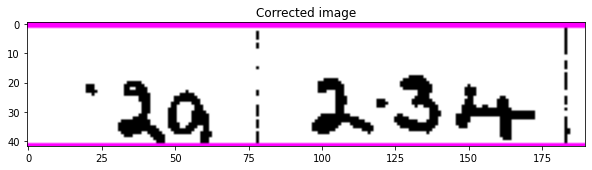

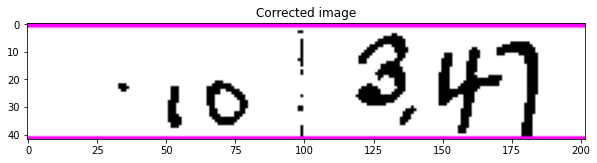

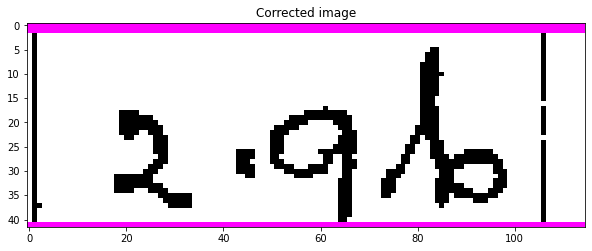

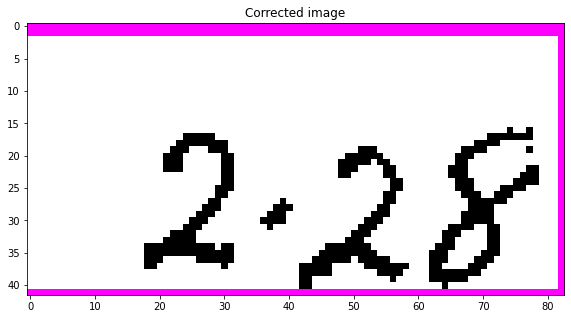

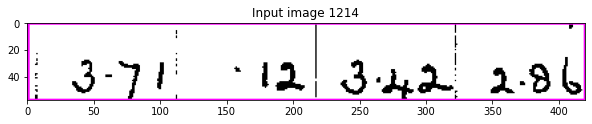

x [334, 1214, 754, 1272, 1, [[], [[1069, 1209, 1278, 1277, 1]]], [1, 1, 1, 1]] [1242, 1272]
y [334, 1214, 754, 1272, 1, [[], [[1069, 1209, 1278, 1277, 1]]], [1, 1, 1, 1]] [366, 754]


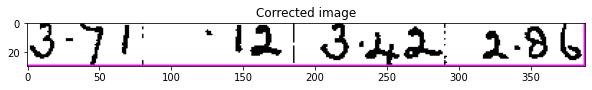

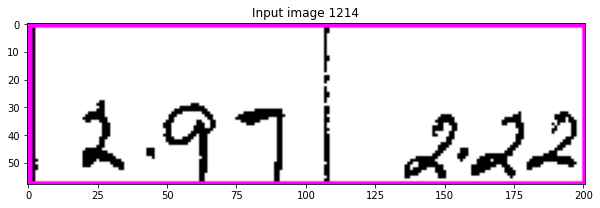

x [1074, 1214, 1275, 1272, 1, [[], []], [1, 1, 1, 1]] [1241, 1272]
y [1074, 1214, 1275, 1272, 1, [[], []], [1, 1, 1, 1]] [1090, 1275]


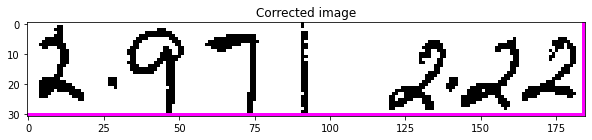

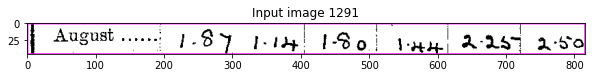

x [146, 1291, 962, 1336, 1, [[], []], [5, 1, 1, 1]] [1294, 1336]
y [146, 1291, 962, 1336, 1, [[], []], [5, 1, 1, 1]] [174, 340, 767, 962]


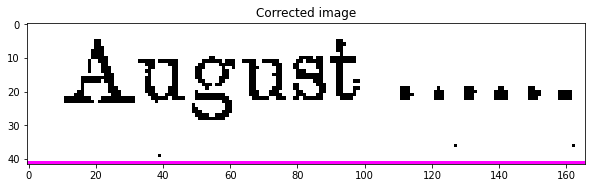

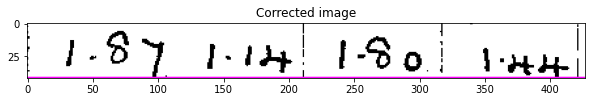

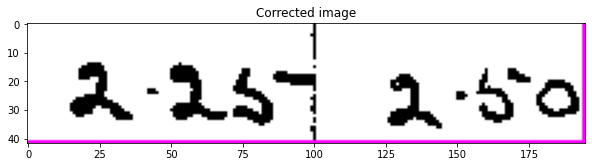

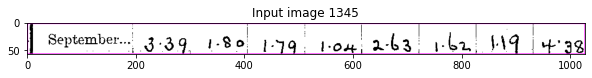

x [146, 1345, 1173, 1402, 1, [[], []], [5, 1, 1, 1]] [1365, 1402]
y [146, 1345, 1173, 1402, 1, [[], []], [5, 1, 1, 1]] [183, 345, 773, 874, 1173]


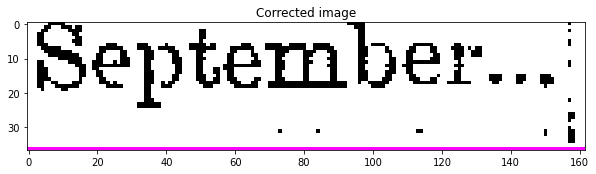

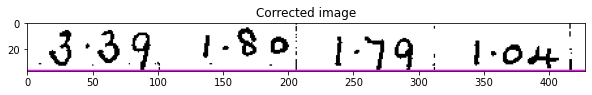

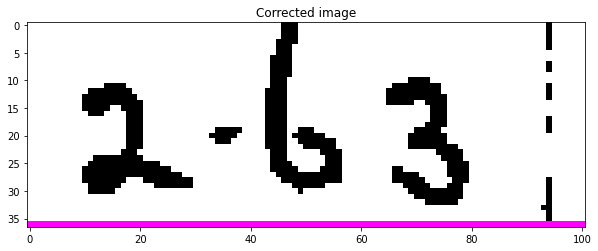

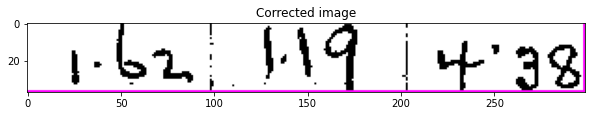

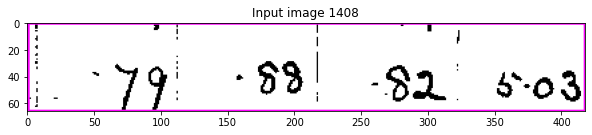

x [334, 1408, 752, 1474, 1, [[], [[1390, 1403, 1562, 1479, 1]]], [1, 1, 1, 1]] [1435, 1471]
y [334, 1408, 752, 1474, 1, [[], [[1390, 1403, 1562, 1479, 1]]], [1, 1, 1, 1]] [365, 751]


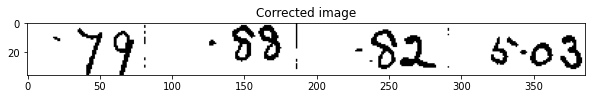

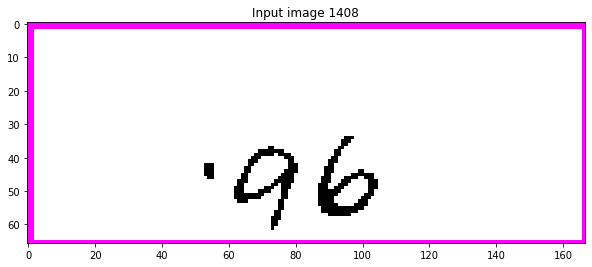

x [1395, 1408, 1562, 1474, 1, [[], []], [1, 1, 5, 1]] [1439, 1471]
y [1395, 1408, 1562, 1474, 1, [[], []], [1, 1, 5, 1]] [1420, 1505, 1562]


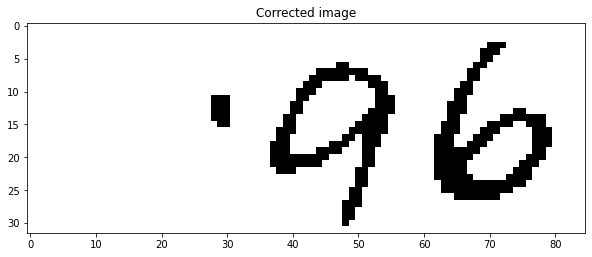

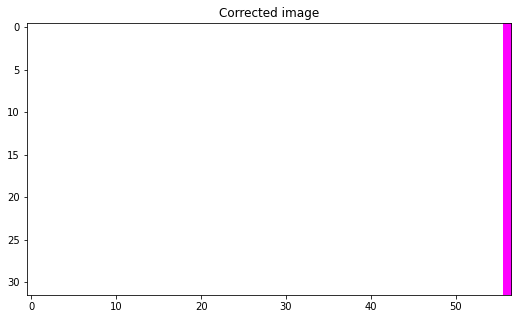

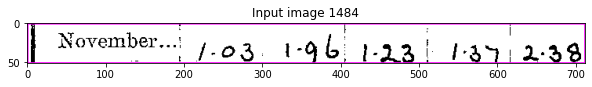

x [146, 1484, 858, 1535, 1, [[], []], [5, 1, 1, 1]] [1484, 1535]
y [146, 1484, 858, 1535, 1, [[], []], [5, 1, 1, 1]] [177, 352, 663, 856]


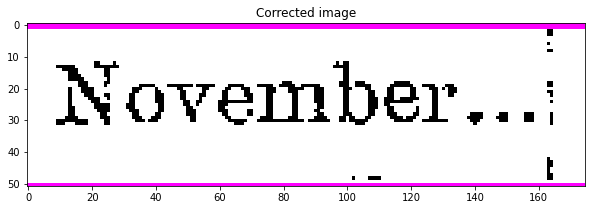

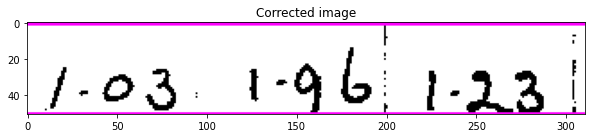

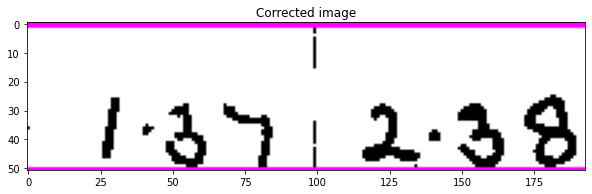

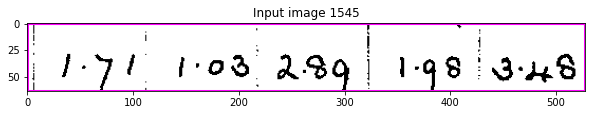

x [334, 1545, 862, 1609, 1, [[], [[1069, 1540, 1562, 1614, 1]]], [1, 1, 1, 1]] [1573, 1609]
y [334, 1545, 862, 1609, 1, [[], [[1069, 1540, 1562, 1614, 1]]], [1, 1, 1, 1]] [362, 862]


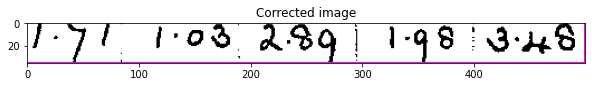

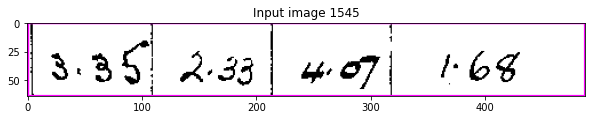

x [1074, 1545, 1562, 1609, 1, [[], []], [1, 1, 5, 1]] [1569, 1600]
y [1074, 1545, 1562, 1609, 1, [[], []], [1, 1, 5, 1]] [1091, 1193, 1292, 1415, 1508]


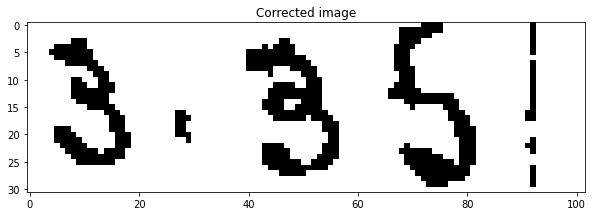

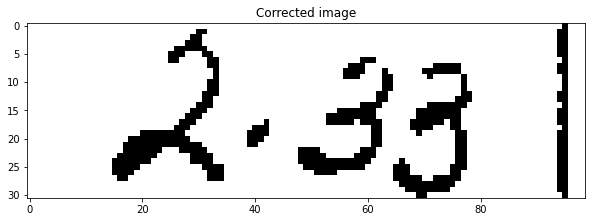

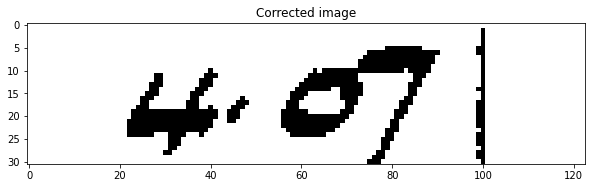

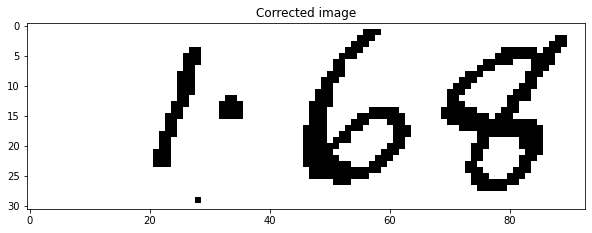

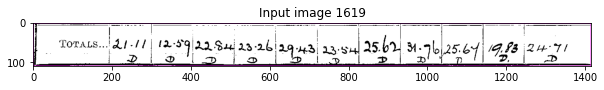

x [146, 1619, 1562, 1728, 1, [[], []], [5, 1, 5, 5]] [1627, 1661, 1700, 1728]
y [146, 1619, 1562, 1728, 1, [[], []], [5, 1, 5, 5]] [208, 974, 1295, 1562]


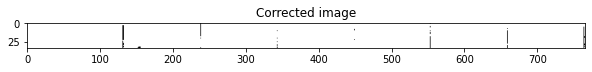

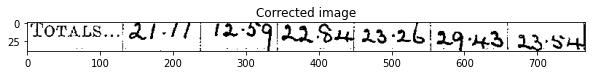

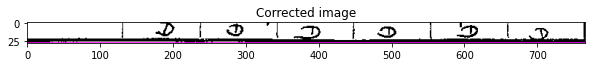

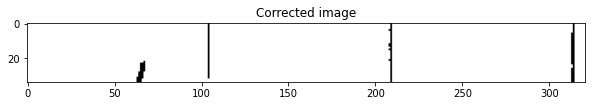

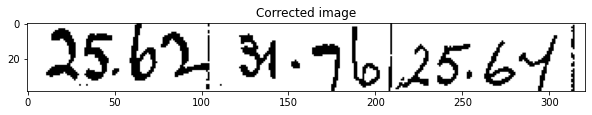

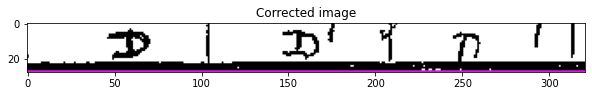

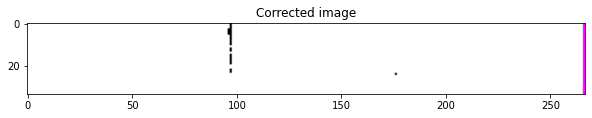

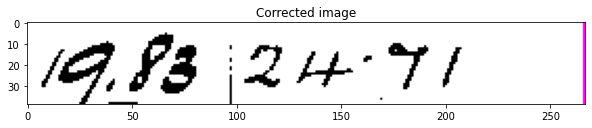

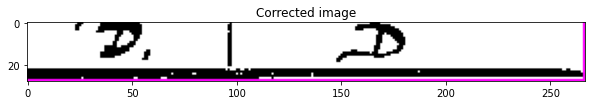

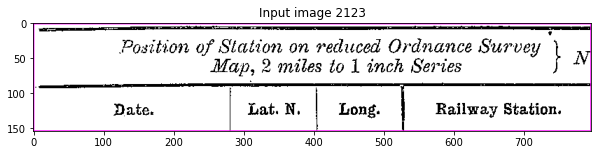

x [73, 2123, 870, 2277, 1, [[], [[1117, 2123, 1386, 2282, 0]]], [5, 5, 1, 1]] [2150, 2195, 2239, 2277]
y [73, 2123, 870, 2277, 1, [[], [[1117, 2123, 1386, 2282, 0]]], [5, 5, 1, 1]] [186, 870]


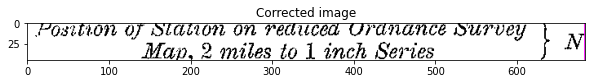

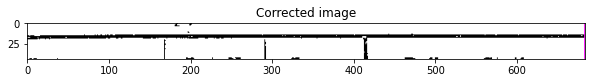

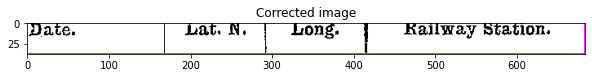

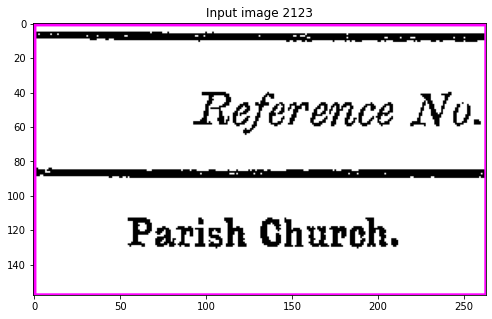

x [1122, 2123, 1385, 2281, 1, [[], []], [1, 5, 1, 1]] [2167, 2239, 2279]
y [1122, 2123, 1385, 2281, 1, [[], []], [1, 5, 1, 1]] [1174, 1377]


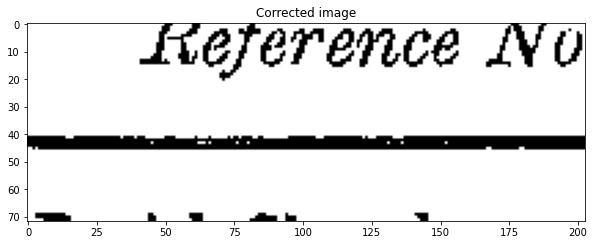

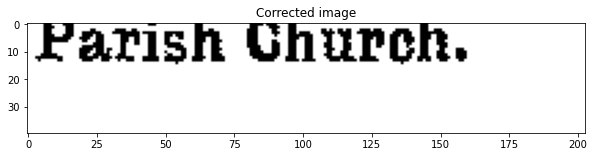

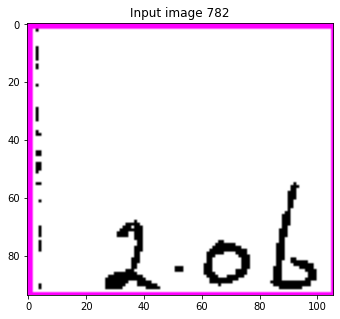

x [334, 782, 440, 876, 1, [[706, 2282], [[441, 778, 544, 881, 1]]], [1, 1, 1, 1]] [784, 850, 876]
y [334, 782, 440, 876, 1, [[706, 2282], [[441, 778, 544, 881, 1]]], [1, 1, 1, 1]] [334, 440]


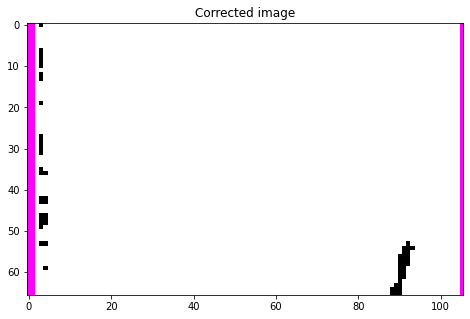

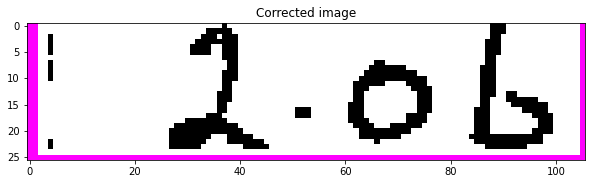

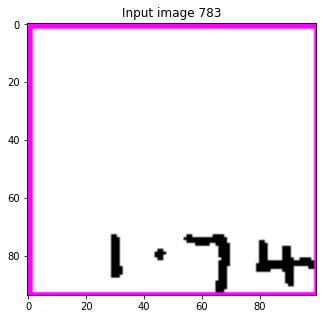

x [442, 783, 542, 877, 1, [[706, 2282], [[329, 778, 441, 881, 1], [645, 778, 757, 881, 1]]], [1, 1, 1, 1]] [783, 877]
y [442, 783, 542, 877, 1, [[706, 2282], [[329, 778, 441, 881, 1], [645, 778, 757, 881, 1]]], [1, 1, 1, 1]] [441, 542]


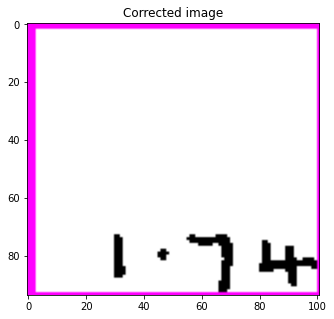

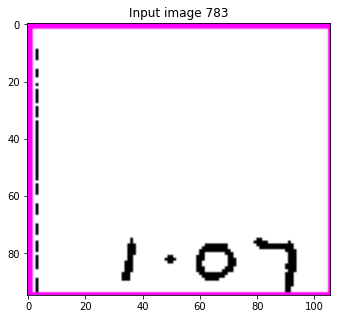

x [650, 783, 756, 878, 1, [[706, 2282], [[441, 778, 544, 881, 1], [757, 778, 863, 881, 1]]], [1, 1, 1, 1]] [783, 878]
y [650, 783, 756, 878, 1, [[706, 2282], [[441, 778, 544, 881, 1], [757, 778, 863, 881, 1]]], [1, 1, 1, 1]] [650, 756]


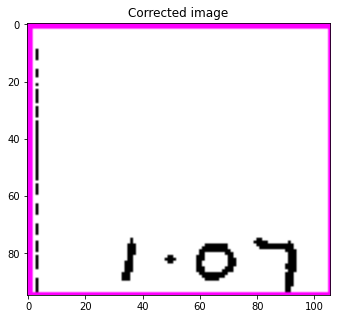

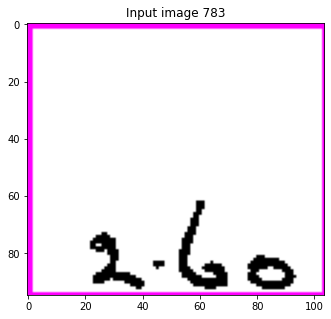

x [758, 783, 862, 878, 1, [[706, 2282], [[645, 778, 757, 881, 1], [863, 778, 964, 881, 1]]], [1, 1, 1, 1]] [783, 878]
y [758, 783, 862, 878, 1, [[706, 2282], [[645, 778, 757, 881, 1], [863, 778, 964, 881, 1]]], [1, 1, 1, 1]] [758, 862]


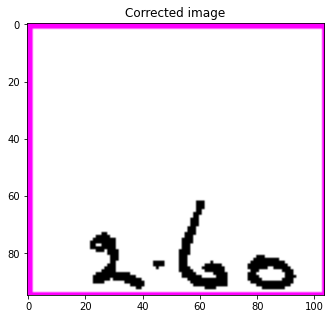

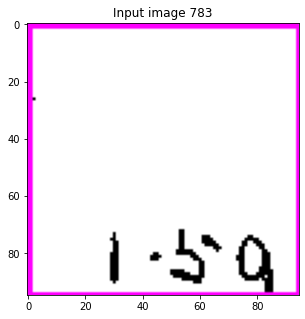

x [864, 783, 959, 878, 1, [[706, 2282], [[757, 778, 863, 881, 1], [1069, 778, 1175, 881, 1]]], [1, 1, 1, 1]] [783, 878]
y [864, 783, 959, 878, 1, [[706, 2282], [[757, 778, 863, 881, 1], [1069, 778, 1175, 881, 1]]], [1, 1, 1, 1]] [883, 959]


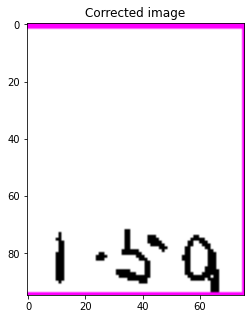

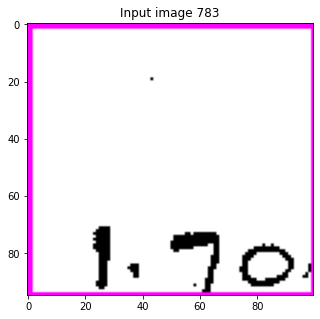

x [1074, 783, 1174, 878, 1, [[706, 2282], [[863, 778, 964, 881, 1], [1175, 778, 1278, 881, 1]]], [1, 1, 1, 1]] [783, 878]
y [1074, 783, 1174, 878, 1, [[706, 2282], [[863, 778, 964, 881, 1], [1175, 778, 1278, 881, 1]]], [1, 1, 1, 1]] [1074, 1174]


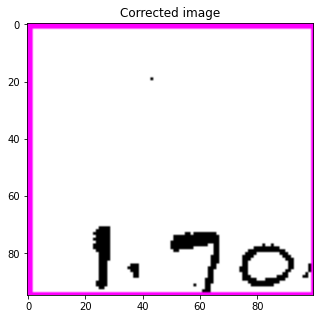

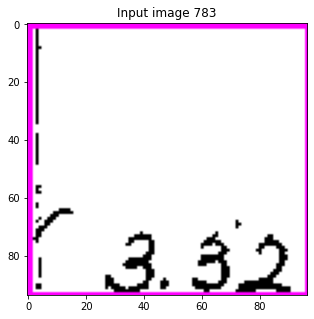

x [1176, 783, 1273, 877, 1, [[706, 2282], [[1069, 778, 1175, 881, 1], [1278, 778, 1390, 881, 1]]], [1, 1, 1, 1]] [783, 877]
y [1176, 783, 1273, 877, 1, [[706, 2282], [[1069, 778, 1175, 881, 1], [1278, 778, 1390, 881, 1]]], [1, 1, 1, 1]] [1175, 1270]


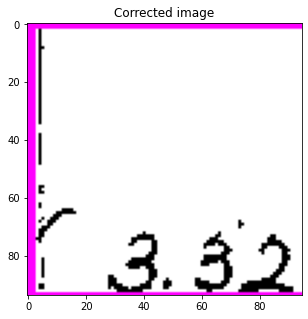

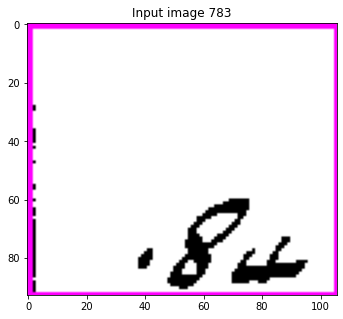

x [1283, 783, 1389, 876, 1, [[706, 2282], [[1175, 778, 1278, 881, 1], [1390, 778, 1562, 881, 1]]], [1, 1, 1, 1]] [855, 876]
y [1283, 783, 1389, 876, 1, [[706, 2282], [[1175, 778, 1278, 881, 1], [1390, 778, 1562, 881, 1]]], [1, 1, 1, 1]] [1283, 1389]


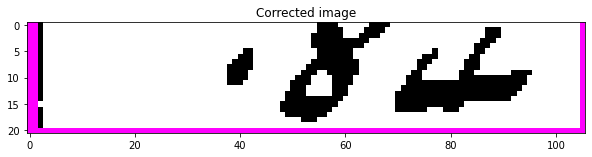

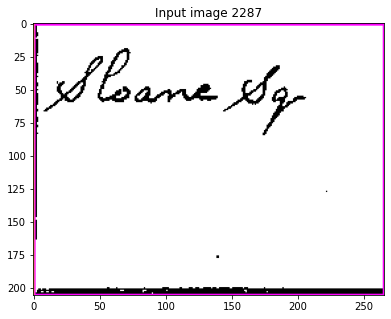

x [600, 2287, 866, 2493, 1, [[], [[1117, 2282, 1386, 2493, 0]]], [1, 1, 1, 5]] [2325, 2356, 2493]
y [600, 2287, 866, 2493, 1, [[], [[1117, 2282, 1386, 2493, 0]]], [1, 1, 1, 5]] [617, 809]


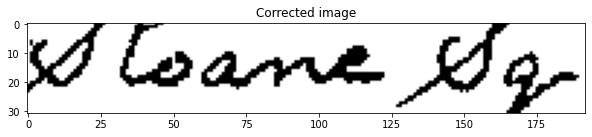

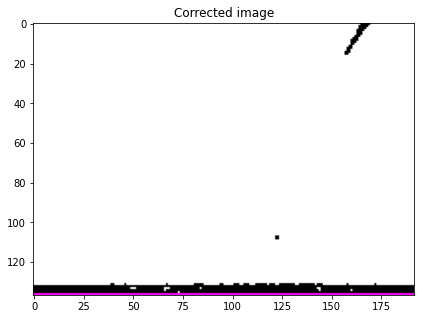

In [82]:
new_corrected_cells = []
for imagedraw in error_corrected_cells+new_corrected_excluded_cells:#
    
    croppedimage_full=image[int(imagedraw[1]):int(imagedraw[3]),int(imagedraw[0]):int(imagedraw[2])]
    plt.rcParams["figure.figsize"] = (10,5)
    plt.imshow(croppedimage_full)
    plt.title(f'Input image {imagedraw[1]}')
    plt.show()
    
    possible_cells = segment_image(image, imagedraw, masks[1])
    new_corrected_cells +=possible_cells
    
    for cell in possible_cells:
        croppedimage_full=image[int(cell[1]):int(cell[3]),int(cell[0]):int(cell[2])]
        plt.rcParams["figure.figsize"] = (10,5)
        plt.imshow(croppedimage_full)
        plt.title(f'Corrected image')
        plt.show()
    

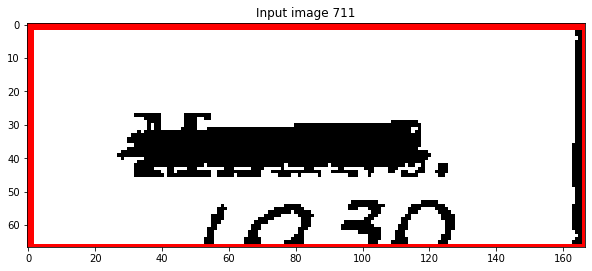

x [1395, 711, 1562, 778, 0, [[778], []], [1, 1, 5, 0]] [711, 778]
y [1395, 711, 1562, 778, 0, [[778], []], [1, 1, 5, 0]] [1419, 1562]


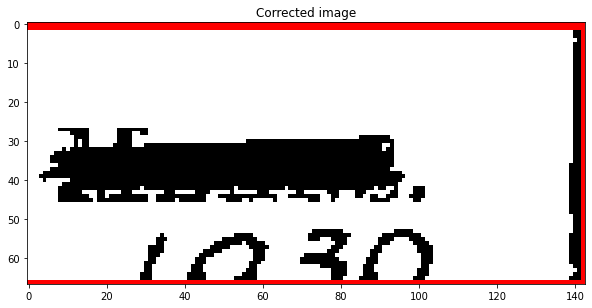

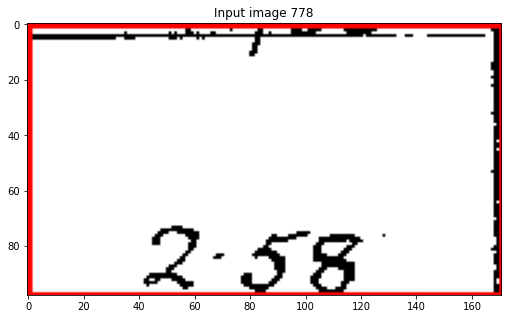

x [1391, 778, 1562, 876, 0, [[706, 2282], []], [1, 0, 5, 1]] [786, 876]
y [1391, 778, 1562, 876, 0, [[706, 2282], []], [1, 0, 5, 1]] [1391, 1562]


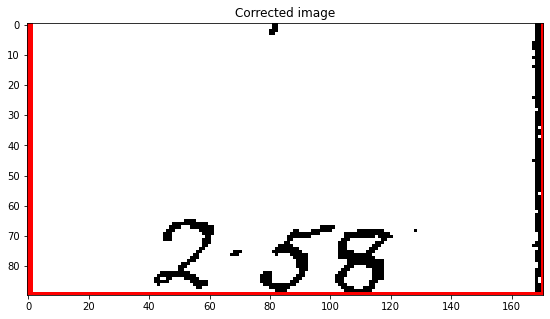

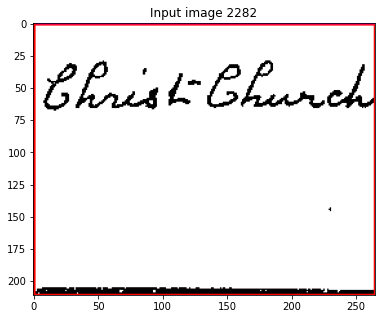

x [1120, 2282, 1385, 2493, 0, [[], []], [1, 0, 1, 5]] [2288, 2493]
y [1120, 2282, 1385, 2493, 0, [[], []], [1, 0, 1, 5]] [1120, 1385]


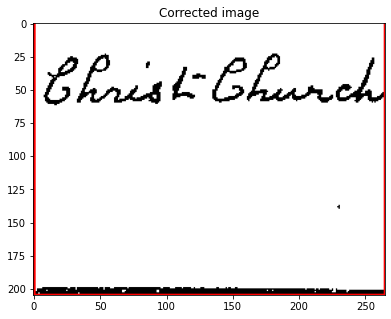

In [83]:
error_cells_corrected = []
for imagedraw in not_corrected_excluded_cells:#
    
    croppedimage_full=image[int(imagedraw[1]):int(imagedraw[3]),int(imagedraw[0]):int(imagedraw[2])]
    plt.rcParams["figure.figsize"] = (10,5)
    plt.imshow(croppedimage_full)
    plt.title(f'Input image {imagedraw[1]}')
    plt.show()
    
    possible_cells = segment_image(image, imagedraw, masks[1])
    error_cells_corrected += possible_cells
    for cell in possible_cells:
        croppedimage_full=image[int(cell[1]):int(cell[3]),int(cell[0]):int(cell[2])]
        plt.rcParams["figure.figsize"] = (10,5)
        plt.imshow(croppedimage_full)
        plt.title(f'Corrected image')
        plt.show()
    

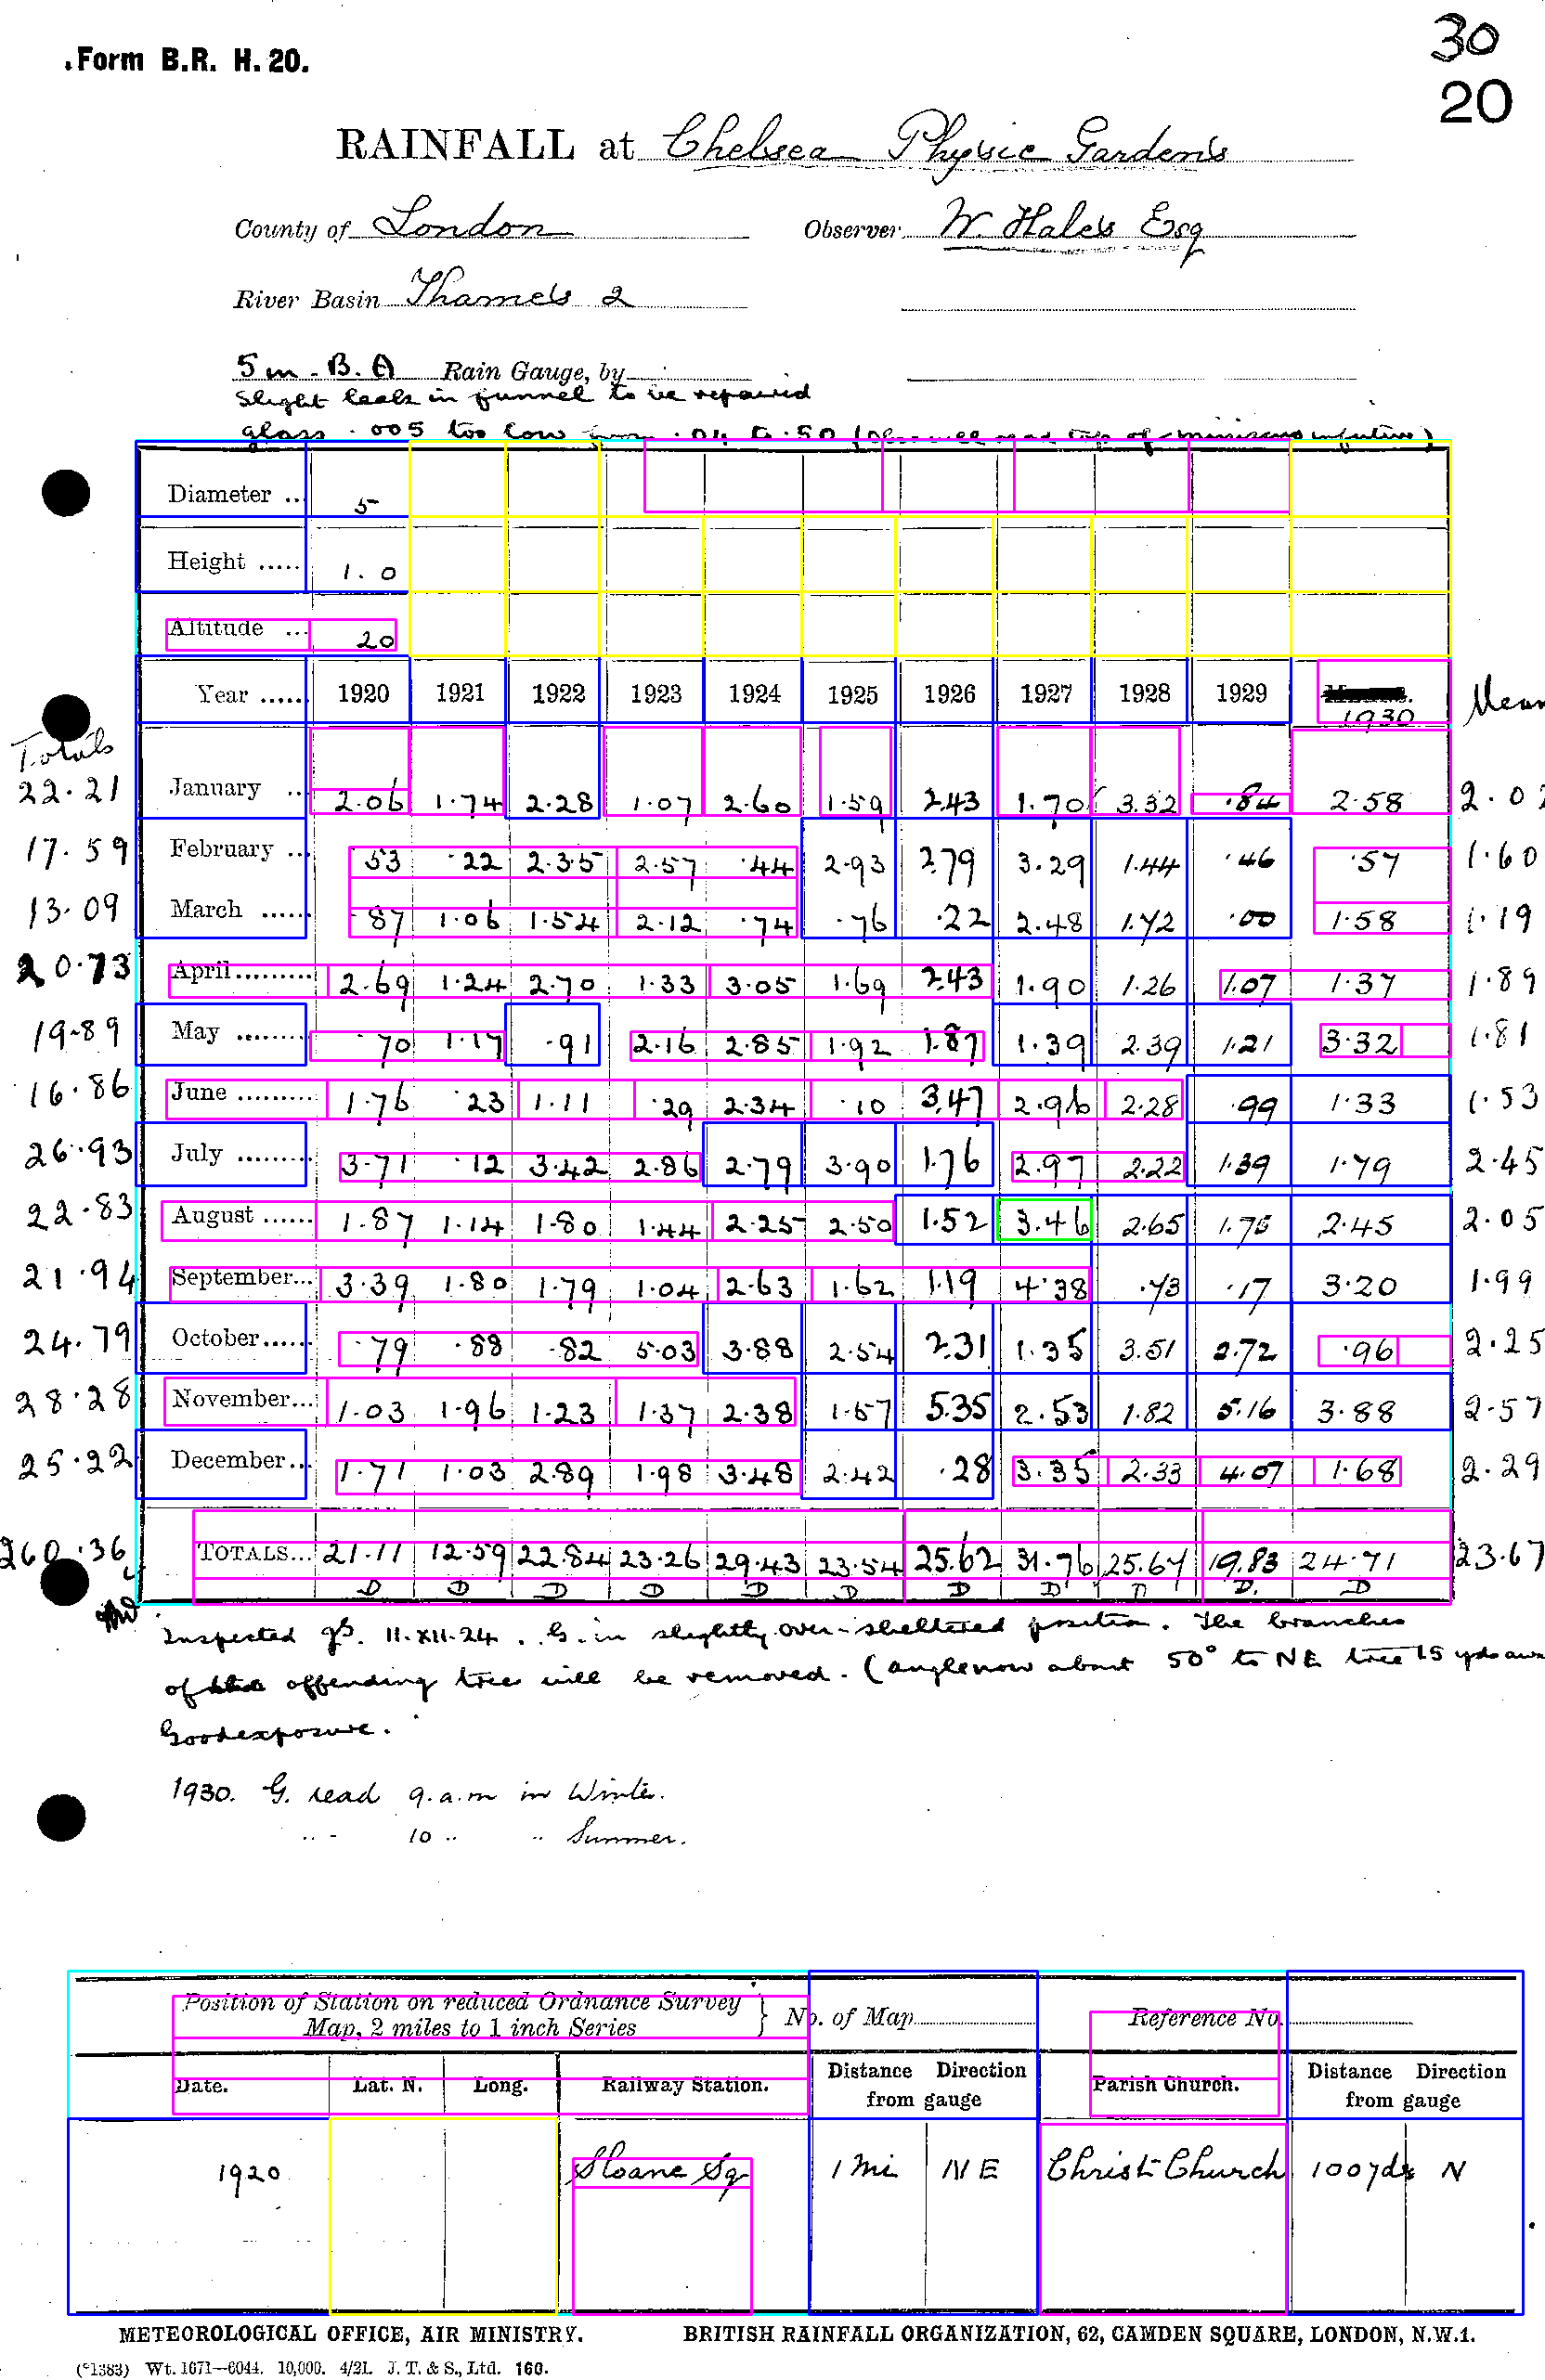

In [84]:
image, height, width, _ = image_preprocessing("temp.jpg")

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in correct_cells:
    put_box(image,box,(0,0,color)) # Blue
    
for box in corrected_excluded_cells:
    put_box(image,box,(0,color,0)) # Green

for box in new_corrected_cells:
    put_box(image,box,(color,0,color)) # pink
    
for box in error_cells_corrected:
#     print(box)
    put_box(image,box,(color,0,color))  # pink
    
for box in blank_cells:   
    put_box(image,box,(color,color,0)) # Yellow

im_pil = Image.fromarray(image)
im_pil.save(f"{filename}_temp_cell_multiple_cell_segmentation_correction.jpg")
im_pil  